# Chapter 3: Tuned gain control model

Last access (y.m.d): 23.01.23  
Last update (y.m.d): 23.01.23

# Contents
1. Debugging the model (major)   
2. Exploring flat gain control   
    - i.e. an exploration of how/why even an untuned gain control shows apparent frequency-dependent summation on the Abramov-Levine plot 
3. Re-introducing full normalization  
    - i.e. rather than just scalar adjustments, actually have stimulus/temporal dynamics   
    - 3A: LGN yoked to V1 filter  
        - Rather than having a fixed-for-all neurons, let's allow the LGN filters to be placed symmetrically around the V1 preference  
4. Hyperparameter tuning (again; better)
5. Analysis! Cross-validation  
6. Analysis! Superposition?
7. Model investigation/understanding

In [36]:
import pandas as pd
pd.set_option('display.float_format', '{:.3f}'.format)

import pdb
import model_responses_pytorch as mrpt
import plot_superposition_func as psf
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

import warnings
warnings.filterwarnings(action='once')

import numpy as np
import os
import helper_fcns as hf
import helper_fcns_sfBB as hf_sfBB
# import model_responses as mr
import scipy.stats as ss
import scipy.odr.odrpack as odrpack
from scipy.stats.mstats import gmean
from scipy.stats import ks_2samp, kstest, linregress
import itertools
import autoreload
from IPython.core.display import display, HTML, Image

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.backends.backend_pdf as pltSave
from matplotlib.ticker import FuncFormatter

from helper_fcns_sfBB import compute_f1f0 as bb_compute_f1f0
from helper_fcns_sfBB import get_resp_str

import plot_sf_figs as psf

# plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

base_dir = os.getcwd() + '/';

%matplotlib inline

In [3]:
from matplotlib import rcParams

tex_width = 469; # per \layout in Overleaf on document
sns_offset = 2; 
hist_width = 0.9;
hist_ytitle = 0.94; # moves the overall title a bit further down on histogram plots0

rcParams.update(mpl.rcParamsDefault)

fontsz = 12;
tick_scalar = 1.5;

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {'text.usetex' : True,
          'font.size' : fontsz,
          'font.family': 'lmodern',
           'font.style': 'italic'}
plt.rcParams.update(params)

# rcParams['lines.linewidth'] = 2.5;
rcParams['lines.markeredgewidth'] = 0; # no edge, since weird tings happen then
# rcParams['axes.linewidth'] = 2; # was 1.5
# rcParams['lines.markersize'] = 5;

tick_adj = ['xtick.major.size', 'xtick.minor.size', 'ytick.major.size', 'ytick.minor.size']
for adj in tick_adj:
    rcParams[adj] = rcParams[adj] * tick_scalar;
    
%matplotlib inline

date = '_230121'

saveName = 'figures/reports/ch03_superpos_masks%s/' % (date); # for one save name for all figures
save_loc = base_dir + saveName;

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  app.launch_new_instance()


# 1. Model debugging

As of 22.10.04, realize we need to tune all of the optimization hyperparameters if we're going to use pytorch!

## 1.1 Exploring the hyperparameters

In [11]:
cellNum = 40
expDir = 'V1/'
respMeasure = 0; # dc [0] or f1 [1]

excType = 2; # 1 is deriv. order, 2 is flex. gauss
lossType = 1
fitType = 2 # flat [1], tuned [2] or gain tuned[5]
lgnFrontOn = 1
lgnConType = 1
_LGNforNorm = 0

In [20]:
autoreload.reload(mrpt);

In [45]:
batch_size = [64, 128, 256, 512]
epochs = 250
lr = 0.01
dt_loss = [];
for bs in batch_size:
    fit, details = mrpt.setModel(cellNum, expDir, excType, lossType, fitType, lgnFrontOn, lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, trackSteps=1, learning_rate=lr, batch_size=bs, max_epochs = epochs, respMeasure=respMeasure, newMethod=1, vecCorrected=0, scheduler=False, to_save=False, )
    dt_loss.append([np.mean(x) for x in details['loss']])


FitList: fitList_pyt_221004_LGN_wght_sqrt.npy [expDir is V1/]
loading data structure from /arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/V1/structures/...
expInd is 5
respMeasure, vecCorrected: 0, 0

********MODEL PARAMETERS********
prefSf: 1.89
sigma l|r: -1.76|0.32
mWeight: 0.30 (orig -0.86)
scalar|early|late: 0.349|0.091|-0.031
norm. const.: -2.00
tuned norm mn|std: 1.31|1.00
No LGN for GC
********END OF MODEL PARAMETERS********

cell 40: rem. is 48 [last iteration]

****** STEP 0 [dc] [t=20:14:14] [prev loss: nan] *********
...finished. New NLL (4.63) vs. previous NLL (10000000.00)

FitList: fitList_pyt_221004_LGN_wght_sqrt.npy [expDir is V1/]
loading data structure from /arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/V1/structures/...
expInd is 5
respMeasure, vecCorrected: 0, 0

********MODEL PARAMETERS********
prefSf: 1.53
sigma l|r: -0.87|0.34
mWeight: 0.66 (orig 0.68)
scalar|early|late: 0.022|-0.067|-0.337
norm. const.: -2.00
tuned norm mn|std: 1.12|1.94

This was with lr = 0.01, epochs = 250, NO scheduler

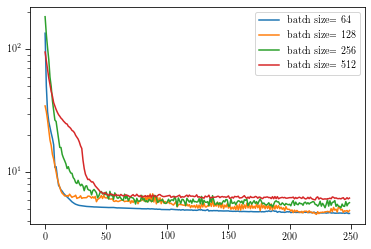

In [65]:
for ii, val in enumerate(dt_loss):

    plt.plot(val, label='batch size= %d' % batch_size[ii]);

plt.yscale('log')
plt.legend();

This was with lr = 0.05, epochs = 100, NO scheduler

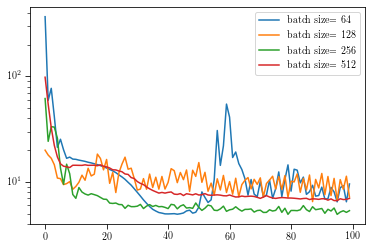

In [43]:
for ii, val in enumerate(dt_loss):

    plt.plot(val, label='batch size= %d' % batch_size[ii]);

plt.yscale('log')
plt.legend();

This was with lr = 0.01, epochs = 100, but NO scheduler (Run again)

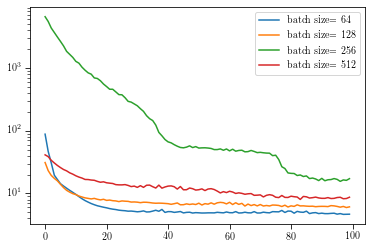

In [41]:
for ii, val in enumerate(dt_loss):

    plt.plot(val, label='batch size= %d' % batch_size[ii]);

plt.yscale('log')
plt.legend();

This was with lr = 0.01, epochs = 100, but NO scheduler (Run again)

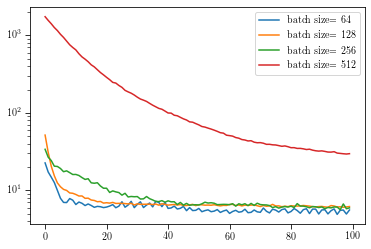

In [39]:
for ii, val in enumerate(dt_loss):

    plt.plot(val, label='batch size= %d' % batch_size[ii]);

plt.yscale('log')
plt.legend();

This was with lr = 0.01, epochs = 100

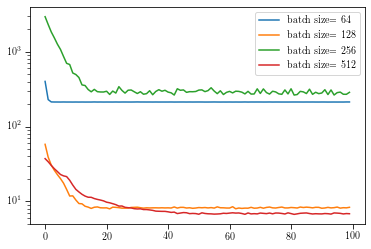

In [37]:
for ii, val in enumerate(dt_loss):

    plt.plot(val, label='batch size= %d' % batch_size[ii]);

plt.yscale('log')
plt.legend();

This was with lr = 0.1, epochs = 100

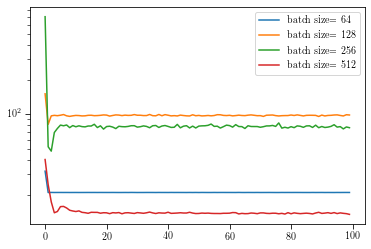

In [35]:
for ii, val in enumerate(dt_loss):

    plt.plot(val, label='batch size= %d' % batch_size[ii]);

plt.yscale('log')
plt.legend();

This was with lr = 0.1, epochs = 25

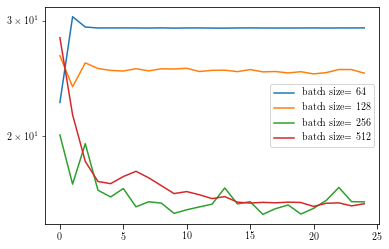

In [33]:
for ii, val in enumerate(dt_loss):

    plt.plot(val, label='batch size= %d' % batch_size[ii]);

plt.yscale('log')
plt.legend();

This was with lr = 0.03, epochs=25

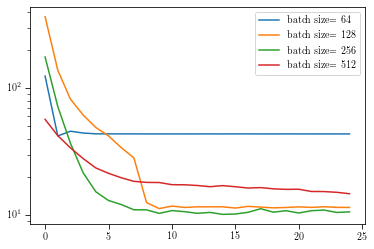

In [31]:
for ii, val in enumerate(dt_loss):

    plt.plot(val, label='batch size= %d' % batch_size[ii]);

plt.yscale('log')
plt.legend();

This was with lr = 0.03, epochs=50

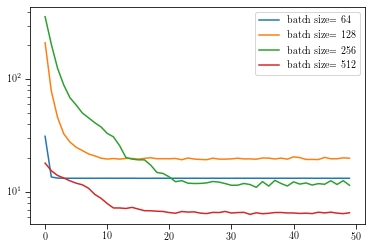

In [29]:
for ii, val in enumerate(dt_loss):

    plt.plot(val, label='batch size= %d' % batch_size[ii]);

plt.yscale('log')
plt.legend();

## 1.2 Grid search on hyperparameters:

In [98]:
pg[0].keys()

dict_keys(['scheduler', 'lr', 'epochs', 'batch_size'])

In [116]:
autoreload.reload(mrpt);

In [129]:
batch_size = [64, 128, 256, 512] # 1024 will cover full stimulus set for most cells (all 2s presentations)
learning_rate = np.geomspace(0.01, 0.15, 4)
epochs = [25, 50, 250]
scheduler = [0, 1]; # off vs. on --> currently, patience is max(8, epochs/10) and factor=0.1

param_grid = {'batch_size': batch_size, 'lr': learning_rate, 'epochs': epochs, 'scheduler': scheduler}
pg = ParameterGrid(param_grid)

pg_loss = np.nan * np.zeros((len(pg), 2)); # [0,1] will be loss and duration of run!

for i,curr_hyper in enumerate(pg):
    if np.mod(i,int(len(pg)/10))==0:
        print('hyper. set %d of %d' % (i, len(pg)));
        
    fit, details = mrpt.setModel(cellNum, expDir, excType, lossType, fitType, lgnFrontOn, 
                                 lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, trackSteps=1, 
                                 learning_rate=curr_hyper['lr'], batch_size=curr_hyper['batch_size'], 
                                 max_epochs = curr_hyper['epochs'], scheduler=curr_hyper['scheduler'], 
                                 respMeasure=respMeasure, newMethod=1, vecCorrected=0, to_save=False, )
    try:
        pg_loss[i,0] = fit['NLL'];
        pg_loss[i,1] = details['time'][-1][-1] # end time of last epoch!
    except:
        pass

hyper. set 0 of 96
hyper. set 9 of 96
hyper. set 18 of 96
hyper. set 27 of 96
hyper. set 36 of 96
hyper. set 45 of 96
hyper. set 54 of 96
hyper. set 63 of 96
hyper. set 72 of 96
hyper. set 81 of 96
hyper. set 90 of 96


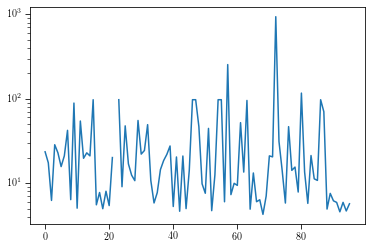

In [131]:
plt.plot(pg_loss[:,0])
plt.yscale('log')

In [140]:
min_arg_of_non_nans = np.argmin(hf.nan_rm(pg_loss[:,0]))
non_nans = np.where(~np.isnan(pg_loss[:,0]))[0]

In [144]:
np.where([x['epochs']==250 for x in pg])

(array([16, 17, 18, 19, 20, 21, 22, 23, 40, 41, 42, 43, 44, 45, 46, 47, 64,
        65, 66, 67, 68, 69, 70, 71, 88, 89, 90, 91, 92, 93, 94, 95]),)

In [145]:
non_nans[min_arg_of_non_nans]

68

In [149]:
[print('%d: %.3f, %s' % (x, pg_loss[x,0], str(pg[x]))) for x in range(64,74)]

64: 4.913, {'scheduler': 0, 'lr': 0.01, 'epochs': 250, 'batch_size': 256}
65: 13.196, {'scheduler': 1, 'lr': 0.01, 'epochs': 250, 'batch_size': 256}
66: 6.023, {'scheduler': 0, 'lr': 0.0246621207433047, 'epochs': 250, 'batch_size': 256}
67: 6.353, {'scheduler': 1, 'lr': 0.0246621207433047, 'epochs': 250, 'batch_size': 256}
68: 4.264, {'scheduler': 0, 'lr': 0.06082201995573401, 'epochs': 250, 'batch_size': 256}
69: 7.026, {'scheduler': 1, 'lr': 0.06082201995573401, 'epochs': 250, 'batch_size': 256}
70: 21.053, {'scheduler': 0, 'lr': 0.15, 'epochs': 250, 'batch_size': 256}
71: 20.483, {'scheduler': 1, 'lr': 0.15, 'epochs': 250, 'batch_size': 256}
72: 940.029, {'scheduler': 0, 'lr': 0.01, 'epochs': 25, 'batch_size': 512}
73: 31.217, {'scheduler': 1, 'lr': 0.01, 'epochs': 25, 'batch_size': 512}


[None, None, None, None, None, None, None, None, None, None]

In [153]:
[print('%d: %.3f, %s' % (x, pg_loss[x,0], str(pg[x]))) for x in non_nans[np.argsort(pg_loss[non_nans,0])]]

68: 4.264, {'scheduler': 0, 'lr': 0.06082201995573401, 'epochs': 250, 'batch_size': 256}
92: 4.572, {'scheduler': 0, 'lr': 0.06082201995573401, 'epochs': 250, 'batch_size': 512}
42: 4.643, {'scheduler': 0, 'lr': 0.0246621207433047, 'epochs': 250, 'batch_size': 128}
94: 4.680, {'scheduler': 0, 'lr': 0.15, 'epochs': 250, 'batch_size': 512}
52: 4.717, {'scheduler': 0, 'lr': 0.06082201995573401, 'epochs': 25, 'batch_size': 256}
64: 4.913, {'scheduler': 0, 'lr': 0.01, 'epochs': 250, 'batch_size': 256}
88: 4.929, {'scheduler': 0, 'lr': 0.01, 'epochs': 250, 'batch_size': 512}
18: 4.976, {'scheduler': 0, 'lr': 0.0246621207433047, 'epochs': 250, 'batch_size': 64}
44: 4.989, {'scheduler': 0, 'lr': 0.06082201995573401, 'epochs': 250, 'batch_size': 128}
10: 5.050, {'scheduler': 0, 'lr': 0.0246621207433047, 'epochs': 50, 'batch_size': 64}
40: 5.286, {'scheduler': 0, 'lr': 0.01, 'epochs': 250, 'batch_size': 128}
20: 5.421, {'scheduler': 0, 'lr': 0.06082201995573401, 'epochs': 250, 'batch_size': 64}


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [156]:
overall_hyper = dict();
overall_hyper['loss'] = pg_loss[:,0]
overall_hyper['time'] = pg_loss[:,1]
overall_hyper['hyper_params'] = pg;

In [164]:
# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
np.save(save_loc + 'hyper_tuning_v1_040.npy', overall_hyper)

#### Try the grid search again!
More focused parameters and with varExpl (i.e. are those loss values reasonable at all?)
Also, use altExp/4 rather than V1/40

In [268]:
cellNum = 4
expDir = 'altExp/'
respMeasure = 0; # dc [0] or f1 [1]

excType = 2; # 1 is deriv. order, 2 is flex. gauss
lossType = 1
fitType = 1 # flat [1], tuned [2] or gain tuned[5]
lgnFrontOn = 1
lgnConType = 1
_LGNforNorm = 0

### Load data (to use for vExp calc.)
data_loc = base_dir + '%sstructures/' % expDir
expName = hf.get_datalist(expDir, force_full=True);
dataList = hf.np_smart_load(str(data_loc + expName))
expInd   = hf.exp_name_to_ind(dataList['expType'][cellNum-1]);

expData = hf.np_smart_load(data_loc + '%s_sfm.npy' % dataList['unitName'][cellNum-1])
trialInf = expData['sfm']['exp']['trial']
dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd)

spikes_rate = hf.get_adjusted_spikerate(expData['sfm']['exp']['trial'], cellNum, expInd, data_loc, rvcName=None, force_dc=True, baseline_sub=False)
_, _, expByCond, _ = hf.organize_resp(spikes_rate, trialInf, expInd);


/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  spike_times = np.array([trial_inf['spikeTimes'][x] for x in all_trs]);


In [2302]:
### IMPORTANT: Helper function to assist in calculating vExp
def get_vExp_mod(resps_org, model, dw, expInd, sigmoidSigma=5, respMeasure=respMeasure, returnAll=False, recenter_norm=1):

    # get model response
    mod_resps = model.forward(dw.trInf, respMeasure=respMeasure, 
                              sigmoidSigma=sigmoidSigma, recenter_norm=recenter_norm).detach().numpy()
    
    stimDur = hf.get_exp_params(expInd).stimDur;
    divFactor = stimDur if respMeasure == 0 else 1;
    nTrialsFull = len(trialInf['num']);
    mod_resps_all = np.nan * np.zeros((nTrialsFull, ));
    if respMeasure == 1:
        blanks = np.where(dw.trInf['con'].detach().numpy()==0);
        mod_resps[blanks] = 1e-6;
        mod_resps = np.sum(mod_resps, axis=1);
    mod_resps_all[dw.trInf['num']] = mod_resps;
    _, _, modByCond, _ = hf.organize_resp(np.divide(mod_resps_all, divFactor), trialInf, expInd, respsAsRate=True);
    
    nDisp, nSf, nCon = resps_org.shape;
    vExp = np.nan * np.zeros((nDisp, nCon));
    for dI in np.arange(nDisp):
        for cI in np.arange(nCon):
            vExp[dI, cI] = hf.var_explained(hf.nan_rm(resps_org[dI, :, cI]), hf.nan_rm(modByCond[dI, :, cI]), None);

    if returnAll:
        return np.nanmean(vExp), vExp, modByCond;
    else:
        return np.nanmean(vExp)

In [2303]:
autoreload.reload(mrpt)

<module 'model_responses_pytorch' from '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/model_responses_pytorch.py'>

In [478]:
verb = False # verbose?

batch_size = [128, 256, 1024] # 1024 will cover full stimulus set for most cells (all 2s presentations)
# learning_rate = np.geomspace(0.05, 0.5, 4) # bad?
learning_rate = np.geomspace(0.01, 0.15, 4) # good?
epochs = [50, 200, 500]
scheduler = [0,1]; # off [0] vs. on [1] --> currently, patience is max(8, epochs/10) and factor=0.1

param_grid = {'batch_size': batch_size, 'lr': learning_rate, 'epochs': epochs, 'scheduler': scheduler}
pg = ParameterGrid(param_grid)

pg_loss = np.nan * np.zeros((len(pg), 3)); # [0,1,2] will be loss,vExp, and duration of run!

for i,curr_hyper in enumerate(pg):
    if np.mod(i,int(len(pg)/10))==0:
        print('hyper. set %d of %d' % (i, len(pg)));
        
    fit, details = mrpt.setModel(cellNum, expDir, excType, lossType, fitType, lgnFrontOn, 
                                 lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, trackSteps=1, 
                                 learning_rate=curr_hyper['lr'], batch_size=curr_hyper['batch_size'], 
                                 max_epochs = curr_hyper['epochs'], scheduler=curr_hyper['scheduler'], 
                                 respMeasure=respMeasure, newMethod=1, vecCorrected=0, to_save=False, verbose=verb)
    try:
        pg_loss[i,0] = fit['NLL'];
        # INITIAL
        init_mod = mrpt.sfNormMod(fit['opt']['init_params'], expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                          lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
        _, vExp_init, mod_resps_init = get_vExp_mod(expByCond, init_mod, dw, expInd, returnAll=True)

        # CURRENT/FINAL
        curr_prms = fit['params']
        curr_mod = mrpt.sfNormMod(curr_prms, expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                          lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
        _, vExp_all, mod_resps_out = get_vExp_mod(expByCond, curr_mod, dw, expInd, returnAll=True)
        print('vExp: %.2f (was %.2f)' % (vExp_all[0,-1], vExp_init[0,-1])) # high con..
        pg_loss[i,1] = vExp_all[0,-1]
        print(hf.nan_rm(mod_resps_out[0,:,-1]))
        print('Final ^^^....vvv initial\n')
        print(hf.nan_rm(mod_resps_init[0,:,-1]))
        
        pg_loss[i,2] = details['time'][-1][-1] # end time of last epoch!
    except:
        pass

hyper. set 0 of 72
vExp: 89.12 (was -692.57)
[2.54769531e+01 4.34907421e+01 6.52154251e+01 9.28760254e+01
 1.26378363e+02 1.55255769e+02 1.56722743e+02 1.36912898e+02
 8.95242859e+01 1.68407743e+01 1.00000070e-05]
Final ^^^....vvv initial

[178.56426086 215.44952698 242.32009888 265.26733093 287.91379089
 295.17316589 258.39064636 195.51949158 109.13625412  52.11618538
  13.6262723 ]
vExp: 8.74 (was -154.77)
[63.2035183  74.30796509 82.77555313 82.2021492  75.38256989 69.76986542
 63.87210579 55.50950508 40.78999176 29.44398956 22.61284733]
Final ^^^....vvv initial

[7.91807985e+00 1.04640007e+01 1.24976565e+01 1.39994425e+01
 1.57355843e+01 1.64989739e+01 1.43558891e+01 1.00881633e+01
 4.64269438e+00 8.18972629e-01 1.00000070e-05]
vExp: 58.46 (was -134.64)
[ 42.70127831  52.06599579  70.28764496 100.24880295 143.69430847
 185.41138    191.26932831 166.69159088  68.80368729  39.07147217
  39.07147217]
Final ^^^....vvv initial

[16.09694281 16.35555191 16.57799053 16.8063652  17.0359302

vExp: 52.11 (was -42.93)
[ 56.38975143  76.1679985   96.96823959 118.45303116 138.72023926
 146.71122589 129.87695618 105.87016678  78.91426544  55.01749496
  30.94946918]
Final ^^^....vvv initial

[23.39619751 30.96038761 37.19304352 42.93940048 47.57221146 47.97243195
 40.73570557 31.29351311 20.74550915 10.67578316  1.40296088]
vExp: 82.18 (was -34.52)
[ 26.01122589  38.90895195  58.70094643  87.81462021 127.07680817
 165.51660614 177.67300568 169.16255035  88.83714142  16.28768005
  14.43901062]
Final ^^^....vvv initial

[7.97470978e+01 1.06417148e+02 1.32469852e+02 1.58511366e+02
 1.87333276e+02 2.02706775e+02 1.82356735e+02 1.35637286e+02
 7.15863731e+01 2.06391760e+01 1.00000070e-05]
vExp: -23.17 (was 7.94)
[ 22.06967373  24.68426609  36.34495659  74.34324417 162.60665741
 265.71567993 238.66912994 111.85096893  40.26715698  25.67785473
  22.35431538]
Final ^^^....vvv initial

[41.65652809 45.21938438 50.41555328 57.28765793 65.15763016 68.95614395
 62.04315071 49.82705231 40.74

vExp: 73.94 (was -5470.81)
[ 19.30841618  45.65371971  74.72376328 104.50500107 132.2626152
 150.75008698 144.69077988 124.84176483  89.40417862  55.58854294
  21.99729424]
Final ^^^....vvv initial

[146.21612091 281.67464294 441.28082581 499.47362671 532.09837646
 643.67554321 715.55559692 559.71381836 323.0078186  177.7329895
  76.20310974]
vExp: 57.00 (was -81.34)
[ 15.45615911  30.03489475  55.70623207  84.0788002  122.87742996
 181.69078369 222.41248474 176.20516663  82.2664238   29.16278133
  11.31699114]
Final ^^^....vvv initial

[1.00000070e-05 1.00000070e-05 3.51883612e+00 3.87530922e+01
 8.47122536e+01 1.50655344e+02 2.27109402e+02 2.55441621e+02
 1.87392027e+02 9.54864906e+01 1.82865290e+01]
vExp: 80.05 (was -94.52)
[ 18.39321022  31.89294739  56.44104996  90.20957108 123.53213882
 140.21094055 126.61685181  92.32688217  52.12292747  24.97581024
  12.91791382]
Final ^^^....vvv initial

[1.00000070e-05 1.00000070e-05 1.00000070e-05 1.66607046e+01
 7.93677071e+01 1.93074269e+0

In [487]:
min_arg_of_non_nans = np.argmin(hf.nan_rm(pg_loss[:,0]))
non_nans = np.where(~np.isnan(pg_loss[:,0]))[0]

In [489]:
[print('%d: %.3f [vExp=%.2f], %s' % (x, pg_loss[x,0], pg_loss[x,1], str(pg[x]))) for x in non_nans[np.argsort(pg_loss[non_nans,0])]]

58: 1.450 [vExp=91.48], {'scheduler': 0, 'lr': 0.0246621207433047, 'epochs': 200, 'batch_size': 1024}
66: 1.454 [vExp=92.34], {'scheduler': 0, 'lr': 0.0246621207433047, 'epochs': 500, 'batch_size': 1024}
71: 1.567 [vExp=94.42], {'scheduler': 1, 'lr': 0.15, 'epochs': 500, 'batch_size': 1024}
40: 1.568 [vExp=92.85], {'scheduler': 0, 'lr': 0.01, 'epochs': 500, 'batch_size': 256}
43: 1.583 [vExp=90.41], {'scheduler': 1, 'lr': 0.0246621207433047, 'epochs': 500, 'batch_size': 256}
56: 1.585 [vExp=83.36], {'scheduler': 0, 'lr': 0.01, 'epochs': 200, 'batch_size': 1024}
41: 1.682 [vExp=79.93], {'scheduler': 1, 'lr': 0.01, 'epochs': 500, 'batch_size': 256}
67: 1.711 [vExp=80.17], {'scheduler': 1, 'lr': 0.0246621207433047, 'epochs': 500, 'batch_size': 1024}
34: 1.719 [vExp=96.52], {'scheduler': 0, 'lr': 0.0246621207433047, 'epochs': 200, 'batch_size': 256}
32: 1.724 [vExp=96.72], {'scheduler': 0, 'lr': 0.01, 'epochs': 200, 'batch_size': 256}
54: 1.728 [vExp=95.26], {'scheduler': 0, 'lr': 0.15, 'e

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [490]:
overall_hyper = dict();
overall_hyper['loss'] = pg_loss[:,0]
overall_hyper['vExp_hiCon'] = pg_loss[:,1]
overall_hyper['time'] = pg_loss[:,2]
overall_hyper['hyper_params'] = pg;

In [491]:
# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
np.save(save_loc + 'hyper_tuning_altExp_004.npy', overall_hyper)

## 1.3 Need to improve initialization!
It seems that our model starts off with parameters that give an entirely flat response - and thus the model first gets the right response amplitude before shaping the frequency tuning. We _should_ start with something that gives us tuning to begin with.

altExp/4, weighted gain control has a good fit, so let's explore the model using those parameters

In [482]:
# flName  = 'fitListHPC_pyt_221005_LGN_flat_sqrt.npy';
flName  = 'fitListHPC_pyt_221005_LGN_wght_sqrt.npy';
expDir  = 'altExp/'
cellNum = 4;

excType = 2; # 1 is deriv. order, 2 is flex. gauss
lossType = 1
fitType = 2 # flat [1], tuned [2] or gain tuned[5]
lgnFrontOn = 1
lgnConType = 1
_LGNforNorm = 0

In [483]:
fit = hf.np_smart_load('%s%s' % (data_loc, flName))
fit_curr = fit[cellNum-1]['dc'];
pms = fit_curr['params']

In [484]:
fit_curr['opt'].keys()

dict_keys(['call', 'epochs', 'batch_size', 'learning_rate', 'shuffle', 'dropLast'])

#### Explorations of influence of various parameters

In [485]:
autoreload.reload(mrpt);

##### respExp

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1893: RuntimeWarning: invalid value encountered in double_scalars
  resp_dist = lambda x, y: np.sum(np.square(x-y))/np.maximum(len(x), len(y))
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarn

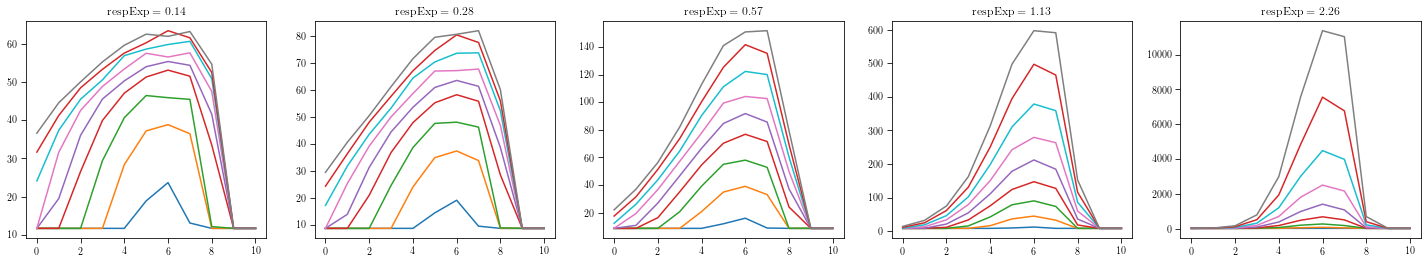

In [453]:
rE = np.geomspace(0.25, 4, 5) * pms[3]
nplt = len(rE);

f, ax = plt.subplots(nrows=1, ncols=nplt, figsize=(5*nplt,4));

for i, respExp in enumerate(rE):
    pms_copy = np.copy(pms);
    pms_copy[3] = respExp

    oy_mod = mrpt.sfNormMod(pms_copy, expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                              lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
    _, vExp_init, mod_resps_init = get_vExp_mod(expByCond, oy_mod, dw, expInd, returnAll=True)
    
    
    [ax[i].plot(hf.nan_rm(x)) for x in np.transpose(mod_resps_init[0])]
    ax[i].set_title('respExp = %.2f' % (respExp))


##### Sigma

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1893: RuntimeWarning: invalid value encountered in double_scalars
  resp_dist = lambda x, y: np.sum(np.square(x-y))/np.maximum(len(x), len(y))
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarn

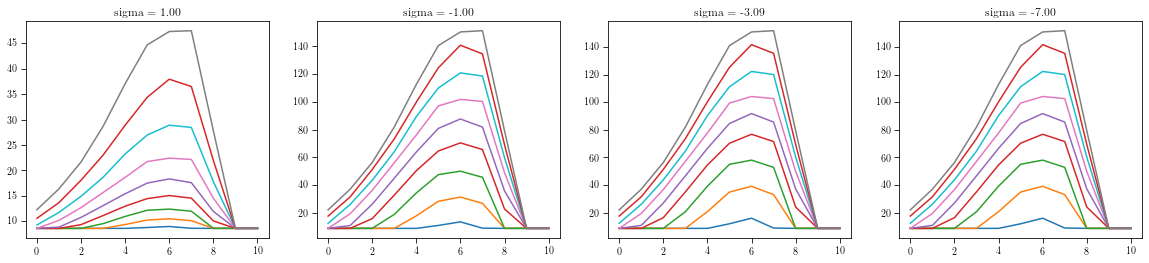

In [461]:
sigmas = [1, -1, pms[2], -7]
nplt = len(sigmas);

f, ax = plt.subplots(nrows=1, ncols=nplt, figsize=(5*nplt,4));

for i, sig in enumerate(sigmas):
    pms_copy = np.copy(pms);
    pms_copy[2] = sig

    oy_mod = mrpt.sfNormMod(pms_copy, expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                              lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
    _, vExp_init, mod_resps_init = get_vExp_mod(expByCond, oy_mod, dw, expInd, returnAll=True)
    
    
    [ax[i].plot(hf.nan_rm(x)) for x in np.transpose(mod_resps_init[0])]
    ax[i].set_title('sigma = %.2f' % (sig))


##### Resp scalar

In [463]:
pms[4]

-2.6554923057556152

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:4844: RuntimeWarning: invalid value encountered in multiply
  modRespOrg = np.nan * np.empty((nDisps, nSfs, nCons, nRepsMax));
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1893: RuntimeWarning: invalid value encountered in double_scalars
  resp_dist = lambda x, y: np.sum(np.square(x-y))/np.maximum(len(x), len(y))
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns

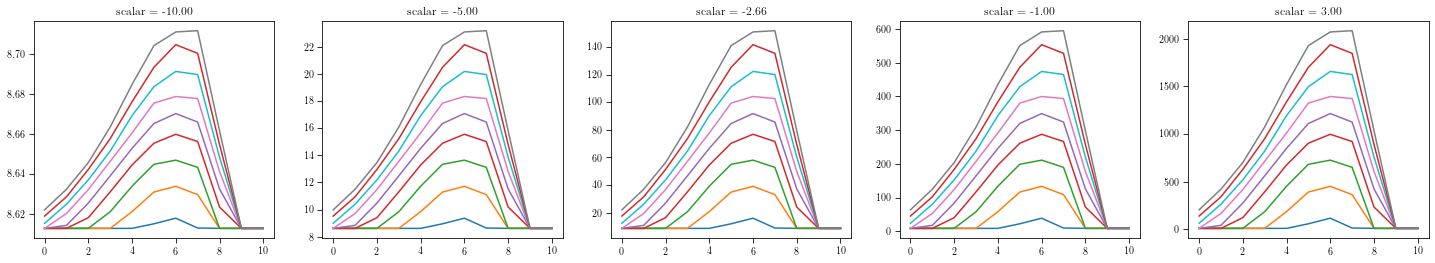

In [464]:
scalars = [-10, -5, pms[4], -1, 3]
nplt = len(scalars);

f, ax = plt.subplots(nrows=1, ncols=nplt, figsize=(5*nplt,4));

for i, scl in enumerate(scalars):
    pms_copy = np.copy(pms);
    pms_copy[4] = scl

    oy_mod = mrpt.sfNormMod(pms_copy, expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                              lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
    _, vExp_init, mod_resps_init = get_vExp_mod(expByCond, oy_mod, dw, expInd, returnAll=True)
    
    
    [ax[i].plot(hf.nan_rm(x)) for x in np.transpose(mod_resps_init[0])]
    ax[i].set_title('scalar = %.2f' % (scl))


##### Noise early

In [465]:
pms[5]

-0.09994937479496002

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1893: RuntimeWarning: invalid value encountered in double_scalars
  resp_dist = lambda x, y: np.sum(np.square(x-y))/np.maximum(len(x), len(y))
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarn

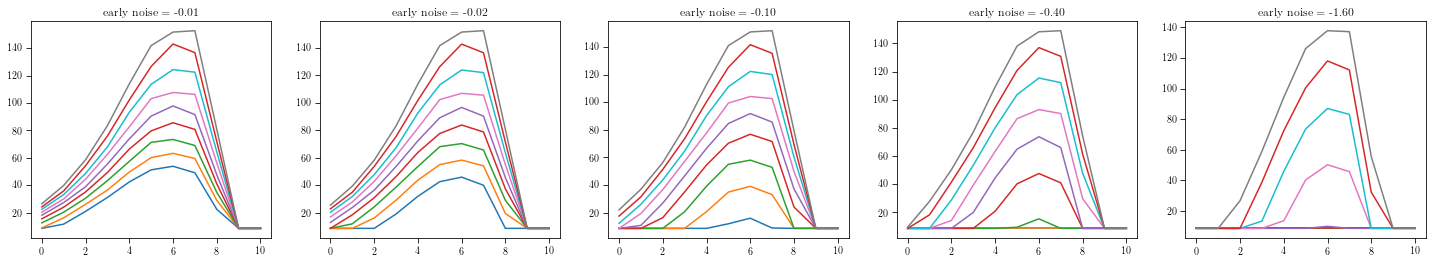

In [468]:
noise_e = np.geomspace(1/16, 16, 5) * pms[5]
nplt = len(noise_e);

f, ax = plt.subplots(nrows=1, ncols=nplt, figsize=(5*nplt,4));

for i, nse in enumerate(noise_e):
    pms_copy = np.copy(pms);
    pms_copy[5] = nse

    oy_mod = mrpt.sfNormMod(pms_copy, expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                              lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
    _, vExp_init, mod_resps_init = get_vExp_mod(expByCond, oy_mod, dw, expInd, returnAll=True)
    
    
    [ax[i].plot(hf.nan_rm(x)) for x in np.transpose(mod_resps_init[0])]
    ax[i].set_title('early noise = %.2f' % (nse))


##### Noise late

Serves as a response floor (i.e. baseline)

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1893: RuntimeWarning: invalid value encountered in double_scalars
  resp_dist = lambda x, y: np.sum(np.square(x-y))/np.maximum(len(x), len(y))
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarn

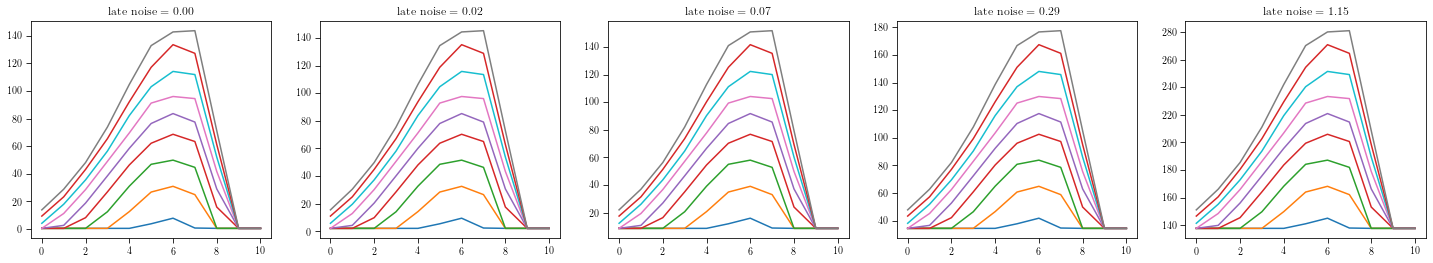

In [471]:
noise_l = np.geomspace(1/16, 16, 5) * pms[6]
nplt = len(noise_l);

f, ax = plt.subplots(nrows=1, ncols=nplt, figsize=(5*nplt,4));

for i, nsl in enumerate(noise_l):
    pms_copy = np.copy(pms);
    pms_copy[6] = nsl

    oy_mod = mrpt.sfNormMod(pms_copy, expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                              lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
    _, vExp_init, mod_resps_init = get_vExp_mod(expByCond, oy_mod, dw, expInd, returnAll=True)
    
    
    [ax[i].plot(hf.nan_rm(x)) for x in np.transpose(mod_resps_init[0])]
    ax[i].set_title('late noise = %.2f' % (nsl))


##### magno weight

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1893: RuntimeWarning: invalid value encountered in double_scalars
  resp_dist = lambda x, y: np.sum(np.square(x-y))/np.maximum(len(x), len(y))
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarn

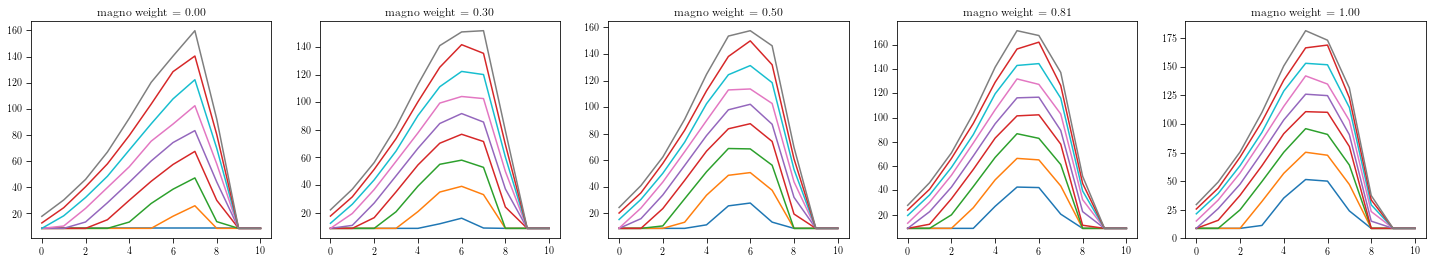

In [475]:
mWts = [-10, pms[-1], 0, -pms[1], 10]
nplt = len(mWts);

f, ax = plt.subplots(nrows=1, ncols=nplt, figsize=(5*nplt,4));

for i, mWt in enumerate(mWts):
    pms_copy = np.copy(pms);
    pms_copy[-1] = mWt

    oy_mod = mrpt.sfNormMod(pms_copy, expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                              lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
    _, vExp_init, mod_resps_init = get_vExp_mod(expByCond, oy_mod, dw, expInd, returnAll=True)
    
    
    [ax[i].plot(hf.nan_rm(x)) for x in np.transpose(mod_resps_init[0])]
    ax[i].set_title('magno weight = %.2f' % (hf.sigmoid(mWt)))


## 1.4 Do the optimization in scipy!

We've already made changes to the model in pytorch that would be time-consuming to replicate outside of pytorch. However, while we still workout the best set of hyperparameters, let's instead do the optimization in scipy.

All we have to is write a wrapper objection function that will just run the model in pytorch and then "detach" the results in numpy!


In [522]:
autoreload.reload(mrpt);

In [615]:
### Load the trialInf
data_loc = base_dir + '%sstructures/' % expDir
expName = hf.get_datalist(expDir, force_full=True);
dataList = hf.np_smart_load(str(data_loc + expName))
expInd   = hf.exp_name_to_ind(dataList['expType'][cellNum-1]);

expData = hf.np_smart_load(data_loc + '%s_sfm.npy' % dataList['unitName'][cellNum-1])
trialInf = expData['sfm']['exp']['trial']
dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd)

### Set up the model and the dataWrapper
init_prms = mrpt.setModel(4, expDir=expDir, excType=excType, lossType=lossType, fitType=fitType, 
                          lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm,
                          fixRespExp=fixRespExp, respMeasure=0, 
                          newMethod=1, vecCorrected=0, initFromCurr=0, returnOnlyInits=True)
    
def obj(prms, loss_type=1, dw=dw, respMeasure=0, _sigmoidSigma=5, lgnType=1,
        newMethod=1, vecCorrected=0, normType=1, excType=2, lgnCon=1, _applyLGNtoNorm=0, debug=False):
    
    # set up the model and process the data (incl. responses)
    mod = mrpt.sfNormMod(prms, expInd=expInd, excType=excType, normType=normType, lossType=lossType,  
                         newMethod=newMethod, lgnFrontEnd=lgnType, lgnConType=lgnCon, applyLGNtoNorm=_applyLGNtoNorm)
    trInfTemp, respData = mrpt.process_data(trialInf, expInd, respMeasure) # respOverwrite=respOverwrite
    # then get the model response
    modResp = mod.forward(trInfTemp, respMeasure=respMeasure, sigmoidSigma=_sigmoidSigma).detach().numpy()
    # compute the loss!
    ls =  mrpt.loss_sfNormMod(mrpt._cast_as_tensor(modResp.flatten()), mrpt._cast_as_tensor(respData.flatten()), lossType=loss_type).detach().numpy()
    
    if debug:
        return ls, modResp, respData
    else:
        return ls


FitList: fitList_pyt_221005_noRE_LGN_wght_sqrt.npy [expDir is altExp/]
loading data structure from /arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/altExp/structures/...
expInd is 2
respMeasure, vecCorrected: 0, 0

********MODEL PARAMETERS********
prefSf: 1.26
sigma l|r: -0.09|-0.97
mWeight: 0.35 (orig -0.62)
scalar|early|late: 0.586|-0.204|-0.370
norm. const.: -2.00
tuned norm mn|std: 1.02|1.98
No LGN for GC
********END OF MODEL PARAMETERS********



In [594]:
good_fit = hf.np_smart_load('altExp/structures/fitListHPC_pyt_221006f_noRE_LGN_flat_sqrt.npy')

In [613]:
good_fit[3]['dc']['NLL']

array(1.8122715, dtype=float32)

In [617]:
import scipy.optimize as opt

In [631]:
init_prms = mrpt.setModel(4, expDir=expDir, excType=excType, lossType=lossType, fitType=fitType, 
                          lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm,
                          fixRespExp=fixRespExp, respMeasure=0, 
                          newMethod=1, vecCorrected=0, initFromCurr=0, returnOnlyInits=True)

# init_prms = good_fit[3]['dc']['params'];

# Adjust as needed below (bounds are not right, ex. for prefSf now that it's a sigmoid...)
# all_bounds = hf.getConstraints(fitType, excType, fixRespExp=1);

to_opt = opt.minimize(obj, init_prms)


FitList: fitList_pyt_221005_noRE_LGN_wght_sqrt.npy [expDir is altExp/]
loading data structure from /arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/altExp/structures/...
expInd is 2
respMeasure, vecCorrected: 0, 0

********MODEL PARAMETERS********
prefSf: 0.65
sigma l|r: 0.08|0.22
mWeight: 0.58 (orig 0.34)
scalar|early|late: 0.011|-0.162|0.379
norm. const.: -2.00
tuned norm mn|std: 0.66|1.78
No LGN for GC
********END OF MODEL PARAMETERS********



In [633]:
ls, modresp, dataresp = obj(init_prms, debug=True)

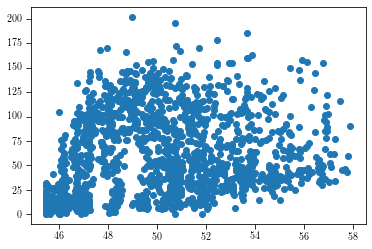

In [635]:
plt.scatter(modresp, dataresp)

### 1.5 Deconstructing the model response
Let's make sure our model is parameterized in the most efficient/effective way, such that the parameters are easy to intialize and understand!

In [2578]:
autoreload.reload(mrpt);

In [741]:
good_prms = good_fit[3]['dc']['params'];

normType=1
excType=2
lgnType=1
lgnCon=1
_applyLGNtoNorm=0
sigmoidSigma = 5
recenter_norm=True

mod = mrpt.sfNormMod(good_prms, expInd=expInd, excType=excType, normType=normType, lossType=lossType,  
                         newMethod=1, lgnFrontEnd=lgnType, lgnConType=lgnCon, applyLGNtoNorm=_applyLGNtoNorm)


trInf, respData = mrpt.process_data(trialInf, expInd, respMeasure=0) # warning: added respOverwrite here; also add whichTrials???   

exc,inh,sigmaFilt = mod.respPerCell(trInf, debug=1, sigmoidSigma=sigmoidSigma, recenter_norm=recenter_norm);
amps, psth_orig = mod.forward(trInf, returnPsth=True)

# detach everything...
exc = exc.detach().numpy();
inh = inh.detach().numpy();
sigmaFilt = sigmaFilt.detach().numpy();
amps = amps.detach().numpy();
psth = psth_orig.detach().numpy();

##### First, check that our non-pytorch FFT calculation returns what we expect
We'll comapre raw spike counts to the PSTH-derived DC

In [799]:
nTr = len(trialInf['spikeTimes'])
cust_spiketimes = np.array([trialInf['spikeTimes'][x] for x in range(nTr)]);
cust_counts = np.array([trialInf['spikeCount'][x] for x in range(nTr)])
cust_psth, cust_bins = hf.make_psth(cust_spiketimes, stimDur=1); 

power, rel_power, full_ft = hf.spike_fft(np.array(cust_psth), stimDur=1)
dcs = [x[0] for x in power];

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


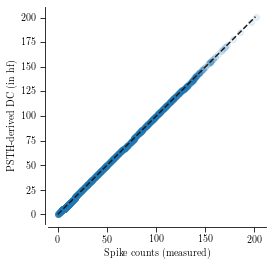

In [800]:
plt.scatter(cust_counts, dcs,alpha=0.1)
plt.axis('scaled');
plt.xlabel('Spike counts (measured)')
plt.ylabel('PSTH-derived DC (in hf)')
mx = np.nanmax(dcs);
plt.plot([0,mx],[0,mx], 'k--');
sns.despine(offset=3)

All good! Now, compare against the pytorch version:

##### Now, checking pytorch FFT calculation:

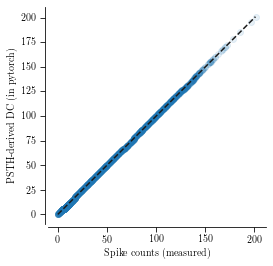

In [810]:
spectrum, rel_amp, full_fourier = mrpt.spike_fft(mrpt._cast_as_tensor([cust_psth]), stimDur=1)
specs = spectrum[0].detach().numpy();
pyt_dcs = np.array([x[0] for x in specs])

plt.scatter(cust_counts, pyt_dcs,alpha=0.1)
plt.axis('scaled');
plt.xlabel('Spike counts (measured)')
plt.ylabel('PSTH-derived DC (in pytorch)')
mx = np.nanmax(dcs);
plt.plot([0,mx],[0,mx], 'k--');
sns.despine(offset=3)

##### And now, look at some example model PSTHs

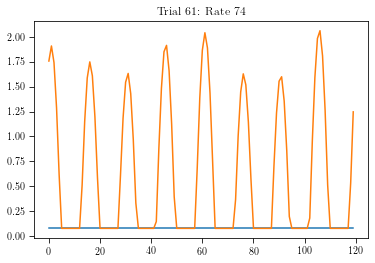

In [824]:
trInd = 5;
plt.plot(psth[trInd])
plt.title('Trial %d: Rate %d' % (trInd, amps[trInd]));

trInd = 61;
plt.plot(psth[trInd])
plt.title('Trial %d: Rate %d' % (trInd, amps[trInd]));

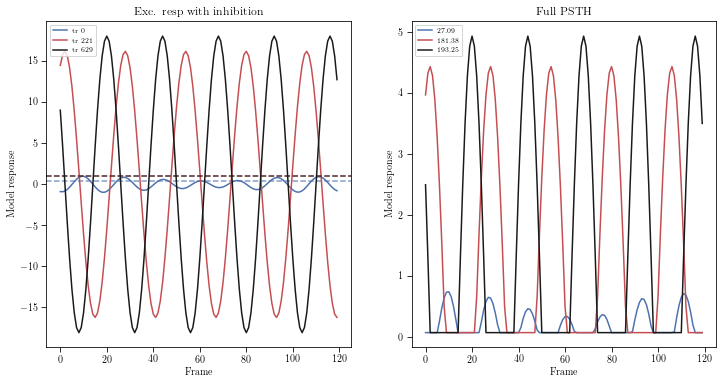

In [729]:
f, ax = plt.subplots(1,2,figsize=(12,6))

ri = np.random.randint(0, exc.shape[-1])
trs = [0, ri, oy];
clrs = ['b','r','k']

for tr,clr in zip(trs, clrs):
    # exc
    ax[0].plot(exc[:,tr], color=clr, label='tr %d' % tr)
    # inh
#     ax[0].plot(0, inh[tr], '>', color='k')
    ax[0].axhline(inh[tr], color=clr, linestyle='--', alpha=0.7)
    # full model
    ax[1].plot(psth[tr], color=clr, label='%.2f' % amps[tr])

ax[0].set_title('Exc. resp with inhibition')
ax[1].set_title('Full PSTH')
for i in range(2):
    # labels
    ax[i].legend(fontsize='x-small');
    ax[i].set_xlabel('Frame')
    ax[i].set_ylabel('Model response');


##### Interlude: Check the normalization weight calculation

In [1416]:
autoreload.reload(mrpt); autoreload.reload(hf);

In [1417]:
good_fit_wt = hf.np_smart_load('altExp/structures/fitListHPC_pyt_221007ff_noRE_noSched_LGN_wght_sqrt.npy')
good_prms_wt = good_fit_wt[3]['dc']['params'];

In [1434]:
cellNum = 40
expDir = 'V1/'
respMeasure = 0; # dc [0] or f1 [1]

excType = 2; # 1 is deriv. order, 2 is flex. gauss
lossType = 1
fitType = 1 # flat [1], tuned [2] or gain tuned[5]
lgnFrontOn = 1
lgnConType = 1
_LGNforNorm = 0

### Load data (to use for vExp calc.)
data_loc = base_dir + '%sstructures/' % expDir
expName = hf.get_datalist(expDir, force_full=True);
dataList = hf.np_smart_load(str(data_loc + expName))
expInd   = hf.exp_name_to_ind(dataList['expType'][cellNum-1]);

if respMeasure == 1:
    rvcName = 'rvcFitsHPC_220928'
    rvcFits = hf.get_rvc_fits(data_loc, expInd, cellNum, rvcName=rvcName, rvcMod=1, direc=1, vecF1=0);
    get_adj_spikes = hf.get_adjusted_spikerate(trialInf, cellNum, expInd, data_loc, rvcName=rvcFits, rvcMod=-1, 
                                               baseline_sub=False, return_measure=False, vecF1=0, force_f1=True, returnByComp=True)

expData = hf.np_smart_load(data_loc + '%s_sfm.npy' % dataList['unitName'][cellNum-1])
trialInf = expData['sfm']['exp']['trial']
respOverwrite = None if respMeasure==0 else get_adj_spikes;
dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd, respOverwrite=respOverwrite)

spikes_rate = hf.get_adjusted_spikerate(expData['sfm']['exp']['trial'], cellNum, expInd, data_loc, rvcName=rvcName, rvcMod=1, force_dc=True if respMeasure==0 else False, baseline_sub=False)
_, _, expByCond, _ = hf.organize_resp(spikes_rate, trialInf, expInd, respsAsRate=False);

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  spike_times = np.array([trial_inf['spikeTimes'][x] for x in all_trs]);


In [1456]:
normType = 1; # flat
# normType = 2; # weight
# normType = 5; # weighted gain

# prms_use_orig = np.copy(prms_use);
# prms_use = good_prms if normType==1 else good_prms_wt;

init_prms = mrpt.setModel(cellNum, expDir=expDir, excType=excType, lossType=lossType, fitType=normType, 
                          lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm,
                          fixRespExp=fixRespExp, respMeasure=respMeasure, normToOne=True,
                          newMethod=1, vecCorrected=0, initFromCurr=0, returnOnlyInits=True)

prms_use = init_prms
# prms_use = prms_use_orig;
# prms_use[5] = 0.01
# prms_use[-3] = 0.4; # larger sigma?

init_mod = mrpt.sfNormMod(prms_use, expInd=expInd, excType=excType, normType=normType, lossType=lossType,  
                         newMethod=1, lgnFrontEnd=lgnType, lgnConType=lgnCon, applyLGNtoNorm=_applyLGNtoNorm,normToOne=True)


# amps, psth_orig = mod.forward(trInf, returnPsth=True)

_, vExp_init, mod_resps_init = get_vExp_mod(expByCond, init_mod, dw, expInd, respMeasure=respMeasure, returnAll=True)



FitList: fitList_pyt_221010ff_noRE_LGN_flat_sqrt.npy [expDir is V1/]
loading data structure from /arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/V1/structures/...
expInd is 5
respMeasure, vecCorrected: 0, 0


/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);


prefSf: 2.46

********MODEL PARAMETERS********
prefSf: 2.72
sigma l|r: -0.64|-0.00
mWeight: 0.41 (orig -0.35)
scalar|early|late: 204.863|-0.026|8.276
norm. const.: -1.00
No LGN for GC
********END OF MODEL PARAMETERS********



/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1893: RuntimeWarning: invalid value encountered in double_scalars
  resp_dist = lambda x, y: np.sum(np.square(x-y))/np.maximum(len(x), len(y))


##### Plot initial fit:

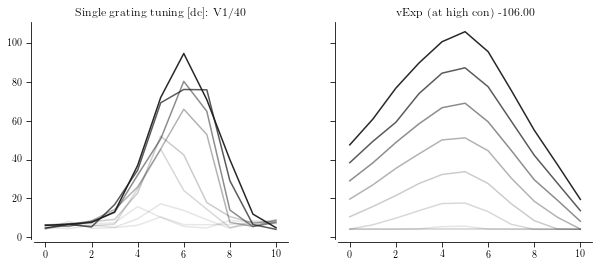

In [1457]:
f, ax = plt.subplots(1,2,figsize=(10,4), sharey=True, sharex=True)

# data
[ax[0].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(expByCond[0]))]
ax[0].set_title('Single grating tuning [%s]: %s/%02d' % ('dc' if respMeasure==0 else 'f1', expDir.replace('/', '').replace('_', ''), cellNum));

# model
[ax[1].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(mod_resps_init[0]))]
ax[1].set_title('vExp (at high con) %.2f' % vExp_init[0,-1]);

sns.despine(offset=3)

##### Explore changes in early noise:

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1893: RuntimeWarning: invalid value encountered in double_scalars
  resp_dist = lambda x, y: np.sum(np.square(x-y))/np.maximum(len(x), len(y))


KeyboardInterrupt: 

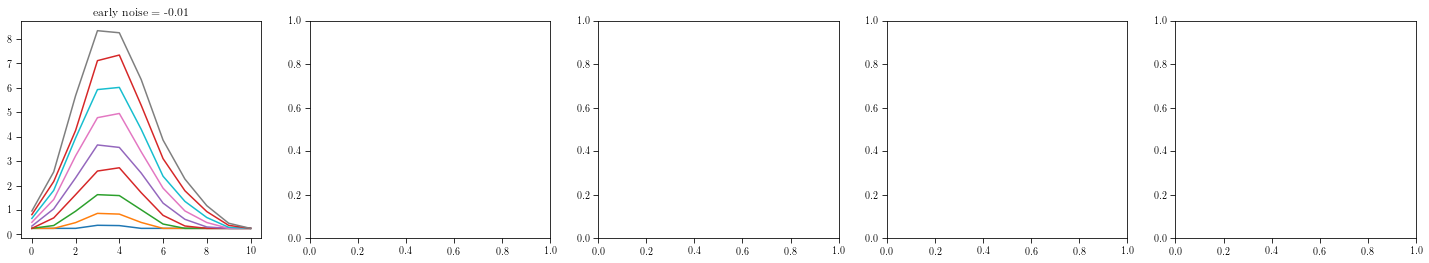

In [1308]:
noise_e = np.geomspace(1/16, 16, 5) * pms[5]
nplt = len(noise_e);

f, ax = plt.subplots(nrows=1, ncols=nplt, figsize=(5*nplt,4));

for i, nse in enumerate(noise_e):
    pms_copy = np.copy(init_prms);
    pms_copy[5] = nse

    oy_mod = mrpt.sfNormMod(pms_copy, expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                              lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
    _, vExp_init, mod_resps_init = get_vExp_mod(expByCond, oy_mod, dw, expInd, returnAll=True)
    
    
    [ax[i].plot(hf.nan_rm(x)) for x in np.transpose(mod_resps_init[0])]
    ax[i].set_title('early noise = %.2f' % (nse))


##### Explore changes in sigma:

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1893: RuntimeWarning: invalid value encountered in double_scalars
  resp_dist = lambda x, y: np.sum(np.square(x-y))/np.maximum(len(x), len(y))
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarn

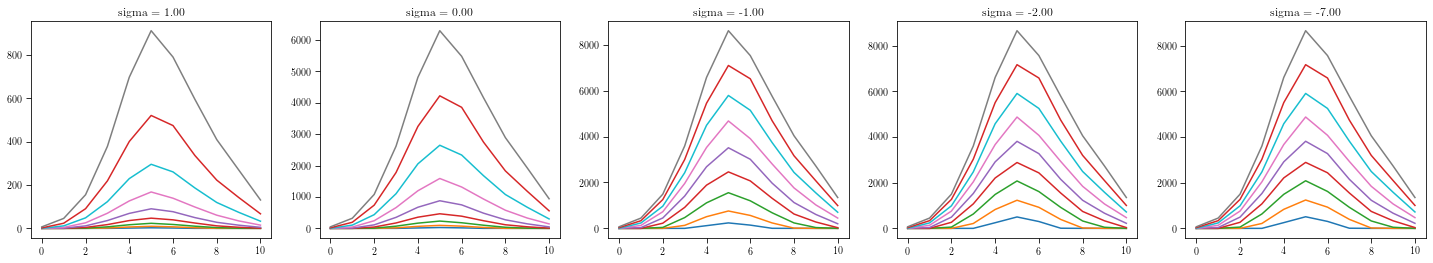

In [988]:
sigmas = [1, 0, -1, init_prms[2], -7]
nplt = len(sigmas);

f, ax = plt.subplots(nrows=1, ncols=nplt, figsize=(5*nplt,4));

for i, sig in enumerate(sigmas):
    pms_copy = np.copy(init_prms);
    pms_copy[2] = sig

    oy_mod = mrpt.sfNormMod(pms_copy, expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                              lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
    _, vExp_init, mod_resps_init = get_vExp_mod(expByCond, oy_mod, dw, expInd, returnAll=True)
    
    
    [ax[i].plot(hf.nan_rm(x)) for x in np.transpose(mod_resps_init[0])]
    ax[i].set_title('sigma = %.2f' % (sig))


In [ ]:
verb = False # verbose?

batch_size = [128, 256, 1024] # 1024 will cover full stimulus set for most cells (all 2s presentations)
# learning_rate = np.geomspace(0.05, 0.5, 4) # bad?
learning_rate = np.geomspace(0.01, 0.15, 4) # good?
epochs = [50, 200, 500]
scheduler = [0,1]; # off [0] vs. on [1] --> currently, patience is max(8, epochs/10) and factor=0.1

param_grid = {'batch_size': batch_size, 'lr': learning_rate, 'epochs': epochs, 'scheduler': scheduler}
pg = ParameterGrid(param_grid)

pg_loss = np.nan * np.zeros((len(pg), 3)); # [0,1,2] will be loss,vExp, and duration of run!

for i,curr_hyper in enumerate(pg):
    if np.mod(i,int(len(pg)/10))==0:
        print('hyper. set %d of %d' % (i, len(pg)));
        
    fit, details = mrpt.setModel(cellNum, expDir, excType, lossType, fitType, lgnFrontOn, 
                                 lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, trackSteps=1, 
                                 learning_rate=curr_hyper['lr'], batch_size=curr_hyper['batch_size'], 
                                 max_epochs = curr_hyper['epochs'], scheduler=curr_hyper['scheduler'], 
                                 respMeasure=respMeasure, newMethod=1, vecCorrected=0, to_save=False, verbose=verb)
    try:
        pg_loss[i,0] = fit['NLL'];
        # INITIAL
        init_mod = mrpt.sfNormMod(fit['opt']['init_params'], expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                          lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
        _, vExp_init, mod_resps_init = get_vExp_mod(expByCond, init_mod, dw, expInd, returnAll=True)

        # CURRENT/FINAL
        curr_prms = fit['params']
        curr_mod = mrpt.sfNormMod(curr_prms, expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                          lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
        _, vExp_all, mod_resps_out = get_vExp_mod(expByCond, curr_mod, dw, expInd, returnAll=True)
        print('vExp: %.2f (was %.2f)' % (vExp_all[0,-1], vExp_init[0,-1])) # high con..
        pg_loss[i,1] = vExp_all[0,-1]
        print(hf.nan_rm(mod_resps_out[0,:,-1]))
        print('Final ^^^....vvv initial\n')
        print(hf.nan_rm(mod_resps_init[0,:,-1]))
        
        pg_loss[i,2] = details['time'][-1][-1] # end time of last epoch!
    except:
        pass

# 2. Exploring flat gain control:
Why is this model still giving frequency specific suppression, per mixture suppression plots? We also explore some other oddities that appear when analyzing responses (e.g. why not perfectly parallel RVCs with no tuned gain control?)

Load the data and a flat gain control model fit:

In [1486]:
expData['unitLabel']

'm670l38'

In [1516]:
cellNum = 4
expDir = 'altExp/'
respMeasure = 0; # dc [0] or f1 [1]

excType = 2; # 1 is deriv. order, 2 is flex. gauss
lossType = 1
fitType = 1 # flat [1], tuned [2] or gain tuned[5]
lgnFrontOn = 0
lgnConType = 1
_LGNforNorm = 0
normToOne = True;
recenter_norm = 2;
_sigmoidSigma = 5;

### Load data (to use for vExp calc.)
data_loc = base_dir + '%sstructures/' % expDir
expName = hf.get_datalist(expDir, force_full=True);
dataList = hf.np_smart_load(str(data_loc + expName))
expInd   = hf.exp_name_to_ind(dataList['expType'][cellNum-1]);

if respMeasure == 1:
    rvcName = 'rvcFitsHPC_220928'
    rvcFits = hf.get_rvc_fits(data_loc, expInd, cellNum, rvcName=rvcName, rvcMod=1, direc=1, vecF1=0);
    get_adj_spikes = hf.get_adjusted_spikerate(trialInf, cellNum, expInd, data_loc, rvcName=rvcFits, rvcMod=-1, 
                                               baseline_sub=False, return_measure=False, vecF1=0, force_f1=True, returnByComp=True)

expData = hf.np_smart_load(data_loc + '%s_sfm.npy' % dataList['unitName'][cellNum-1])
trialInf = expData['sfm']['exp']['trial']
respOverwrite = None if respMeasure==0 else get_adj_spikes;
dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd, respOverwrite=respOverwrite)

In [1525]:
good_fit = hf.np_smart_load('%sstructures/fitListHPC_pyt_221013_noRE_noSched_flat_sqrt.npy' % expDir)
respStr = 'dc' if respMeasure == 0 else 'f1'
mod_prms = good_fit[cellNum-1][respStr]['params']

In [1589]:
# get the stimVals
_, stimVals, val_con_by_disp, val_by_stim_val, _ = hf.tabulate_responses(expData, expInd);
disps,cons,sfs = stimVals;

Now, get the model response:

In [1526]:
def gather_into_full_resp(dw, trialInf, expInd, mod_resps):
    
    stimDur = hf.get_exp_params(expInd).stimDur;
    divFactor = stimDur if respMeasure == 0 else 1;
    nTrialsFull = len(trialInf['num']);
    mod_resps_all = np.nan * np.zeros((nTrialsFull, ));
    if respMeasure == 1:
        blanks = np.where(dw.trInf['con'].detach().numpy()==0);
        mod_resps[blanks] = 1e-6;
        mod_resps = np.sum(mod_resps, axis=1);
    mod_resps_all[dw.trInf['num']] = mod_resps;
    _, _, modByCond, _ = hf.organize_resp(np.divide(mod_resps_all, divFactor), trialInf, expInd, respsAsRate=True);
    
    return modByCond;

In [1148]:
autoreload.reload(mrpt);
autoreload.reload(hf);
autoreload.reload(psf);

In [2015]:
model = mrpt.sfNormMod(mod_prms, expInd=expInd, excType=excType, normType=fitType, 
                       lossType=lossType, lgnFrontEnd=lgnFrontOn, newMethod=1, 
                       lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, normToOne=normToOne)

modResp = model.forward(dw.trInf, respMeasure=respMeasure, sigmoidSigma=_sigmoidSigma, recenter_norm=recenter_norm).detach().numpy();
oy = gather_into_full_resp(dw, trialInf, expInd, modResp);

resps = psf.get_model_responses(trialInf, good_fit, expInd, cellNum, excType, fitType, f1f0_rat=None, respMeasure=respMeasure,
                                baseline=None, lossType=lossType, lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType)

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5146: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);


In [2016]:
measured, _, pred, _ = resps

mx = np.maximum(np.nanmax(measured), np.nanmax(pred));

In [1717]:
# ORIGINAL: i.e. normal TF, normal PH

(-13.13400013446808,
 275.81400282382964,
 -13.13400013446808,
 275.81400282382964)

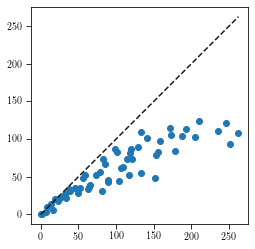

In [1711]:
plt.scatter(pred[1:-1,:,:], measured[1:-1,:,:])
plt.plot([0,mx],[0,mx],'k--')
plt.axis('scaled')

In [1719]:
# Common Ph for all

(-11.936834354400636,
 250.67352144241335,
 -11.936834354400636,
 250.67352144241335)

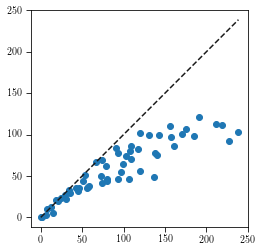

In [1724]:
plt.scatter(pred[1:-1,:,:], measured[1:-1,:,:])
plt.plot([0,mx],[0,mx],'k--')
plt.axis('scaled')

In [1726]:
# Common Tf (5) and Ph for all

(-9.096330471038817,
 191.02293989181516,
 -9.096330471038817,
 191.02293989181516)

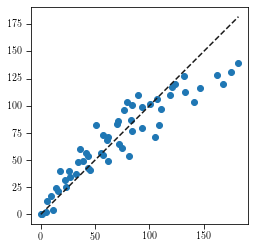

In [1730]:
plt.scatter(pred[1:-1,:,:], measured[1:-1,:,:])
plt.plot([0,mx],[0,mx],'k--')
plt.axis('scaled')

To examine if it's valid (and if so, why) that the flat gain control model still gives freq-dep. suppression, let's consider two stimuli with that have the same prediction but different mixture responses!

In [2012]:
# Original, but 100s?

This doesn't seem to matter? i.e. even if we average over more time, it doesn't matter --> still noisy

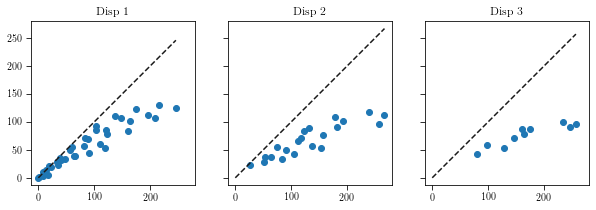

In [2017]:
f, ax = plt.subplots(1, 3, figsize=(10,4), sharex=True, sharey=True);

measured, _, pred, _ = resps

for i in range(3):
    meas = measured[i+1];
    pre = pred[i+1];
    mx = np.maximum(np.nanmax(meas), np.nanmax(pre));
    
    ax[i].scatter(pre, meas)
    ax[i].plot([0, mx], [0, mx], 'k--')
    ax[i].axis('scaled');
    ax[i].set_title('Disp %d' % (i+1))

In [1716]:
# ORIGINAL: i.e. normal TF, normal PH

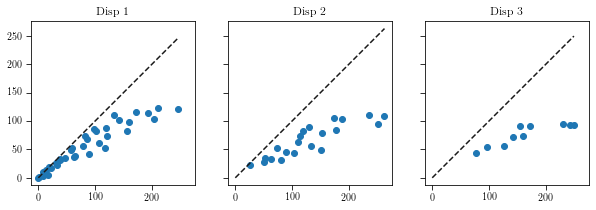

In [1713]:
f, ax = plt.subplots(1, 3, figsize=(10,4), sharex=True, sharey=True);

measured, _, pred, _ = resps

for i in range(3):
    meas = measured[i+1];
    pre = pred[i+1];
    mx = np.maximum(np.nanmax(meas), np.nanmax(pre));
    
    ax[i].scatter(pre, meas)
    ax[i].plot([0, mx], [0, mx], 'k--')
    ax[i].axis('scaled');
    ax[i].set_title('Disp %d' % (i+1))

In [1718]:
# Common Ph for all

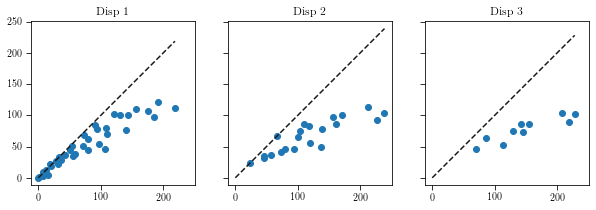

In [1725]:
f, ax = plt.subplots(1, 3, figsize=(10,4), sharex=True, sharey=True);

measured, _, pred, _ = resps

for i in range(3):
    meas = measured[i+1];
    pre = pred[i+1];
    mx = np.maximum(np.nanmax(meas), np.nanmax(pre));
    
    ax[i].scatter(pre, meas)
    ax[i].plot([0, mx], [0, mx], 'k--')
    ax[i].axis('scaled');
    ax[i].set_title('Disp %d' % (i+1))

In [1731]:
# Common Tf (5) and Ph for all

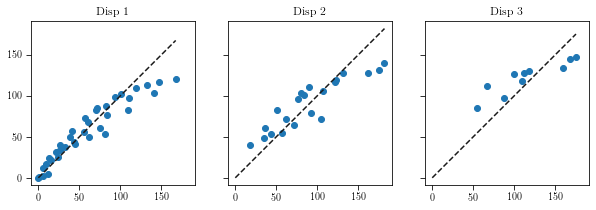

In [1732]:
f, ax = plt.subplots(1, 3, figsize=(10,4), sharex=True, sharey=True);

measured, _, pred, _ = resps

for i in range(3):
    meas = measured[i+1];
    pre = pred[i+1];
    mx = np.maximum(np.nanmax(meas), np.nanmax(pre));
    
    ax[i].scatter(pre, meas)
    ax[i].plot([0, mx], [0, mx], 'k--')
    ax[i].axis('scaled');
    ax[i].set_title('Disp %d' % (i+1))

In [1753]:
# SAME AS ABOVE, but different phase value...

f, ax = plt.subplots(1, 3, figsize=(10,4), sharex=True, sharey=True);

measured, _, pred, _ = resps

for i in range(3):
    meas = measured[i+1];
    pre = pred[i+1];
    mx = np.maximum(np.nanmax(meas), np.nanmax(pre));
    
    ax[i].scatter(pre, meas)
    ax[i].plot([0, mx], [0, mx], 'k--')
    ax[i].axis('scaled');
    ax[i].set_title('Disp %d' % (i+1))

In [1757]:
# Common Tf (5) but original Ph

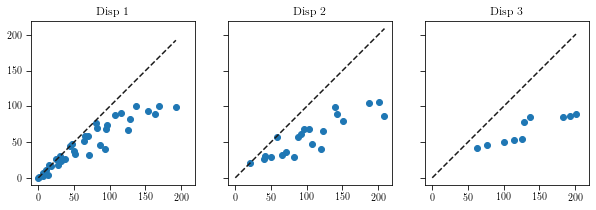

In [1758]:
# SAME AS ABOVE, but different phase value...

f, ax = plt.subplots(1, 3, figsize=(10,4), sharex=True, sharey=True);

measured, _, pred, _ = resps

for i in range(3):
    meas = measured[i+1];
    pre = pred[i+1];
    mx = np.maximum(np.nanmax(meas), np.nanmax(pre));
    
    ax[i].scatter(pre, meas)
    ax[i].plot([0, mx], [0, mx], 'k--')
    ax[i].axis('scaled');
    ax[i].set_title('Disp %d' % (i+1))

In [1687]:
measured[3,:,val_con_by_disp[3][-1]]

array([         nan,          nan,          nan,  97.24065495,
       126.61146336, 144.6160181 , 147.12386265, 133.5189188 ,
                nan,          nan,          nan])

In [1688]:
pred[3,:,val_con_by_disp[3][-1]]

array([         nan,          nan,          nan,  86.96677341,
        99.57173319, 167.59764042, 175.2725337 , 159.62568941,
                nan,          nan,          nan])

So, for example: the highest contrast, highest dispersion, the highest three contrasts have predictions and measurements that don't quite make sense.

Specifically, the prediction with the lowest of those three has the highest measured/mixture response!


In [1733]:
Lexc,Linh,sigmaFilt = psf.get_model_responses(trialInf, good_fit, expInd, cellNum, excType, fitType, f1f0_rat=None, 
                                respMeasure=respMeasure, debug=True,
                                baseline=None, lossType=lossType, lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType)

Lexc = Lexc.detach().numpy();
Linh = Linh.detach().numpy();
sigmaFilt = sigmaFilt.detach().numpy();

The above, however, are in organized in trimmed trials, i.e. excluding blanks. So, let's find the right trial number:

In [1690]:
# vt_0 is a reference (single gratings)
ref_con = val_con_by_disp[0][-1];
disp_lvl = 3;
disp_con = val_con_by_disp[disp_lvl][-1]
vt_0 = hf.get_valid_trials(trialInf, 0, ref_con, 5, expInd, stimVals=stimVals, validByStimVal=val_by_stim_val)[0]
vt_1 = hf.get_valid_trials(trialInf, disp_lvl, disp_con, 5, expInd, stimVals=stimVals, validByStimVal=val_by_stim_val)[0]
vt_2 = hf.get_valid_trials(trialInf, disp_lvl, disp_con, 6, expInd, stimVals=stimVals, validByStimVal=val_by_stim_val)[0]
vt_3 = hf.get_valid_trials(trialInf, disp_lvl, disp_con, 7, expInd, stimVals=stimVals, validByStimVal=val_by_stim_val)[0]

# Get them in the correct trials for what we ran the model on
vt_0_adj = np.where(np.in1d(dw.trInf['num'], vt_0))[0]
vt_1_adj = np.where(np.in1d(dw.trInf['num'], vt_1))[0]
vt_2_adj = np.where(np.in1d(dw.trInf['num'], vt_2))[0]
vt_3_adj = np.where(np.in1d(dw.trInf['num'], vt_3))[0]


First, make sure the stimuli make sense (starting with the reference):

In [1692]:
dw.trInf['con'][vt_0_adj]

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])

Ok, phase varies - that's fine

In [1629]:
dw.trInf['ph'][vt_0_adj,0]

tensor([283.8580, 286.7200, 169.0660, 300.0140, 198.9760, 227.4150, 101.1800,
        272.8330, 139.8800, 223.5150])

In [1633]:
dw.trInf['sf'][vt_0_adj,0]

tensor([1.7321, 1.7321, 1.7321, 1.7321, 1.7321, 1.7321, 1.7321, 1.7321, 1.7321,
        1.7321])

In [1634]:
dw.trInf.keys()

dict_keys(['num', 'ori', 'tf', 'ph', 'sf', 'con'])

Ah! The temporal frequencies are different, since this was an experiment which did not keep a fixed relationship between unique component and temporal frequency!

In [1636]:
dw.trInf['tf'][vt_0_adj,0]

tensor([9.2311, 6.6669, 6.3160, 6.3160, 6.6669, 7.5003, 8.0003, 5.4548, 6.6669,
        6.3160])

Nonetheless, look at some example PSTHs:

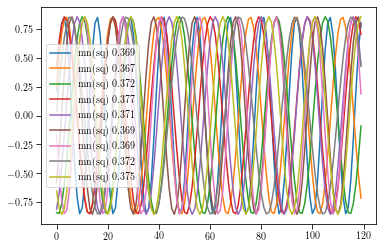

In [2755]:
[plt.plot(Lexc[:,vt], label='mn(sq) %.3f' % np.mean(np.square(Lexc[:,vt]))) for vt in vt_0_adj[0:2]];
plt.legend();

Now, what about the dispersed gratings?

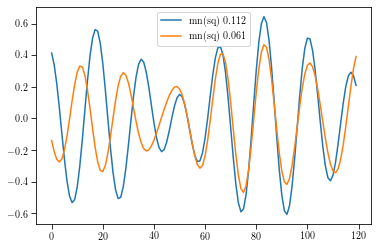

In [2757]:
[plt.plot(Lexc[:,vt], label='mn(sq) %.3f' % np.mean(np.square(Lexc[:,vt]))) for vt in vt_1_adj[0:2]]
plt.legend();

As above, but _different_, common phase!

In [2760]:
[np.unique(Linh[x]) for x in [vt_0_adj, vt_1_adj, vt_2_adj, vt_3_adj]]

[array([1.], dtype=float32),
 array([0.43124738], dtype=float32),
 array([0.43124738], dtype=float32),
 array([0.43124738], dtype=float32)]

### 2. 1 Closer look at the stimulus?

In [1992]:
autoreload.reload(mrpt);

In [1993]:
model = mrpt.sfNormMod(mod_prms, expInd=expInd, excType=excType, normType=fitType, 
                       lossType=lossType, lgnFrontEnd=lgnFrontOn, newMethod=1, 
                       lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, normToOne=normToOne)

In [1994]:
# P is the matrix that contains the relative location of each filter in space-time (expressed in radians) 
# Omega is the stimulus in space time
# dotprod is the dotproduct of P with Omega

# P is     nTr x nFrames x nComp x {x,y,t}
# ---- but note: P[...,0] and P[...,1] are always zero (x=0,y=0, i.e. centered)
# Omega is mTr x nComp x {x,y,t} (we drift the filters, rather than the stimuli???)

In [1995]:
P, omegas, dotprod, selSi, selSi_stimCo = model.simpleResp_matMul(dw.trInf, sigmoidSigma=sigmoidSigma, debug=True);

realPart = torch.cos(dotprod);
imagPart = torch.sin(dotprod);
# per LCV code: preallocation and then filling in is much more efficient than using stack                                                                                        
realImag = torch.empty((*realPart.shape,2), device=realPart.device);
realImag[...,0] = realPart;
realImag[...,1] = imagPart;

rComplex = torch.einsum('ij,ikjz->ikz', selSi_stimCo, realImag)
rDumb = torch.einsum('ij,ikjz->ijkz', selSi_stimCo, realImag)

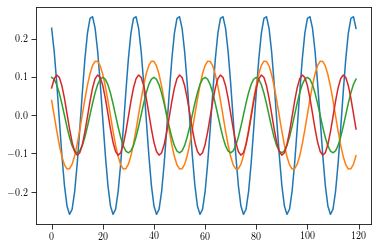

In [1996]:
# Component per response!
plt.plot(rDumb[vt_1_adj[0], 0, :, 0].detach())
plt.plot(rDumb[vt_1_adj[0], 1, :, 0].detach())
plt.plot(rDumb[vt_1_adj[0], 2, :, 0].detach())
plt.plot(rDumb[vt_1_adj[0], 3, :, 0].detach())

For a single gratings, here is the stimlus drifting in time

In [1905]:
import torch
oyvey = torch.cos(dotprod)
print(oyvey.shape)

torch.Size([1660, 120, 7])


In [1892]:
# aaa = torch.mean(torch.pow(torch.sum(oyvey[vt_1_adj[0]], axis=1), 2))
# aa = torch.mean(torch.pow(torch.sum(oyvey[vt_1_adj[1]], axis=1), 2))
# a = torch.mean(torch.pow(torch.sum(oyvey[vt_1_adj[5]], axis=1), 2))


In [1931]:
selSi.shape

torch.Size([1660, 7])

In [1932]:
selSi_stimCo.shape

torch.Size([1660, 7])

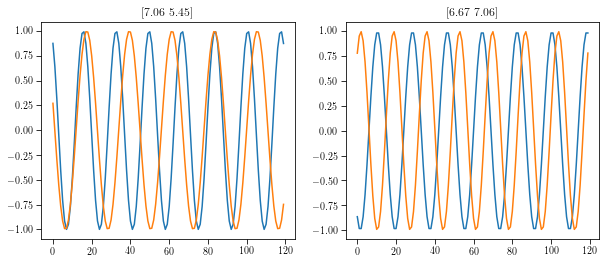

In [1930]:
f, ax = plt.subplots(1,2, figsize=(10,4));
ax[0].plot(oyvey[vt_1_adj[0],:,0])
ax[0].plot(oyvey[vt_1_adj[0],:,1])
ax[0].set_title('%s' % np.array2string(dw.trInf['tf'][vt_1_adj[0],0:2].detach().numpy(), precision=2));


ax[1].plot(oyvey[vt_1_adj[1],:,0])
ax[1].plot(oyvey[vt_1_adj[1],:,1])
ax[1].set_title('%s' % np.array2string(dw.trInf['tf'][vt_1_adj[1],0:2].detach().numpy(), precision=2));


In [1912]:
aaa = torch.mean(torch.pow(torch.sum(oyvey[vt_1_adj[0],:,0:2], axis=1), 2))
aa = torch.mean(torch.pow(torch.sum(oyvey[vt_1_adj[1],:,0:2], axis=1), 2))
a = torch.mean(torch.pow(torch.sum(oyvey[vt_1_adj[5],:,0:2], axis=1), 2))


In [1913]:
print([a,aa,aaa])

[tensor(1.0000), tensor(0.6319), tensor(1.0688)]


In [1874]:
plt.plot(torch.sum(oyvey[vt_1_adj[0], 0:480], axis=1))
plt.plot(torch.sum(oyvey[vt_1_adj[0], 480:960], axis=1))
# plt.plot(torch.sum(oyvey[vt_1_adj[2], :], axis=1))
# plt.plot(torch.sum(oyvey[vt_1_adj[3], :], axis=1))

In [1858]:
plt.plot(torch.sum(oyvey[vt_1_adj[0], :], axis=1))
plt.plot(torch.sum(oyvey[vt_1_adj[1], :], axis=1))
# plt.plot(torch.sum(oyvey[vt_1_adj[2], :], axis=1))
# plt.plot(torch.sum(oyvey[vt_1_adj[3], :], axis=1))

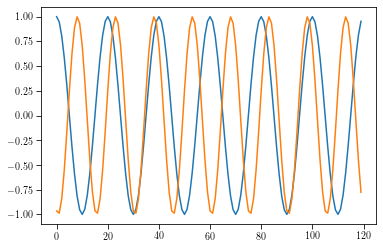

In [1845]:
np.sum
plt.plot(oyvey[vt_1_adj[0], :, 0])
plt.plot(oyvey[vt_1_adj[0], :, 5])

### 2.2 Now, try for an experiment which we know was designed properly!
Recall that the altExp/ stimuli had TFs drawn from a Gaussian - thus, each draw of a stimulus did not necessarily have the same TFs for each component.

However, all subsequent version of the experiment (i.e. V1/, V1_BB/) made each SF linked with a TF, i.e. any presentation of SF_i had TF_i.

In [2773]:
autoreload.reload(mrpt);
autoreload.reload(hf);
autoreload.reload(psf);

In [2769]:
fitList_nm = 'fitList_pyt_221013_noRE_noSched_flat_sqrt.npy'

In [ ]:
trial

In [2770]:
cellNum = 40
expDir = 'V1/'
respMeasure = 0; # dc [0] or f1 [1]

excType = 2; # 1 is deriv. order, 2 is flex. gauss
lossType = 1
fitType = 1 # flat [1], tuned [2] or gain tuned[5]
lgnFrontOn = 0
lgnConType = 1
_LGNforNorm = 0
normToOne = True;
recenter_norm = 2;
_sigmoidSigma = 5;

### Load data (to use for vExp calc.)
data_loc = base_dir + '%sstructures/' % expDir
expName = hf.get_datalist(expDir, force_full=True);
dataList = hf.np_smart_load(str(data_loc + expName))
expInd   = hf.exp_name_to_ind(dataList['expType'][cellNum-1]);

if respMeasure == 1:
    rvcName = 'rvcFitsHPC_220928'
    rvcFits = hf.get_rvc_fits(data_loc, expInd, cellNum, rvcName=rvcName, rvcMod=1, direc=1, vecF1=0);
    get_adj_spikes = hf.get_adjusted_spikerate(trialInf, cellNum, expInd, data_loc, rvcName=rvcFits, rvcMod=-1, 
                                               baseline_sub=False, return_measure=False, vecF1=0, force_f1=True, returnByComp=True)

expData = hf.np_smart_load(data_loc + '%s_sfm.npy' % dataList['unitName'][cellNum-1])
trialInf = expData['sfm']['exp']['trial']
respOverwrite = None if respMeasure==0 else get_adj_spikes;
dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd, 
                      respOverwrite=respOverwrite)#, shufflePh=True, shuffleTf=True)

In [2771]:
good_fit = hf.np_smart_load('%sstructures/%s' % (expDir, fitList_nm))
respStr = 'dc' if respMeasure == 0 else 'f1'
mod_prms = good_fit[cellNum-1][respStr]['params']

In [2890]:
model = mrpt.sfNormMod(mod_prms, expInd=expInd, excType=excType, normType=fitType, 
                       lossType=lossType, lgnFrontEnd=lgnFrontOn, newMethod=1, 
                       lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, normToOne=normToOne)

modResp = model.forward(dw.trInf, respMeasure=respMeasure, sigmoidSigma=_sigmoidSigma, recenter_norm=recenter_norm).detach().numpy();
oy = gather_into_full_resp(dw, trialInf, expInd, modResp);



resps = psf.get_model_responses(trialInf, mod_prms, expInd, cellNum, excType, fitType, f1f0_rat=None, 
                                respMeasure=respMeasure,
                                baseline=None, lossType=lossType, lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType)
# Used for superposition analysis!
measured, _, pred, _ = resps

We'll use this to compare the response of a given component (from rComponent) to the overall response (rComplex).

Note that the below (rComplex, rComponent) are _just_ the linear filter, i.e. no normalization, no thresholding.



In [2880]:
realImag, selSi, selSi_stimCo = model.simpleResp_matMul(dw.trInf, sigmoidSigma=sigmoidSigma, debug=True);
# P, omegas, dotprod, selSi, selSi_stimCo = model.simpleResp_matMul(dw.trInf, sigmoidSigma=sigmoidSigma, debug=True);

rComplex = torch.einsum('ij,ikjz->ikz', selSi_stimCo, realImag).detach().numpy()
rComponent = torch.einsum('ij,ikjz->ijkz', selSi_stimCo, realImag).detach().numpy()

In [2881]:
# First, note that rComplex is simply the sum of rComponent (up to 1e-6):
np.unique(np.isclose(rComplex, np.sum(rComponent,axis=1), atol=1e-6))

array([ True])

Let's look at an arbitrary 3-mixture:

In [2882]:
to_match = 3; # i.e. how many components in mixture

nGrats = np.array([np.sum(dw.trInf['con'][x].detach().numpy()>0) for x in range(len(dw.trInf['con']))])
trs = np.where(nGrats==to_match)[0];

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  import sys


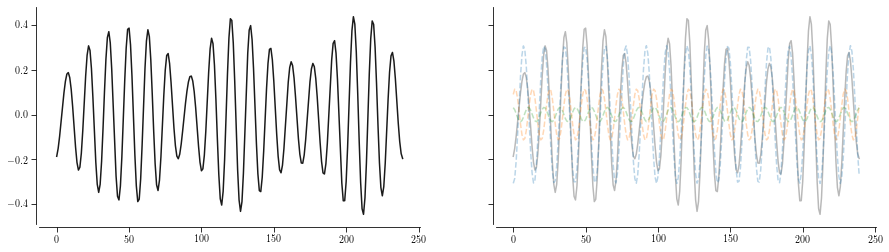

In [2883]:
f, ax = plt.subplots(1,2,figsize=(15,4), sharex=True, sharey=True)
# first, the mixture response
curr_tr = trs[np.random.randint(low=0, high=len(trs), size=1)];
ax[0].plot(rComplex[curr_tr,:,0].flatten(), 'k-');
# then, it's individual components + sum
[ax[1].plot(rComponent[curr_tr,comp,:,0].flatten(), alpha=0.3, linestyle='--') for comp in range(to_match)];
ax[1].plot(np.sum(rComponent[curr_tr,:,:,0], axis=1).flatten(), 'k-', alpha=0.3, zOrder=-10);

sns.despine(offset=3)

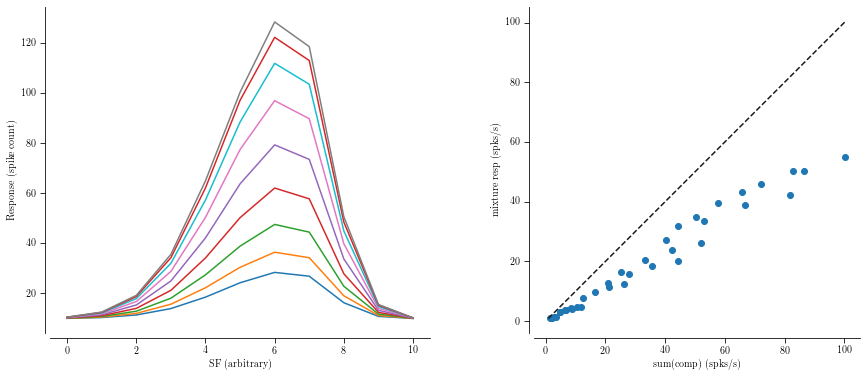

In [2899]:
# What does the tuning look like?
f, ax = plt.subplots(1,2,figsize=(15,6))

# single grating SF
[ax[0].plot(hf.nan_rm(x)) for x in np.transpose(oy[0])];
ax[0].set_xlabel('SF (arbitrary)');
ax[0].set_ylabel('Response (spike count)');

# mixture summation --> just 3-mixes
which_ind = np.where(np.arange(1,7+1,2) == 3)[0]

ax[1].scatter(pred[which_ind].flatten(), measured[which_ind].flatten())
mn = np.minimum(np.nanmin(pred[which_ind]), np.nanmin(measured[which_ind]))
mx = np.maximum(np.nanmax(pred[which_ind]), np.nanmax(measured[which_ind]))
ax[1].plot([mn,mx],[mn,mx], 'k--')
ax[1].axis('scaled')
ax[1].set_xlabel('sum(comp) (spks/s)');
ax[1].set_ylabel('mixture resp (spks/s)');

sns.despine(offset=5)

Note, for example, the two mixtures with the 3rd and 4th highest predicted response --> they are quite similar, and yet have a more marked difference in mixture response. Let's look closely at these trials:

In [2923]:
hmm = np.where(np.logical_and(pred[which_ind]>78, pred[which_ind]<85))
print(hmm)

tr1 = (which_ind[0], hmm[1][0], hmm[2][0])
tr2 = (which_ind[0], hmm[1][1], hmm[2][1])

(array([0, 0]), array([5, 6]), array([16, 12]))


In [2931]:
print('[Pred] %.1f --> %.1f [mixture]' % (pred[tr1], measured[tr1]))
print('[Pred] %.1f --> %.1f [mixture]' % (pred[tr2], measured[tr2]))

[Pred] 81.8 --> 42.3 [mixture]
[Pred] 82.7 --> 50.3 [mixture]


In [2977]:
curr_trs_tr1, allDisps, allCons, allSfs = hf.get_valid_trials(trialInf, tr1[0], tr1[2], tr1[1], expInd)
curr_trs_tr1 = curr_trs_tr1[0]
curr_trs_tr2 = hf.get_valid_trials(trialInf, tr2[0], tr2[2], tr2[1], expInd)[0][0]

comp = 0; # get the valid_trials for the Nth component

con_match = trialInf['con'][comp, curr_trs_tr1[0]]
sf_match = trialInf['sf'][comp, curr_trs_tr1[0]]

con_ind = np.where(np.in1d(np.round(allCons, 3), np.round(con_match, 3)))[0][0];
sf_ind = np.where(np.in1d(allSfs, sf_match))[0][0];

isol_trials_curr = hf.get_valid_trials(trialInf, disp=0, con=con_ind, sf=sf_ind, expInd=expInd)[0][0]

## get both in model terms...(just one ex. trial for now)
ex_mix_tr1 = np.where(dw.trInf['num']==curr_trs_tr1[0])[0][0]
ex_isol_tr1 = np.where(dw.trInf['num']==isol_trials_curr[0])[0]

In [3067]:
oy = hf.spike_fft([rComponent[ex_mix_tr1, comp, :,0].flatten()], 
                            tfs=[trialInf['tf'][comp, curr_trs_tr1[0]]], 
                            stimDur=hf.get_exp_params(expInd).stimDur)[0][0]

vey = hf.spike_fft([rComplex[ex_mix_tr1,:,0].flatten()], 
                            tfs=[curr_tf], 
                            stimDur=hf.get_exp_params(expInd).stimDur)[0][0]

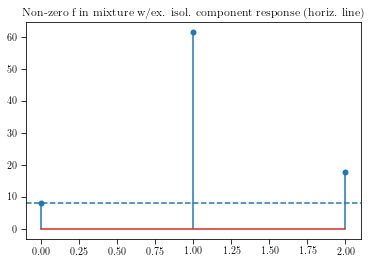

In [3074]:
plt.stem(vey[vey>0.1]); # non zeros..
plt.axhline(oy[oy>0.1], linestyle='--')
plt.title('Non-zero f in mixture w/ex. isol. component response (horiz. line)');

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


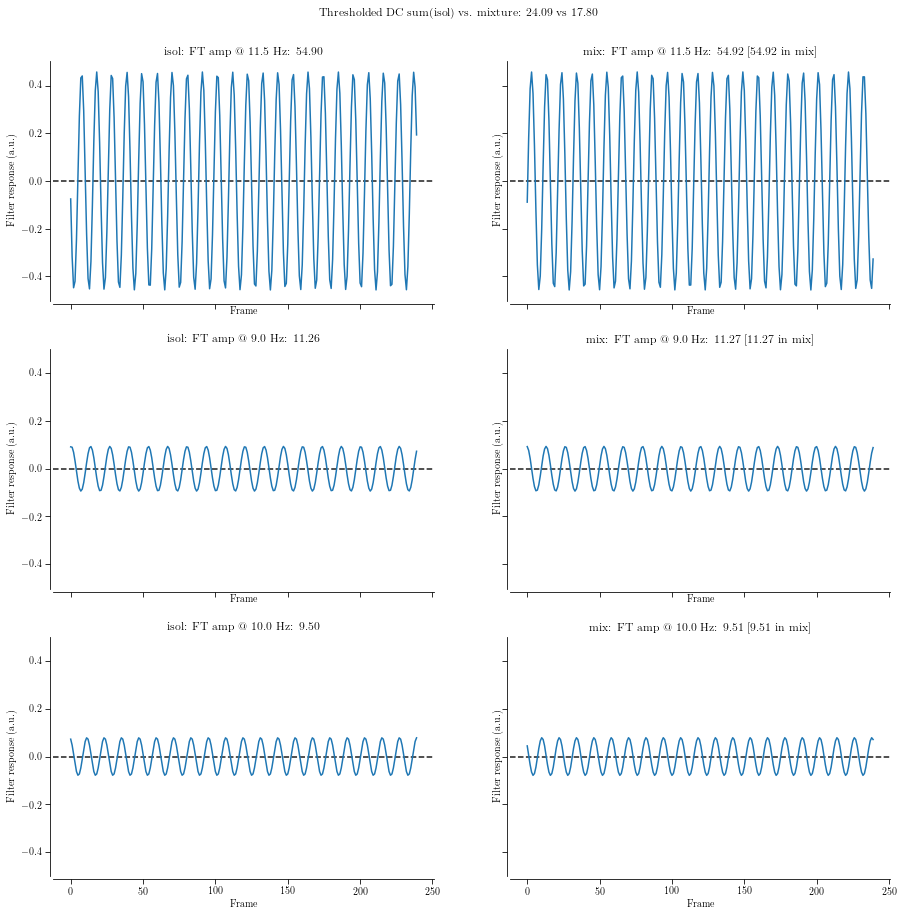

In [3168]:
f, ax = plt.subplots(to_match, 2, figsize=(15,to_match*5), sharex=True, sharey=True);

which_ref_trials = curr_trs_tr2[2];

sum_isol_dc = 0;

for comp in range(to_match):

    con_match = trialInf['con'][comp, which_ref_trials]
    sf_match = trialInf['sf'][comp, which_ref_trials]

    con_ind = np.where(np.in1d(np.round(allCons, 3), np.round(con_match, 3)))[0][0];
    sf_ind = np.where(np.in1d(np.round(allSfs, 3), np.round(sf_match, 3)))[0][0];

    isol_trials_curr = hf.get_valid_trials(trialInf, disp=0, con=con_ind, sf=sf_ind, expInd=expInd)[0][0]

    ## get both in model terms...(just one ex. trial for now)
    ex_mix_tr1 = np.where(dw.trInf['num']==which_ref_trials)[0][0]
    ex_isol_tr1 = np.where(dw.trInf['num']==isol_trials_curr[0])[0]
    
    # first, isol. resp:
    ax[comp, 0].plot(rComplex[ex_isol_tr1,:,0].flatten());
    curr_tf = dw.trInf['tf'][ex_isol_tr1, 0] # isol --> so get 0 component tf
    curr_amp = hf.spike_fft([rComplex[ex_isol_tr1,:,0].flatten()], 
                            tfs=[curr_tf], 
                            stimDur=hf.get_exp_params(expInd).stimDur)[1];
    ax[comp, 0].set_title('isol: FT amp @ %.1f Hz: %.2f' % (curr_tf, curr_amp))

    # then, comp. in mixture:
    ax[comp, 1].plot(rComponent[ex_mix_tr1, comp, :,0].flatten());
    curr_tf = dw.trInf['tf'][ex_mix_tr1, comp]
    curr_amp_isol = hf.spike_fft([rComponent[ex_mix_tr1, comp, :,0].flatten()], 
                            tfs=[trialInf['tf'][comp, which_ref_trials]], 
                            stimDur=hf.get_exp_params(expInd).stimDur)[1];
    curr_amp_mix = hf.spike_fft([rComplex[ex_mix_tr1,:,0].flatten()], 
                            tfs=[curr_tf], 
                            stimDur=hf.get_exp_params(expInd).stimDur)[1];
    ax[comp, 1].set_title('mix: FT amp @ %.1f Hz: %.2f [%.2f in mix]' % (curr_tf, curr_amp_isol, curr_amp_mix))

    # now, threshold - ask what is DC?
    curr_dc = hf.spike_fft([np.maximum(0, rComplex[ex_isol_tr1,:,0].flatten())], 
                            tfs=[curr_tf], 
                            stimDur=hf.get_exp_params(expInd).stimDur)[0];
    
    sum_isol_dc += curr_dc[0][0]
    
    for i in range(2):
        ax[comp, i].axhline(0, color='k', linestyle='--', zOrder=-10)
        ax[comp, i].set_xlabel('Frame')
        ax[comp, i].set_ylabel('Filter response (a.u.)')

mix_dc = hf.spike_fft([np.maximum(0, rComplex[ex_mix_tr1,:,0].flatten())], 
                            tfs=[curr_tf], 
                            stimDur=hf.get_exp_params(expInd).stimDur)[0][0][0];
        
f.suptitle('Thresholded DC sum(isol) vs. mixture: %.2f vs %.2f' % (sum_isol_dc, mix_dc), y=0.93)
sns.despine(offset=3);

Clearly, no issue with the F1. What about the DC values? The consistently lower DC values reflects, I believe, the interference that comes from superimposed drifting gratings. This results from the thresholding. But is that the same as taking into account cross-terms?

##### This isolates the problem to somewhere _after_ rComplex

In [3108]:
Lexc,Linh,sigmaFilt = psf.get_model_responses(trialInf, mod_prms, expInd, cellNum, excType, fitType, f1f0_rat=None, 
                                respMeasure=respMeasure, debug=True,
                                baseline=None, lossType=lossType, lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType)

Lexc = Lexc.detach().numpy();
Linh = Linh.detach().numpy();
sigmaFilt = sigmaFilt.detach().numpy();

In [3113]:
rcmp = rComplex[ex_mix_tr1,:,0].flatten()
plt.plot(rcmp)
plt.plot(rcmp/np.max(rComplex[:,:,0]));

print(np.unique(np.isclose(rcmp/np.max(rComplex[:,:,0]), Lexc[:,ex_mix_tr1])))

[ True]


_Note: Lexc and our within-notebook computed rComplex are the same --> the later just needs to be normalized by the maximum value to mimic the only additional processing step in the actual model code._

In [3121]:
numerator    = Lexc
denominator  = np.power(sigmaFilt + np.power(Linh, 2), 0.5); # nTrials 
rawResp      = torch.div(mrpt._cast_as_tensor(numerator), mrpt._cast_as_tensor(denominator).unsqueeze(0)).detach().numpy();

In [3140]:
dw.trInf['con'][trz_1]

tensor([[0.6876, 0.1538, 0.1538, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6876, 0.1538, 0.1538, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6876, 0.1538, 0.1538, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6876, 0.1538, 0.1538, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6876, 0.1538, 0.1538, 0.0000, 0.0000, 0.0000, 0.0000]])

In [3141]:
dw.trInf['con'][trz_2]

tensor([[0.4731, 0.1058, 0.1058, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4731, 0.1058, 0.1058, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4731, 0.1058, 0.1058, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4731, 0.1058, 0.1058, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4731, 0.1058, 0.1058, 0.0000, 0.0000, 0.0000, 0.0000]])

In [3135]:
# check: Denominator the same within a given condition? Yes...
trz_1 = np.where(np.in1d(dw.trInf['num'], curr_trs_tr1))[0]
denom_1 = np.unique(denominator[trz_1])

trz_2 = np.where(np.in1d(dw.trInf['num'], curr_trs_tr2))[0]
denom_2 = np.unique(denominator[trz_2])

print('%.2f vs. %.2f' % (denom_1, denom_2))

0.80 vs. 0.60


You fool! They just have different denominators, because they have a different total contrast!

Is there a way to use the model to save the analysis??? Or is it OK, regardless?
- Can it be saved by passing through (forward or inverse?) the RVCs (which would depend on SF)

### 2.3 Quickly look at single gratings?

In [3433]:
autoreload.reload(mrpt);

In [3434]:
fitList_nm = 'fitListHPC_pyt_221014_noRE_noSched_flat_sqrt.npy'

In [3435]:
cellNum = 4
expDir = 'altExp/'
respMeasure = 0; # dc [0] or f1 [1]

excType = 2; # 1 is deriv. order, 2 is flex. gauss
lossType = 1
fitType = 1 # flat [1], tuned [2] or gain tuned[5]
lgnFrontOn = 0
lgnConType = 1
_LGNforNorm = 0
normToOne = True;
recenter_norm = 2;
_sigmoidSigma = 5;

### Load data (to use for vExp calc.)
data_loc = base_dir + '%sstructures/' % expDir
expName = hf.get_datalist(expDir, force_full=True);
dataList = hf.np_smart_load(str(data_loc + expName))
expInd   = hf.exp_name_to_ind(dataList['expType'][cellNum-1]);

expData = hf.np_smart_load(data_loc + '%s_sfm.npy' % dataList['unitName'][cellNum-1])
trialInf = expData['sfm']['exp']['trial']

good_fit = hf.np_smart_load('%sstructures/%s' % (expDir, fitList_nm))
respStr = 'dc' if respMeasure == 0 else 'f1'
mod_prms = good_fit[cellNum-1][respStr]['params']

In [3517]:
dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd, 
                      respOverwrite=respOverwrite)#, shuffleTf=True, shufflePh=True);

In [3518]:
model = mrpt.sfNormMod(mod_prms, expInd=expInd, excType=excType, normType=fitType, 
                       lossType=lossType, lgnFrontEnd=lgnFrontOn, newMethod=1, 
                       lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, normToOne=normToOne)

modResp = model.forward(dw.trInf, respMeasure=respMeasure, sigmoidSigma=_sigmoidSigma, recenter_norm=recenter_norm).detach().numpy();
oy = gather_into_full_resp(dw, trialInf, expInd, modResp);


resps = psf.get_model_responses(trialInf, mod_prms, expInd, cellNum, excType, fitType, f1f0_rat=None, 
                                respMeasure=respMeasure,
                                baseline=None, lossType=lossType, lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType)
# Used for superposition analysis!
measured, _, pred, _ = resps

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5146: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);


In [3519]:
realImag, selSi, selSi_stimCo = model.simpleResp_matMul(dw.trInf, sigmoidSigma=sigmoidSigma, debug=True);
# P, omegas, dotprod, selSi, selSi_stimCo = model.simpleResp_matMul(dw.trInf, sigmoidSigma=sigmoidSigma, debug=True);

rComplex = torch.einsum('ij,ikjz->ikz', selSi_stimCo, realImag).detach().numpy()
rComponent = torch.einsum('ij,ikjz->ijkz', selSi_stimCo, realImag).detach().numpy()

In [3337]:
# sings = np.where(dw.trInf['con'][:,1]==0)[0] # i.e. single grating only
sings = np.where(dw.trInf['con'][:,0]==1)[0] # full contrast, single grats

Here, we've forced tf=2Hz:

In [3363]:
curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, :, 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f' % curr_dc);

Here, tf=5Hz:

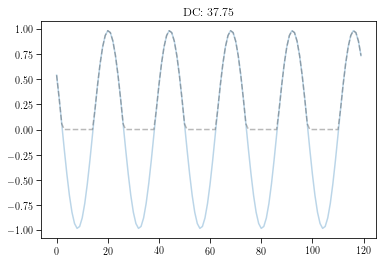

In [3358]:
curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, :, 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f' % curr_dc);

Here, tf=5.5Hz :

In [3353]:
curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, :, 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f' % curr_dc);

Here, original TF:

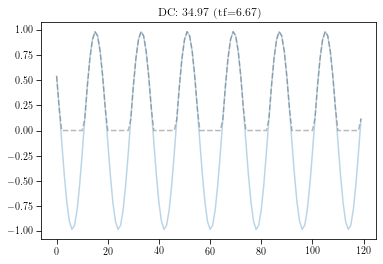

In [3343]:
curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, :, 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f (tf=%.2f)' % (curr_dc, dw.trInf['tf'][curr_tr,0]));

Here, original TF - but normalizing rComplex based on abs(max), not just max:

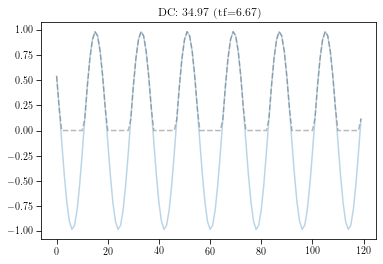

In [3431]:
curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, :, 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f (tf=%.2f)' % (curr_dc, dw.trInf['tf'][curr_tr,0]));

Again, original TF, but now randomized Ph:

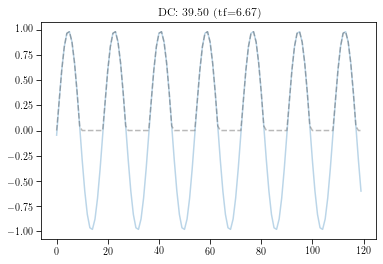

In [3347]:
curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, :, 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f (tf=%.2f)' % (curr_dc, dw.trInf['tf'][curr_tr,0]));

### 2.4 Why is it that integer TFs (typically?) yield smaller DC values than non-integer TFs? Perhaps it's just a by-product of thresholding a signal with non-integer cycles? 

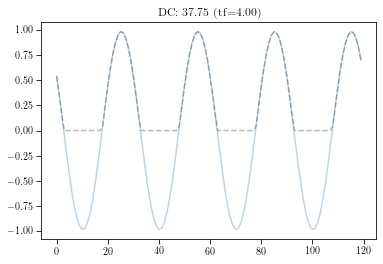

In [3443]:
curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, :, 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f (tf=%.2f)' % (curr_dc, dw.trInf['tf'][curr_tr,0]));

In [3452]:
ref_dc = 37.75;

Now, just take half the signal (will still be int. number of cycles):

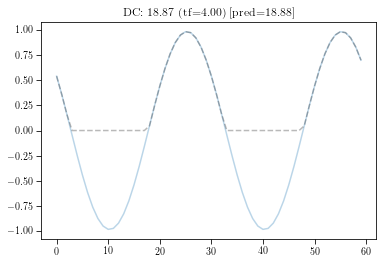

In [3453]:
frac = 0.5

curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, 0:int(frac*rComplex.shape[1]), 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f (tf=%.2f) [pred=%.2f]' % (curr_dc, dw.trInf['tf'][curr_tr,0], frac*ref_dc));

Ok, that gives half of the DC response from above - makes sense. But if we do, for example, 60% (non-int # of cycles)

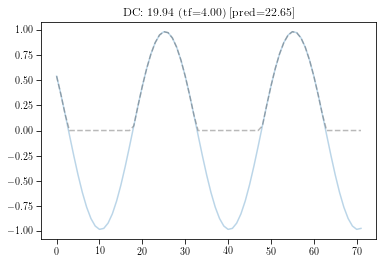

In [3454]:
frac = 0.6

curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, 0:int(frac*rComplex.shape[1]), 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f (tf=%.2f) [pred=%.2f]' % (curr_dc, dw.trInf['tf'][curr_tr,0], frac*ref_dc));

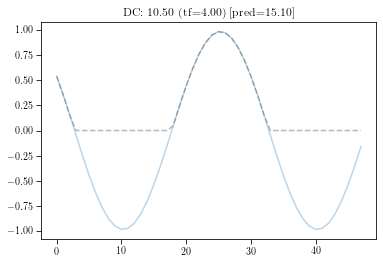

In [3455]:
frac = 0.4

curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, 0:int(frac*rComplex.shape[1]), 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f (tf=%.2f) [pred=%.2f]' % (curr_dc, dw.trInf['tf'][curr_tr,0], frac*ref_dc));

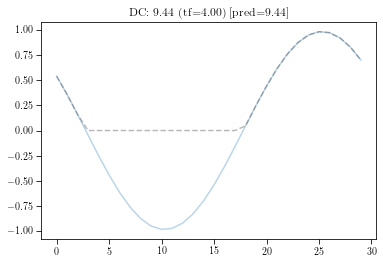

In [3456]:
frac = 0.25

curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, 0:int(fr ac*rComplex.shape[1]), 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f (tf=%.2f) [pred=%.2f]' % (curr_dc, dw.trInf['tf'][curr_tr,0], frac*ref_dc));

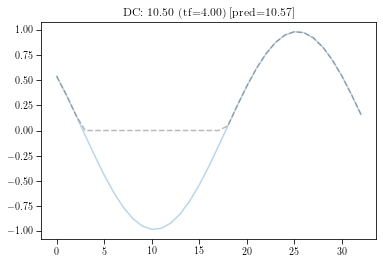

In [3467]:
frac = 0.28

curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, 0:int(frac*rComplex.shape[1]), 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f (tf=%.2f) [pred=%.2f]' % (curr_dc, dw.trInf['tf'][curr_tr,0], frac*ref_dc));

Now, more systematically:

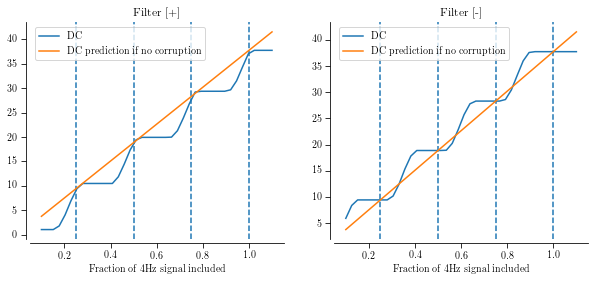

In [3508]:
tf = 4; # in mrpt.process_data, set Tf to be 4Hz
fracs = np.linspace(0.1,1.1,tf*10);

f, ax = plt.subplots(1,2, figsize=(10,4));

for i in range(2):
    curr_dcs = [hf.spike_fft([np.maximum(0, np.power(-1,i)*rComplex[curr_tr, 0:int(frac*rComplex.shape[1]), 0])], 
                             stimDur=hf.get_exp_params(expInd).stimDur,)[0][0][0] for frac in fracs]
    ax[i].plot(fracs, curr_dcs, label='DC');
    [ax[i].axvline(x/4, linestyle='--') for x in range(1,1+tf)];
    ax[i].plot(fracs, fracs*ref_dc, label='DC prediction if no corruption');
    ax[i].set_xlabel('Fraction of 4Hz signal included')

    ax[i].legend();
    ax[i].set_title('Filter [%s]' % ('+' if i==0 else '-'))

sns.despine(offset=4)



And a few more times, with shuffled Ph:

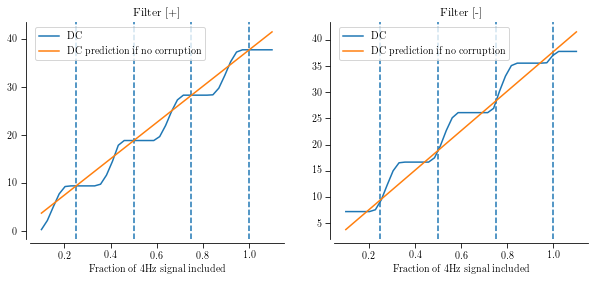

In [3512]:
tf = 4; # in mrpt.process_data, set Tf to be 4Hz
fracs = np.linspace(0.1,1.1,tf*10);

f, ax = plt.subplots(1,2, figsize=(10,4));

for i in range(2):
    curr_dcs = [hf.spike_fft([np.maximum(0, np.power(-1,i)*rComplex[curr_tr, 0:int(frac*rComplex.shape[1]), 0])], 
                             stimDur=hf.get_exp_params(expInd).stimDur,)[0][0][0] for frac in fracs]
    ax[i].plot(fracs, curr_dcs, label='DC');
    [ax[i].axvline(x/4, linestyle='--') for x in range(1,1+tf)];
    ax[i].plot(fracs, fracs*ref_dc, label='DC prediction if no corruption');
    ax[i].set_xlabel('Fraction of 4Hz signal included')

    ax[i].legend();
    ax[i].set_title('Filter [%s]' % ('+' if i==0 else '-'))

sns.despine(offset=4)



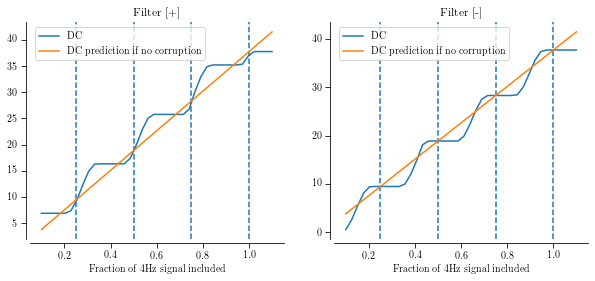

In [3520]:
tf = 4; # in mrpt.process_data, set Tf to be 4Hz
fracs = np.linspace(0.1,1.1,tf*10);

f, ax = plt.subplots(1,2, figsize=(10,4));

for i in range(2):
    curr_dcs = [hf.spike_fft([np.maximum(0, np.power(-1,i)*rComplex[curr_tr, 0:int(frac*rComplex.shape[1]), 0])], 
                             stimDur=hf.get_exp_params(expInd).stimDur,)[0][0][0] for frac in fracs]
    ax[i].plot(fracs, curr_dcs, label='DC');
    [ax[i].axvline(x/4, linestyle='--') for x in range(1,1+tf)];
    ax[i].plot(fracs, fracs*ref_dc, label='DC prediction if no corruption');
    ax[i].set_xlabel('Fraction of 4Hz signal included')

    ax[i].legend();
    ax[i].set_title('Filter [%s]' % ('+' if i==0 else '-'))

sns.despine(offset=4)



_Summary_: **The thresholding is why non-integer TFs can give different results than integer TFs.** Note that integer TFs here means Tfs which give an integer number of cycles (which also includes 2.5Hz for a 2s signal, for example). Furthermore, the DC depends on which filter we choose (the +/- represent two of the four possible quadrature filters) and the phase of the stimulus (as evident by the three different runs with different phases).

### 2.5 Just make sure that we cannot get F1 from quadrature
We'll force TF to an integer value (e.g. 5 Hz)

In [3571]:
autoreload.reload(mrpt);

In [3572]:
dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd, 
                      respOverwrite=respOverwrite, shuffleTf=True, shufflePh=True);

In [3573]:
model = mrpt.sfNormMod(mod_prms, expInd=expInd, excType=excType, normType=fitType, 
                       lossType=lossType, lgnFrontEnd=lgnFrontOn, newMethod=1, 
                       lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, normToOne=normToOne)

modResp = model.forward(dw.trInf, respMeasure=respMeasure, sigmoidSigma=_sigmoidSigma, recenter_norm=recenter_norm).detach().numpy();
oy = gather_into_full_resp(dw, trialInf, expInd, modResp);


resps = psf.get_model_responses(trialInf, mod_prms, expInd, cellNum, excType, fitType, f1f0_rat=None, 
                                respMeasure=respMeasure,
                                baseline=None, lossType=lossType, lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType)
# Used for superposition analysis!
measured, _, pred, _ = resps

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5146: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);


In [3574]:
resp__ = model.simpleResp_matMul(dw.trInf, sigmoidSigma=sigmoidSigma, debug=False, quadrature=False).detach().numpy();

# and again, but quadrature:
resp__quadr = model.simpleResp_matMul(dw.trInf, sigmoidSigma=sigmoidSigma, debug=False, quadrature=True).detach().numpy();

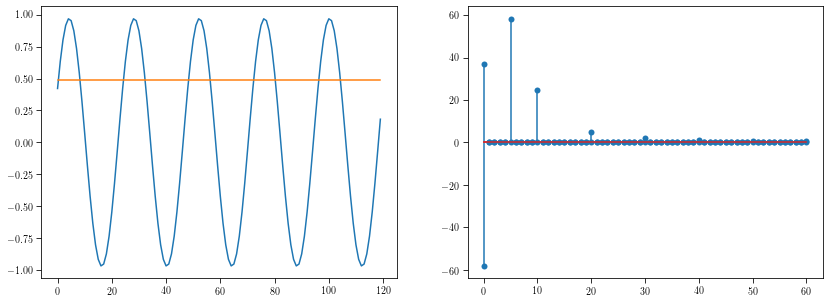

In [3590]:
f, ax = plt.subplots(1,2, figsize=(14,5));

sings = np.where(dw.trInf['con'][:,0]==1)[0] # full contrast, single grats
ex_tr = sings[np.random.randint(len(sings))]
curr_tf = dw.trInf['tf'][ex_tr, 0].detach().numpy();


# Trajectory
ax[0].plot(resp__[:,ex_tr]);
ax[0].plot(resp__quadr[:,ex_tr]);

# FFT
orig = hf.spike_fft([np.maximum(0, resp__[:,ex_tr])], 
                            tfs=[curr_tf], 
                            stimDur=hf.get_exp_params(expInd).stimDur)[0][0]

quadr = hf.spike_fft([np.maximum(0, resp__quadr[:,ex_tr])], 
                            tfs=[curr_tf], 
                            stimDur=hf.get_exp_params(expInd).stimDur)[0][0]

ax[1].stem(orig);
ax[1].stem(-quadr);

_Good - as expected. Quadrature gives constant response, therefore with no time-variation, all frequency-specific response is lost. So, we should use quadrature for DC, single filter for F1._

### 2.6 - Re-checking initialization with quadrature

In [4306]:
autoreload.reload(mrpt); autoreload.reload(hf);

In [4310]:
cellNum = 3
expDir = 'altExp/'
respMeasure = 0; # dc [0] or f1 [1]

excType = 2; # 1 is deriv. order, 2 is flex. gauss
lossType = 1
fitType = 2 # flat [1], tuned [2] or gain tuned[5]
lgnFrontOn = 0
lgnConType = 4
_LGNforNorm = 1

use_quadr = True if respMeasure==0 else False;

### Load data (to use for vExp calc.)
data_loc = base_dir + '%sstructures/' % expDir
expName = hf.get_datalist(expDir, force_full=True);
dataList = hf.np_smart_load(str(data_loc + expName))
expInd   = hf.exp_name_to_ind(dataList['expType'][cellNum-1]);

if respMeasure == 1:
    rvcName = 'rvcFitsHPC_220928'
    rvcFits = hf.get_rvc_fits(data_loc, expInd, cellNum, rvcName=rvcName, rvcMod=1, direc=1, vecF1=0);
    get_adj_spikes = hf.get_adjusted_spikerate(trialInf, cellNum, expInd, data_loc, rvcName=rvcFits, rvcMod=-1, 
                                               baseline_sub=False, return_measure=False, vecF1=0, force_f1=True, returnByComp=True)

expData = hf.np_smart_load(data_loc + '%s_sfm.npy' % dataList['unitName'][cellNum-1])
trialInf = expData['sfm']['exp']['trial']
respOverwrite = None if respMeasure==0 else get_adj_spikes;
dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd, respOverwrite=respOverwrite)

spikes_rate = hf.get_adjusted_spikerate(expData['sfm']['exp']['trial'], cellNum, expInd, data_loc, rvcName=rvcName, rvcMod=1, force_dc=True if respMeasure==0 else False, baseline_sub=False)
_, _, expByCond, _ = hf.organize_resp(spikes_rate, trialInf, expInd, respsAsRate=False);

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5146: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  spike_times = np.array([trial_inf['spikeTimes'][x] for x in all_trs]);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:802: RuntimeWarning: invalid value encountered in double_scalars
  th = [np.rad2deg(np.arctan(np.abs(y_coord[i]/x_coord[i]))) for i in range(len(x_coord))];


condition d/con/sf || 00/02/09 has (some?) nan phi; r values below
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
condition d/con/sf || 00/02/10 has (some?) nan phi; r values below
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
condition d/con/sf || 00/04/08 has (some?) nan phi; r values below
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


In [4311]:
# normType = 1; # flat
# normType = 2; # weight
# normType = 5; # weighted gain
normType = fitType

# prms_use_orig = np.copy(prms_use);
# prms_use = good_prms if normType==1 else good_prms_wt;

init_prms = mrpt.setModel(cellNum, expDir=expDir, excType=excType, lossType=lossType, fitType=normType, 
                          lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm,
                          fixRespExp=fixRespExp, respMeasure=respMeasure, normToOne=True,
                          newMethod=1, vecCorrected=0, initFromCurr=0, returnOnlyInits=True)

prms_use = np.copy(init_prms)
# prms_use[-4] = -10

init_mod = mrpt.sfNormMod(prms_use, expInd=expInd, excType=excType, normType=normType, lossType=lossType,  
                         newMethod=1, lgnFrontEnd=lgnFrontOn, lgnConType=lgnCon, 
                          applyLGNtoNorm=_applyLGNtoNorm,normToOne=True)
# now, make normConst = 0, 0.5, -1
prms_use = np.copy(init_prms)
prms_use[2] = 0;
init_mod_0 = mrpt.sfNormMod(prms_use, expInd=expInd, excType=excType, normType=normType, lossType=lossType,  
                         newMethod=1, lgnFrontEnd=lgnFrontOn, lgnConType=lgnCon, 
                          applyLGNtoNorm=_applyLGNtoNorm,normToOne=True)
# --- 0.5
prms_use = np.copy(init_prms)
prms_use[2] = 0.5;
init_mod_05 = mrpt.sfNormMod(prms_use, expInd=expInd, excType=excType, normType=normType, lossType=lossType,  
                         newMethod=1, lgnFrontEnd=lgnFrontOn, lgnConType=lgnCon, 
                          applyLGNtoNorm=_applyLGNtoNorm,normToOne=True)
# --- neg 1
prms_use = np.copy(init_prms)
prms_use[2] = -1;
init_mod_n1 = mrpt.sfNormMod(prms_use, expInd=expInd, excType=excType, normType=normType, lossType=lossType,  
                         newMethod=1, lgnFrontEnd=lgnFrontOn, lgnConType=lgnCon, 
                          applyLGNtoNorm=_applyLGNtoNorm,normToOne=True)


# amps, psth_orig = mod.forward(trInf, returnPsth=True)
_, vExp_init, mod_resps_init = get_vExp_mod(expByCond, init_mod, dw, expInd, respMeasure=respMeasure, returnAll=True)
_, vExp_init, mod_resps_init_0 = get_vExp_mod(expByCond, init_mod_0, dw, expInd, respMeasure=respMeasure, returnAll=True)
_, vExp_init, mod_resps_init_05 = get_vExp_mod(expByCond, init_mod_05, dw, expInd, respMeasure=respMeasure, returnAll=True)
_, vExp_init, mod_resps_init_n1 = get_vExp_mod(expByCond, init_mod_n1, dw, expInd, respMeasure=respMeasure, returnAll=True)

# for more specific debugging:
Lexc, Linh, sigma = init_mod.respPerCell(dw.trInf, sigmoidSigma=sigmoidSigma, 
                                         recenter_norm=recenter_norm, debug=True, quadrature=use_quadr);
Lexc  = Lexc.detach().numpy();
Linh  = Linh.detach().numpy();
sigma = sigma.detach().numpy();



FitList: fitList_pyt_nr221024c_noREp_wght_sqrt.npy [expDir is altExp/]
loading data structure from /arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/altExp/structures/...
expInd is 2
respMeasure, vecCorrected: 0, 0
prefSf: 1.73

********MODEL PARAMETERS********
prefSf: 1.99
sigma l|r: -0.64|-1.56
No LGN!
scalar|early|late: 14.758|0.000|0.000
norm. const.: -0.25
tuned norm mn|std: 1.30|0.77
still applying the LGN filter for the gain control
********END OF MODEL PARAMETERS********



/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


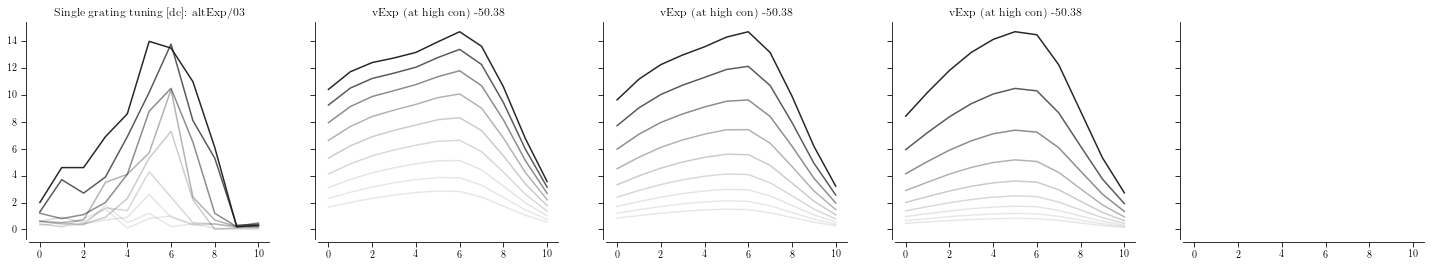

In [4312]:
##### nrow = 5
f, ax = plt.subplots(1,nrow,figsize=(5*nrow,4), sharey=True, sharex=True)

# data
[ax[0].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(expByCond[0]))]
ax[0].set_title('Single grating tuning [%s]: %s/%02d' % ('dc' if respMeasure==0 else 'f1', expDir.replace('/', '').replace('_', ''), cellNum));

# model
[ax[1].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(mod_resps_init[0]))]
ax[1].set_title('vExp (at high con) %.2f' % vExp_init[0,-1]);

# model
[ax[2].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(mod_resps_init_0[0]))]
ax[2].set_title('vExp (at high con) %.2f' % vExp_init[0,-1]);
# model
[ax[3].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(mod_resps_init_05[0]))]
ax[3].set_title('vExp (at high con) %.2f' % vExp_init[0,-1]);

# model
# [ax[4].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(mod_resps_init_n1[0]))]
# ax[4].set_title('vExp (at high con) %.2f' % vExp_init[0,-1]);


sns.despine(offset=3)

In [3965]:
autoreload.reload(mrpt);

In [3995]:
normType = 2

# init_prms = mrpt.setModel(cellNum, expDir=expDir, excType=excType, lossType=lossType, fitType=normType, 
#                           lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm,
#                           fixRespExp=fixRespExp, respMeasure=respMeasure, normToOne=True,
#                           newMethod=1, vecCorrected=0, initFromCurr=0, returnOnlyInits=True)
prms_use = np.copy(init_prms);
prms_use[-3] = prms_use[-3]*0.01

init_mod = mrpt.sfNormMod(prms_use, expInd=expInd, excType=excType, normType=normType, lossType=lossType,  
                         newMethod=1, lgnFrontEnd=lgnFrontOn, lgnConType=lgnCon, 
                          applyLGNtoNorm=_applyLGNtoNorm,normToOne=True)


oy = init_mod.genNormWeightsSimple(dw.trInf, recenter_norm=recenter_norm, threshWeights=1e-6);
oy = oy[:,0].detach().numpy();

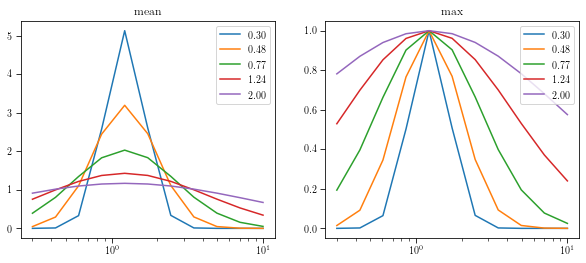

In [4016]:
import torch;
gs_mean = mrpt._cast_as_tensor(0.2);

f, ax = plt.subplots(1,2,figsize=(10,4))

for gs_val in np.geomspace(0.3, 2, 5):
    gs_std = mrpt._cast_as_tensor(gs_val);

    log_sfs = mrpt._cast_as_tensor(np.log(np.geomspace(0.3, 10, 11)))
    weight_distr = torch.distributions.normal.Normal(gs_mean, torch.abs(gs_std))
    
    for i in range(2):
        new_weights = torch.exp(weight_distr.log_prob(log_sfs))
    
        if i == 0:
            new_weights = new_weights/torch.max(mrpt._cast_as_tensor(0.001), torch.mean(new_weights))
        else:
            new_weights = new_weights/torch.max(mrpt._cast_as_tensor(0.001), torch.max(new_weights))
        new_weights = new_weights.detach().numpy();

        ax[i].semilogx(np.exp(log_sfs.detach().numpy()), new_weights, label='%.2f' % gs_val)

for i,ttl in enumerate(['mean', 'max']):
    ax[i].legend();
    ax[i].set_title(ttl);

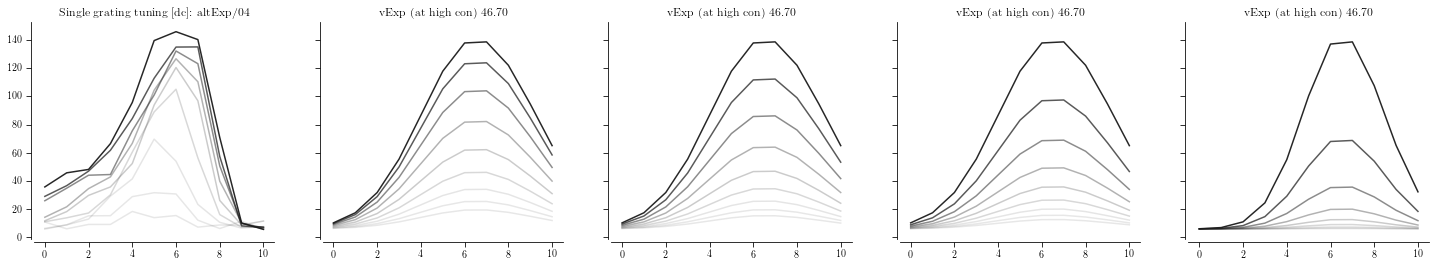

In [3882]:
nrow = 5
f, ax = plt.subplots(1,nrow,figsize=(5*nrow,4), sharey=True, sharex=True)

# data
[ax[0].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(expByCond[0]))]
ax[0].set_title('Single grating tuning [%s]: %s/%02d' % ('dc' if respMeasure==0 else 'f1', expDir.replace('/', '').replace('_', ''), cellNum));

# model
[ax[1].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(mod_resps_init[0]))]
ax[1].set_title('vExp (at high con) %.2f' % vExp_init[0,-1]);

# model
[ax[2].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(mod_resps_init_0[0]))]
ax[2].set_title('vExp (at high con) %.2f' % vExp_init[0,-1]);
# model
[ax[3].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(mod_resps_init_1[0]))]
ax[3].set_title('vExp (at high con) %.2f' % vExp_init[0,-1]);

# model
[ax[4].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(mod_resps_init_8[0]))]
ax[4].set_title('vExp (at high con) %.2f' % vExp_init[0,-1]);


sns.despine(offset=3)

In [3919]:
Linh[sings]

array([0.0727, 0.0727, 0.0727, 0.0727, 0.0727, 0.0727, 0.0727, 0.0727,
       0.0727, 0.0727], dtype=float32)

In [3918]:
Lexc[0, sings]

array([0.03635, 0.03635, 0.03635, 0.03635, 0.03635, 0.03635, 0.03635,
       0.03635, 0.03635, 0.03635], dtype=float32)

In [3909]:
sings

array([ 125,  291,  461,  629,  813,  977, 1141, 1246, 1415, 1560])

In [3914]:
unq_cons = np.unique(dw.trInf['con'][:,0])

In [3927]:
singz = np.where(dw.trInf['con'][:,1]==0)[0] # full contrast, single grats

In [3931]:
oy = Lexc[0,singz]/Linh[singz]

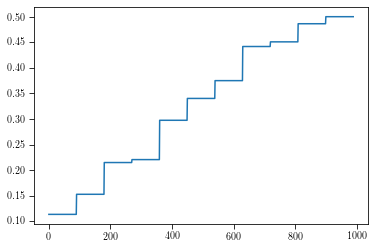

In [3933]:
plt.plot(sorted(oy))

In [3917]:
# sings = np.where(dw.trInf['con'][:,0]==1)[0] # full contrast, single grats
unq_sfs = np.unique(dw.trInf['sf'][:,0])
unq_cons = np.unique(dw.trInf['con'][:,0])
sings = np.where(np.logical_and(dw.trInf['con'][:,0]==unq_cons[1], dw.trInf['sf'][:,0]==unq_sfs[6]))[0] # full contrast, single grats



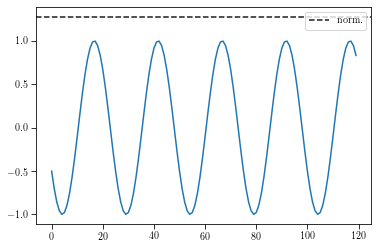

In [3820]:
# Not quadrature...
# curr_tr = np.random.randint(len(sings));
# plt.plot(np.round(Lexc[:,sings[curr_tr]], 4))

# plt.axhline(np.round(Linh[sings[curr_tr]], 4), color='k', linestyle='--', label='norm.')

# plt.legend();

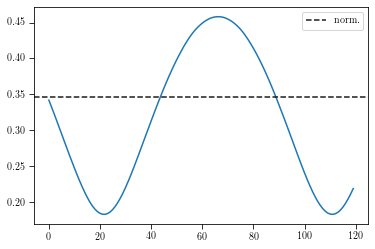

In [3830]:
curr_tr = np.random.randint(Lexc.shape[-1]);
plt.plot(np.round(Lexc[:,curr_tr], 4))
plt.axhline(np.round(Linh[curr_tr], 4), color='k', linestyle='--', label='norm.')

# curr_tr = np.random.randint(len(sings));
# plt.plot(np.round(Lexc[:,sings[curr_tr]], 4))
# plt.axhline(np.round(Linh[sings[curr_tr]], 4), color='k', linestyle='--', label='norm.')

plt.legend();

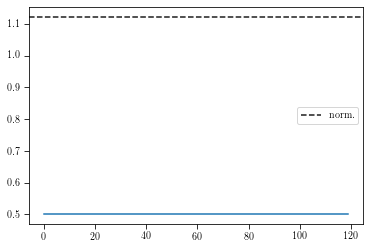

In [3818]:
curr_tr = np.random.randint(len(sings));
plt.plot(np.round(Lexc[:,sings[curr_tr]], 4))

plt.axhline(np.round(Linh[sings[curr_tr]], 4), color='k', linestyle='--', label='norm.')

plt.legend();

Used for T+E meeting, 22.10.13:

In [2708]:
# vt_0 is a reference (single gratings)
ref_con = val_con_by_disp[0][-1];
disp_lvl = 3;
disp_con = val_con_by_disp[disp_lvl][-1]
vt_0 = hf.get_valid_trials(trialInf, 0, ref_con, 5, expInd, stimVals=stimVals, validByStimVal=val_by_stim_val)[0]
vt_1 = hf.get_valid_trials(trialInf, disp_lvl, disp_con, 5, expInd, stimVals=stimVals, validByStimVal=val_by_stim_val)[0]
vt_2 = hf.get_valid_trials(trialInf, disp_lvl, disp_con, 6, expInd, stimVals=stimVals, validByStimVal=val_by_stim_val)[0]
vt_3 = hf.get_valid_trials(trialInf, disp_lvl, disp_con, 7, expInd, stimVals=stimVals, validByStimVal=val_by_stim_val)[0]

# Get them in the correct trials for what we ran the model on
vt_0_adj = np.where(np.in1d(dw.trInf['num'], vt_0))[0]
vt_1_adj = np.where(np.in1d(dw.trInf['num'], vt_1))[0]
vt_2_adj = np.where(np.in1d(dw.trInf['num'], vt_2))[0]
vt_3_adj = np.where(np.in1d(dw.trInf['num'], vt_3))[0]


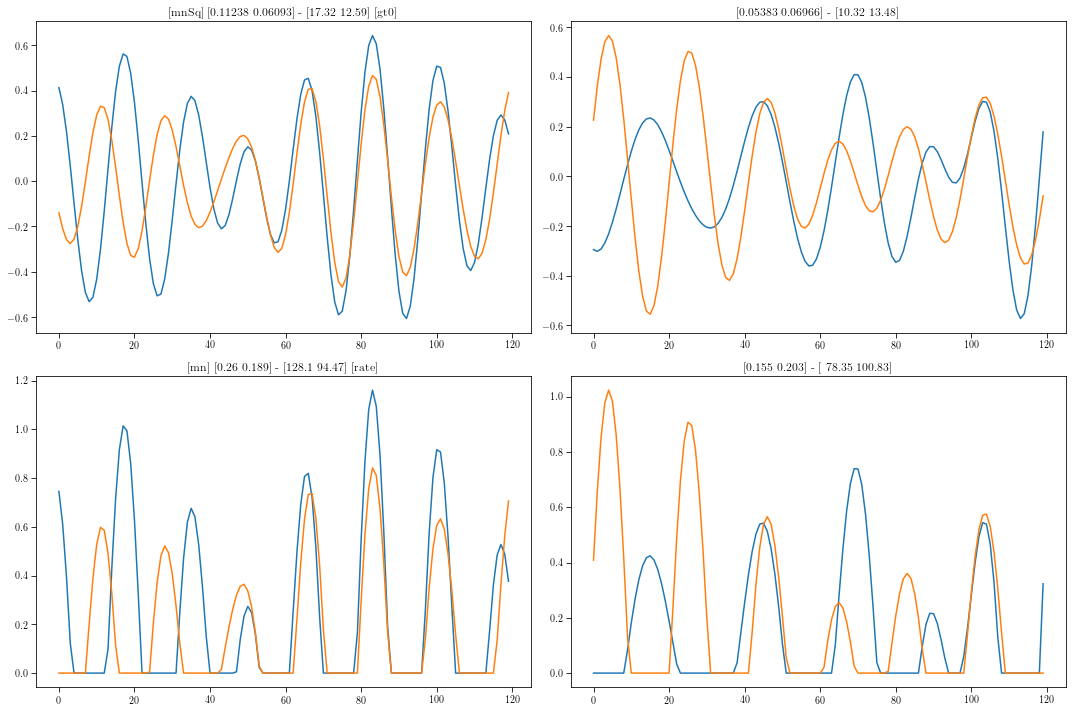

In [2714]:
f, ax = plt.subplots(2,2,figsize=(15,10))

Lexc_sqrd_mn = np.mean(np.square(Lexc),axis=0)
Lexc_pos_sum = np.array([np.sum(x[x>0]) for x in np.transpose(Lexc)])

curr_trs = vt_1_adj;

[ax[0,0].plot(Lexc[:, x]) for x in curr_trs[0:2]];
ax[0,0].set_title('[mnSq] %s - %s [gt0]' % (np.array2string(Lexc_sqrd_mn[curr_trs[0:2]], precision=5), 
                               np.array2string(Lexc_pos_sum[curr_trs[0:2]], precision=2)))
[ax[0,1].plot(Lexc[:, x]) for x in curr_trs[3:5]];
ax[0, 1].set_title('%s - %s' % (np.array2string(Lexc_sqrd_mn[curr_trs[3:5]], precision=5), 
                               np.array2string(Lexc_pos_sum[curr_trs[3:5]], precision=2)))

# and full model resp:
thresh_mn = np.array([np.mean(mod_resps[x]) for x in curr_trs]);
[ax[1,0].plot(mod_resps[x,:]) for x in curr_trs[0:2]];
ax[1,0].set_title('[mn] %s - %s [rate]' % (np.array2string(thresh_mn[0:2], precision=3), 
                                           np.array2string(modResp[curr_trs[0:2]], precision=2)))
[ax[1,1].plot(mod_resps[x,:]) for x in curr_trs[3:5]];
ax[1,1].set_title('%s - %s' % (np.array2string(thresh_mn[3:5], precision=3), np.array2string(modResp[curr_trs[3:5]], precision=2)))

f.tight_layout();


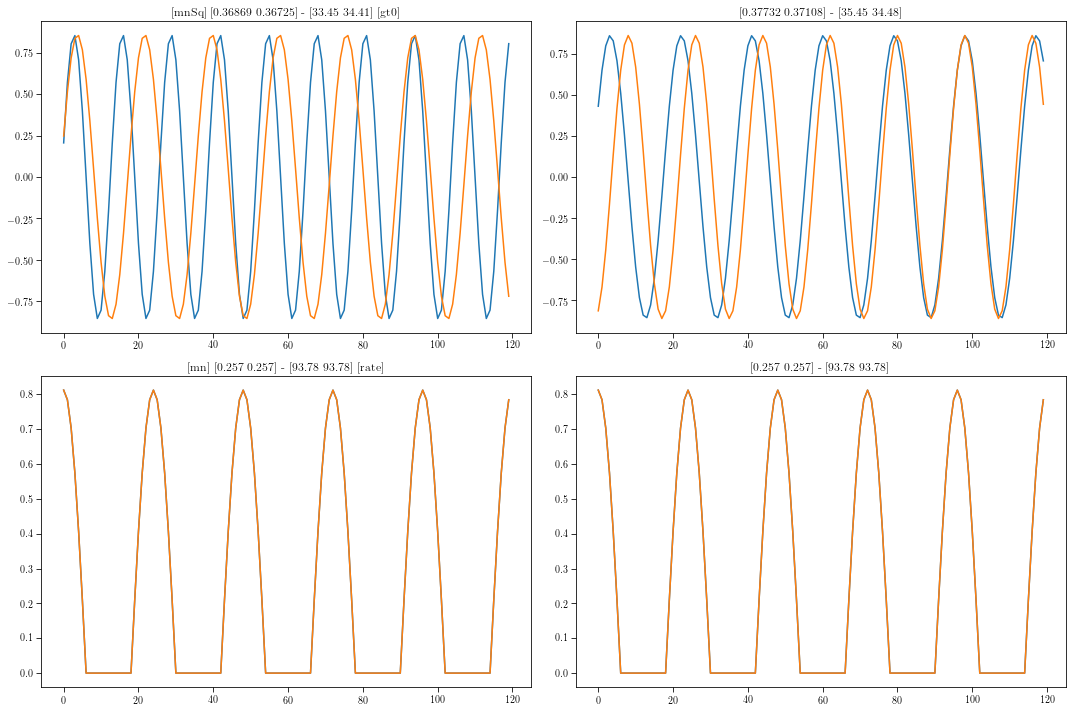

In [2680]:
f, ax = plt.subplots(2,2,figsize=(15,10))

Lexc_sqrd_mn = np.mean(np.square(Lexc),axis=0)
Lexc_pos_sum = np.array([np.sum(x[x>0]) for x in np.transpose(Lexc)])

curr_trs = vt_0_adj;

[ax[0,0].plot(Lexc[:, x]) for x in curr_trs[0:2]];
ax[0,0].set_title('[mnSq] %s - %s [gt0]' % (np.array2string(Lexc_sqrd_mn[curr_trs[0:2]], precision=5), 
                               np.array2string(Lexc_pos_sum[curr_trs[0:2]], precision=2)))
[ax[0,1].plot(Lexc[:, x]) for x in curr_trs[3:5]];
ax[0, 1].set_title('%s - %s' % (np.array2string(Lexc_sqrd_mn[curr_trs[3:5]], precision=5), 
                               np.array2string(Lexc_pos_sum[curr_trs[3:5]], precision=2)))

# and full model resp:
thresh_mn = np.array([np.mean(mod_resps[x]) for x in curr_trs]);
[ax[1,0].plot(mod_resps[x,:]) for x in curr_trs[0:2]];
ax[1,0].set_title('[mn] %s - %s [rate]' % (np.array2string(thresh_mn[0:2], precision=3), 
                                           np.array2string(modResp[curr_trs[0:2]], precision=2)))
[ax[1,1].plot(mod_resps[x,:]) for x in curr_trs[3:5]];
ax[1,1].set_title('%s - %s' % (np.array2string(thresh_mn[3:5], precision=3), np.array2string(modResp[curr_trs[3:5]], precision=2)))

f.tight_layout();


# 3. Re-implementing a full normalization pool with temporal dynamics

Reload, get the responses (must make forward pass first in order to pre-compute the image)

In [5343]:
autoreload.reload(mrpt); autoreload.reload(hf);

In [5344]:
lgnFrontOn = 0;
# lgnFrontOn = 1;
lgnConType = 4; # all parvo
mod_prms[3] = 2; # respExp ensure = 2"
model = mrpt.sfNormMod(mod_prms, expInd=expInd, excType=excType, normType=fitType, 
                       lossType=lossType, lgnFrontEnd=lgnFrontOn, newMethod=1, 
                       lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, normToOne=normToOne)
#                        lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, normToOne=normToOne, norm_dOrd=[0.75, 3.5])
# ^^^ uncomment the above for even narrower tuning for the narrow pool

dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd)

Make artificial tuning stimulus set (better sampling of SF) to better understand the tuning of the normalization pool

In [5216]:
# make artificial SFs for sampling tuning (n=20 to fit evenly into 1660)
sfs_test = np.geomspace(0.1,30,20);
nTr = dw.trInf['sf'].shape[0]
sfs_tile = np.repeat(sfs_test, nTr/len(sfs_test))
dw.trInf['sf'] = np.tile(np.expand_dims(sfs_tile, 1), 7);
dw.trInf['con'] = np.tile(np.expand_dims(np.ones_like(sfs_tile), 1), 7)

In [5217]:
mod_resps = model.forward(dw.trInf, respMeasure=respMeasure, 
                              sigmoidSigma=sigmoidSigma, recenter_norm=recenter_norm).detach().numpy()

### 3.1 Tuning for SF

In [5072]:
selSf, stimSf = model.FullNormResp(dw.trInf, debugFilters=True);
wide = selSf[0:model.normFull['nFilters'][0]]
narrow = selSf[model.normFull['nFilters'][0]:]

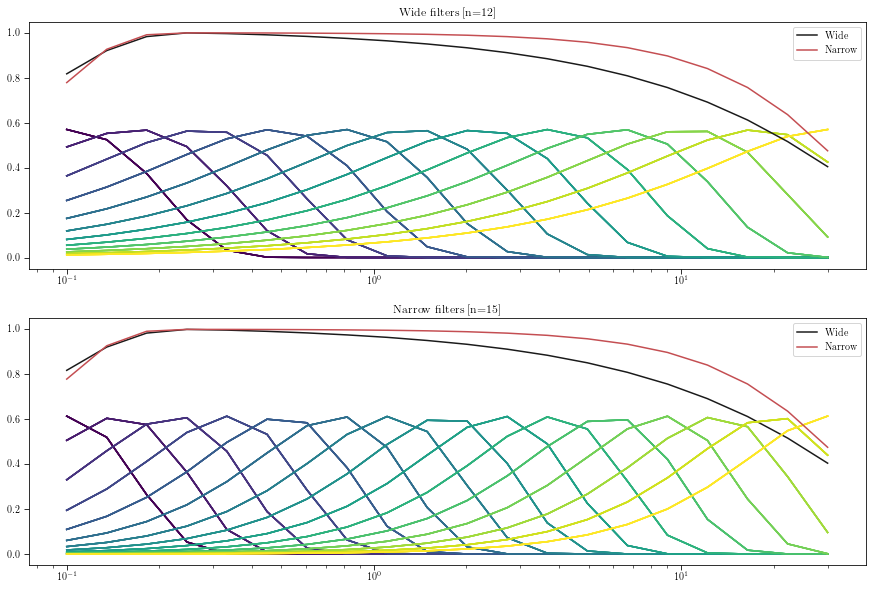

In [5073]:
f, ax = plt.subplots(2, 1, figsize=(15,10));

ttls = ['Wide', 'Narrow']
clrs = ['k', 'r']
sf_dig = 3;
# sf_dig = 1;

# NOTE: Igorning final two gratins because they introduce small differences that are annoying to round out...
# ..... doesn't affect the results in anyway
all_sfs = np.unique(np.round(stimSf[:,0:5], sf_dig))
# all_sfs = np.unique(stimSf);
nStimComp = wide.shape[1];

for use_narrow, ttl, clr in zip(range(2), ttls, clrs):
    
    curr_bank = narrow if use_narrow else wide;
    nFilt = curr_bank.shape[0] # was -1 earlier
    clrs = cm.viridis(np.linspace(0,1,nFilt));
    
    overall_sum = np.zeros((len(all_sfs),))
    overall_count = np.zeros((len(all_sfs),))
    
    for filt in range(nFilt):
        use_wide = True;

        for stimComp in range(5):

            sfs, unq_inds = np.unique(np.round(stimSf[:, stimComp], sf_dig), return_index=True);
            
#             ax[use_narrow].scatter(stimSf[:, stimComp], curr_bank[:, stimComp, filt], color=clrs[filt])
            ax[use_narrow].plot(sfs, curr_bank[filt, unq_inds, stimComp], color=clrs[filt])
            # below is before transpose
#             ax[use_narrow].plot(sfs, curr_bank[unq_inds, stimComp, filt], color=clrs[filt])

            curr_sf_inds = np.where(np.in1d(all_sfs, sfs))[0];
            overall_sum[curr_sf_inds] += curr_bank[filt, unq_inds, stimComp].detach().numpy();
#             overall_sum[curr_sf_inds] += curr_bank[unq_inds, stimComp, filt].detach().numpy();
            overall_count[curr_sf_inds] += 1
            
            ax[use_narrow].set_xscale('log');
        
    avg_tuning = overall_sum/overall_count;
    [ax[i].plot(all_sfs, avg_tuning/np.max(avg_tuning), color=clr, label='%s' % ttl) 
     for i in range(2)]
    ax[use_narrow].set_title('%s filters [n=%d]' % (ttl, nFilt));

for i in range(2):
    ax[i].legend();

The above is with NO LGN; below is with LGN (all parvo)

In [5110]:
selSf, stimSf = model.FullNormResp(dw.trInf, debugFilters=True);
wide = selSf[0:model.normFull['nFilters'][0]]
narrow = selSf[model.normFull['nFilters'][0]:]

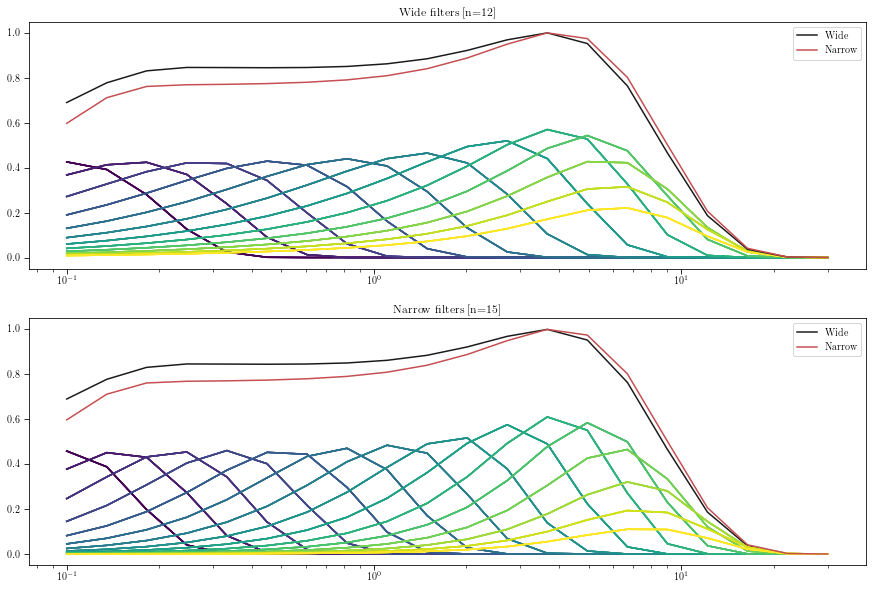

In [5111]:
f, ax = plt.subplots(2, 1, figsize=(15,10));

ttls = ['Wide', 'Narrow']
clrs = ['k', 'r']
sf_dig = 3;
# sf_dig = 1;

# NOTE: Igorning final two gratins because they introduce small differences that are annoying to round out...
# ..... doesn't affect the results in anyway
all_sfs = np.unique(np.round(stimSf[:,0:5], sf_dig))
# all_sfs = np.unique(stimSf);
nStimComp = wide.shape[1];

for use_narrow, ttl, clr in zip(range(2), ttls, clrs):
    
    curr_bank = narrow if use_narrow else wide;
    nFilt = curr_bank.shape[0] # was -1 earlier
    clrs = cm.viridis(np.linspace(0,1,nFilt));
    
    overall_sum = np.zeros((len(all_sfs),))
    overall_count = np.zeros((len(all_sfs),))
    
    for filt in range(nFilt):
        use_wide = True;

        for stimComp in range(5):

            sfs, unq_inds = np.unique(np.round(stimSf[:, stimComp], sf_dig), return_index=True);
            
#             ax[use_narrow].scatter(stimSf[:, stimComp], curr_bank[:, stimComp, filt], color=clrs[filt])
            ax[use_narrow].plot(sfs, curr_bank[filt, unq_inds, stimComp], color=clrs[filt])
            # below is before transpose
#             ax[use_narrow].plot(sfs, curr_bank[unq_inds, stimComp, filt], color=clrs[filt])

            curr_sf_inds = np.where(np.in1d(all_sfs, sfs))[0];
            overall_sum[curr_sf_inds] += curr_bank[filt, unq_inds, stimComp].detach().numpy();
#             overall_sum[curr_sf_inds] += curr_bank[unq_inds, stimComp, filt].detach().numpy();
            overall_count[curr_sf_inds] += 1
            
            ax[use_narrow].set_xscale('log');
        
    avg_tuning = overall_sum/overall_count;
    [ax[i].plot(all_sfs, avg_tuning/np.max(avg_tuning), color=clr, label='%s' % ttl) 
     for i in range(2)]
    ax[use_narrow].set_title('%s filters [n=%d]' % (ttl, nFilt));

for i in range(2):
    ax[i].legend();

### 3.2 Temporal dynamics

In [5313]:
dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd)
mod_resps = model.forward(dw.trInf, respMeasure=respMeasure, 
                              sigmoidSigma=sigmoidSigma, recenter_norm=recenter_norm).detach().numpy()

sings = np.where(dw.trInf['con'][:,0]==1)[0] # full contrast, single grats


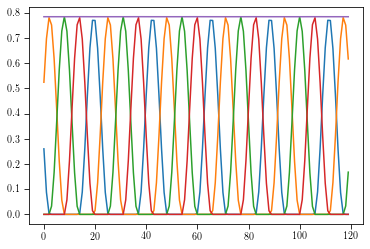

In [5297]:
quadA, quadB, quadC, quadD = model.FullNormResp(dw.trInf, debugQuadrature=True);
# each quadrature set is nFilt x nTr x nFr
tr = sings[62];
filt = 4;

for quad in [quadA, quadB, quadC, quadD]:
    plt.plot(quad[filt, tr])
    
together = quadA+quadB+quadC+quadD
plt.plot(together[filt,tr])

In [5283]:
dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd)
rComplex = model.FullNormResp(dw.trInf, debugFilterTemporal=True);
# rComplex is [nFilt x nTr x nFrames x 2]
nFilt, nTr, nFr = rComplex.shape

In [5284]:
sings = np.where(dw.trInf['con'][:,0]==1)[0] # full contrast, single grats
mix3 = np.where(np.logical_and(dw.trInf['con'][:,2]>0, dw.trInf['con'][:,3]==0))[0] # full contrast, single grats

sing_sfs = dw.trInf['sf'][sings,0] 

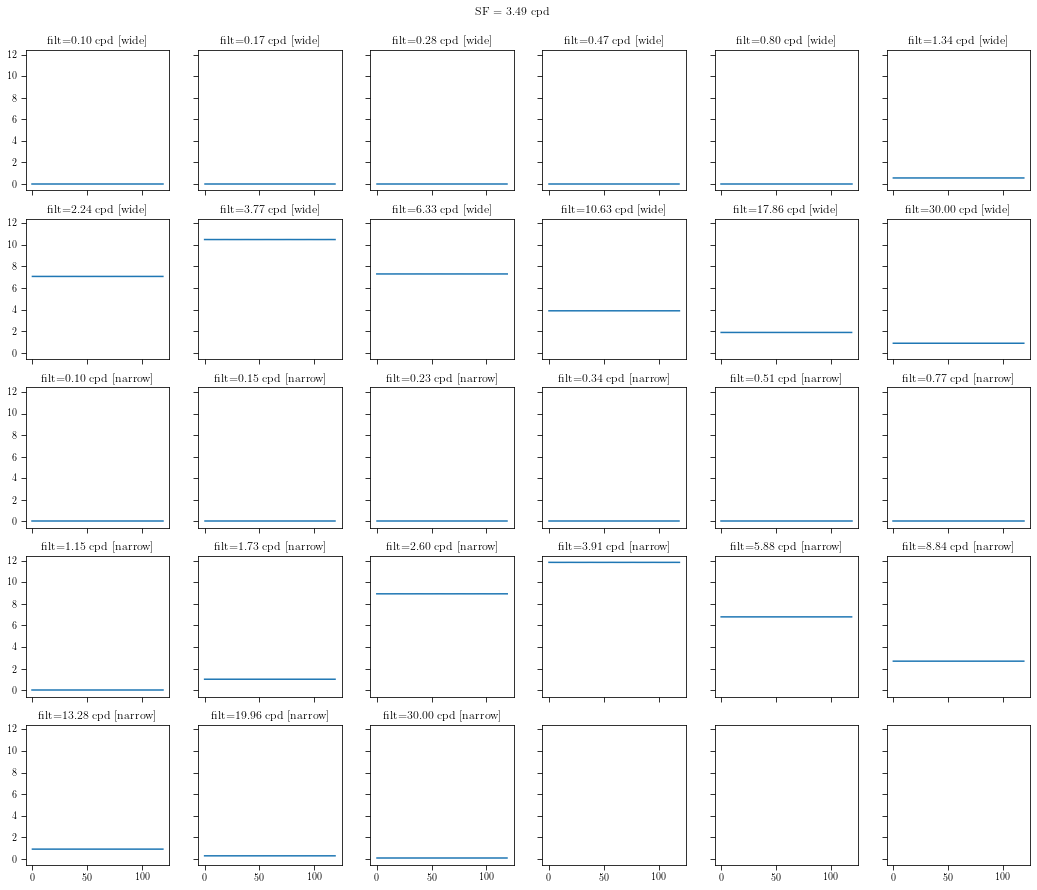

In [5285]:
# single SFs
nrow = int(np.round(np.sqrt(nFilt)))
ncol = int(np.ceil(nFilt/nrow))

f, ax = plt.subplots(nrow, ncol,figsize=(3*ncol, 3*nrow), sharex=True, sharey=True);

curr_tr = np.random.permutation(sings)[0];
first_bank_n = model.normFull['nFilters'][0];

bands = ['wide', 'narrow']

for f_i in range(nFilt):
    
    curr_col, curr_row = np.mod(f_i, ncol), int(np.floor(f_i/ncol));
    
    ax[curr_row, curr_col].plot(rComplex[f_i, curr_tr, :])

    which_bank = int(f_i>=first_bank_n);
    curr_bank_n = model.normFull['nFilters'][which_bank]
    which_filt = int(np.mod(f_i-which_bank*first_bank_n, curr_bank_n))
#     print('%d: bank %d, filt %d (of %d) (col,row=%d,%d)' % (f_i, which_bank, which_filt, curr_bank_n, curr_col, curr_row))
    filt_pref = model.normFull['prefSfs'][which_bank][which_filt]
    
    ax[curr_row, curr_col].set_title('filt=%.2f cpd [%s]' % (filt_pref, bands[which_bank]))
    
f.suptitle('SF = %.2f cpd' % dw.trInf['sf'][curr_tr, 0], y=0.92);

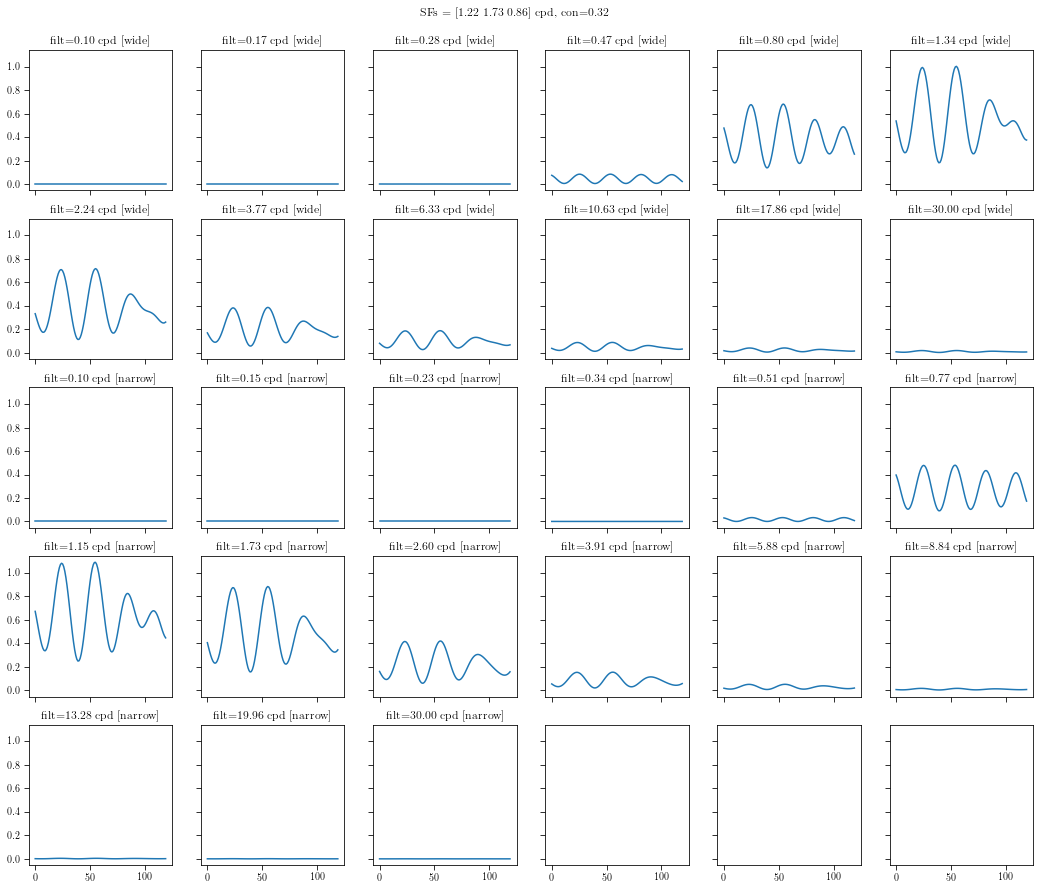

In [5286]:
# 3mix
nrow = int(np.round(np.sqrt(nFilt)))
ncol = int(np.ceil(nFilt/nrow))

f, ax = plt.subplots(nrow, ncol,figsize=(3*ncol, 3*nrow), sharex=True, sharey=True);

curr_tr = np.random.permutation(mix3)[0];
first_bank_n = model.normFull['nFilters'][0];

bands = ['wide', 'narrow']

for f_i in range(nFilt):
    
    curr_col, curr_row = np.mod(f_i, ncol), int(np.floor(f_i/ncol));
    
    ax[curr_row, curr_col].plot(rComplex[f_i, curr_tr, :])

    which_bank = int(f_i>=first_bank_n);
    curr_bank_n = model.normFull['nFilters'][which_bank]
    which_filt = int(np.mod(f_i-which_bank*first_bank_n, curr_bank_n))
#     print('%d: bank %d, filt %d (of %d) (col,row=%d,%d)' % (f_i, which_bank, which_filt, curr_bank_n, curr_col, curr_row))
    filt_pref = model.normFull['prefSfs'][which_bank][which_filt]
    
    ax[curr_row, curr_col].set_title('filt=%.2f cpd [%s]' % (filt_pref, bands[which_bank]))
    
total_con = np.sum(dw.trInf['con'][curr_tr].detach().numpy())
f.suptitle('SFs = %s cpd, con=%.2f' % (np.array2string(dw.trInf['sf'][curr_tr, 0:3].detach().numpy(), precision=2), total_con), y=0.92);

### 3.3 Quadrature

In [5345]:
mod_resps = model.forward(dw.trInf, respMeasure=respMeasure, 
                              sigmoidSigma=sigmoidSigma, recenter_norm=recenter_norm).detach().numpy()

In [5346]:
aa,bb,cc,dd = model.FullNormResp(dw.trInf, debugQuadrature=True);
aa = aa.detach().numpy();
bb = bb.detach().numpy();
cc = cc.detach().numpy();
dd = dd.detach().numpy();

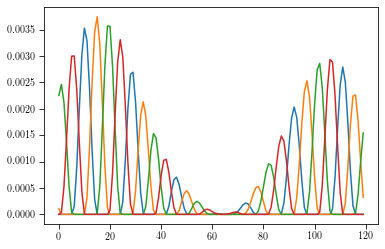

In [5347]:
# proper div?
plt.plot(aa[sings[0], 0, :]);
plt.plot(bb[sings[0], 0, :]);
plt.plot(cc[sings[0], 0, :]);
plt.plot(dd[sings[0], 0, :]);

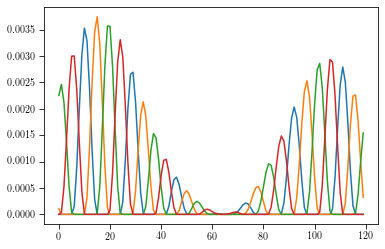

In [5342]:
# only 1 div....
plt.plot(aa[sings[0], 0, :]);
plt.plot(bb[sings[0], 0, :]);
plt.plot(cc[sings[0], 0, :]);
plt.plot(dd[sings[0], 0, :]);

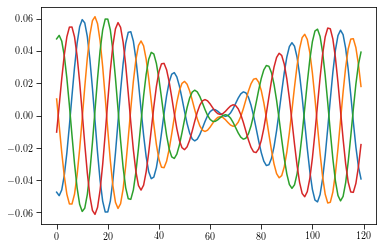

In [5316]:
plt.plot(aa[sings[0], 0, :]);
plt.plot(bb[sings[0], 0, :]);
plt.plot(cc[sings[0], 0, :]);
plt.plot(dd[sings[0], 0, :]);

In [5287]:
aa,bb,cc,dd = model.FullNormResp(dw.trInf, debugQuadrature=True);
aa = aa.detach().numpy();
bb = bb.detach().numpy();
cc = cc.detach().numpy();
dd = dd.detach().numpy();

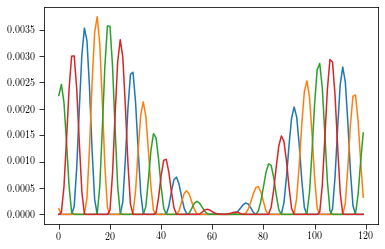

In [5288]:
plt.plot(aa[sings[0], 0, :]);
plt.plot(bb[sings[0], 0, :]);
plt.plot(cc[sings[0], 0, :]);
plt.plot(dd[sings[0], 0, :]);

In [5289]:
oy = model.FullNormResp(dw.trInf);

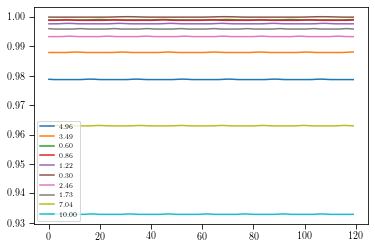

In [5290]:
for i in range(10):
#     plt.axhline(np.mean(oy[mix3[i], :].detach().numpy()), label='%.2f' % (dw.trInf['sf'][sings[i],0]));
#     plt.axhline(np.mean(oy[sings[i], :].detach().numpy()), label='%.2f cpd' % (dw.trInf['sf'][sings[i],0]));
    plt.plot(oy[sings[i], :].detach().numpy(), label='%.2f' % (dw.trInf['sf'][sings[i],0]));

# plt.ylim([0, 0.2]);
plt.legend(fontsize='x-small');

### 3.4 Changing the filter width/number?

In [6465]:
autoreload.reload(mrpt); autoreload.reload(hf);

In [6470]:
mod_fit = 'altExp/structures/fitList_pyt_nr221029c_noRE_LGN_dG_flat_sqrt.npy'
mod_fit = hf.np_smart_load(mod_fit);
mod_prms = mod_fit[3]['dc']['params']

expDir_norm = 'altExp/' # just for this

excType = 1
lgnFrontOn = 0;
# lgnFrontOn = 1;
lgnConType = 4; # all parvo
fitType = 1;

### Load data (to use for vExp calc.)
data_loc = base_dir + '%sstructures/' % expDir_norm
expName = hf.get_datalist(expDir_norm, force_full=True);
dataList = hf.np_smart_load(str(data_loc + expName))
expInd   = hf.exp_name_to_ind(dataList['expType'][cellNum-1]);

expData = hf.np_smart_load(data_loc + '%s_sfm.npy' % dataList['unitName'][cellNum-1])
trialInf = expData['sfm']['exp']['trial']



In [2736]:
def plot_norm_pool(mod_prms, trialInf, expInd, nFilts=[12,15], dord=[0.75, 1.5], respMeasure=0):
    
    model = mrpt.sfNormMod(mod_prms, expInd=expInd, excType=excType, normType=fitType, 
                       lossType=lossType, lgnFrontEnd=lgnFrontOn, newMethod=1, 
                       lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, normToOne=normToOne, norm_nFilters=nFilts, norm_dOrd=dord)

    dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd)

    # make artificial SFs for sampling tuning (n=20 to fit evenly into 1660)
    sfs_test = np.geomspace(0.1,30,20);
    nTr = dw.trInf['sf'].shape[0]
    sfs_tile = np.repeat(sfs_test, nTr/len(sfs_test))
    dw.trInf['sf'] = np.tile(np.expand_dims(sfs_tile, 1), 7);
    dw.trInf['con'] = np.tile(np.expand_dims(np.ones_like(sfs_tile), 1), 7)
    
    mod_resps = model.forward(dw.trInf, respMeasure=respMeasure).detach().numpy()
    
    selSf, stimSf = model.FullNormResp(dw.trInf, debugFilters=True);
    wide = selSf[0:model.normFull['nFilters'][0]]
    narrow = selSf[model.normFull['nFilters'][0]:]
    
    ### NOW PLOT
    f, ax = plt.subplots(2, 1, figsize=(15,10));

    ttls = ['Wide', 'Narrow']
    clrs = ['k', 'r']
    sf_dig = 3;
    # sf_dig = 1;

    # NOTE: Igorning final two gratins because they introduce small differences that are annoying to round out...
    # ..... doesn't affect the results in anyway
    all_sfs = np.unique(np.round(stimSf[:,0:5], sf_dig))
    # all_sfs = np.unique(stimSf);
    nStimComp = wide.shape[1];

    for use_narrow, ttl, clr in zip(range(2), ttls, clrs):

        curr_bank = narrow if use_narrow else wide;
        nFilt = curr_bank.shape[0] # was -1 earlier
        clrs = cm.viridis(np.linspace(0,1,nFilt));

        overall_sum = np.zeros((len(all_sfs),))
        overall_count = np.zeros((len(all_sfs),))

        for filt in range(nFilt):
            use_wide = True;

            for stimComp in range(5):

                sfs, unq_inds = np.unique(np.round(stimSf[:, stimComp], sf_dig), return_index=True);

                ax[use_narrow].plot(sfs, curr_bank[filt, unq_inds, stimComp].detach().numpy(), color=clrs[filt])

                curr_sf_inds = np.where(np.in1d(all_sfs, sfs))[0];
                overall_sum[curr_sf_inds] += curr_bank[filt, unq_inds, stimComp].detach().numpy();
                overall_count[curr_sf_inds] += 1

                ax[use_narrow].set_xscale('log');

        avg_tuning = overall_sum/overall_count;
        [ax[i].plot(all_sfs, avg_tuning/np.max(avg_tuning), color=clr, label='%s' % ttl) for i in range(2)]
        dOrd = model.normFull['dOrd'][use_narrow]
        ax[use_narrow].set_title('%s filters [n=%d, dOrd=%.2f]' % (ttl, nFilt, dOrd));

    for i in range(2):
        ax[i].legend();

    return f;

##### Before anything, let's understand the mapping between deriv. order and banwidth:

In [6472]:
autoreload.reload(hf);

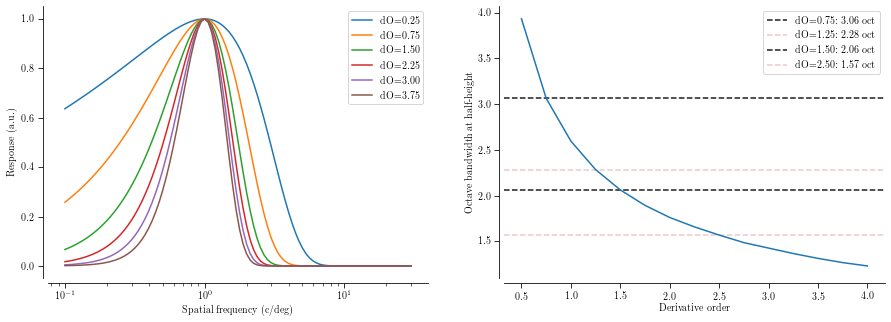

In [2792]:
saveName = '03_04_dG_bandwidth.pdf'

stimSf = np.geomspace(0.1, 30, 100);

prefSf = 1;
dOrd = np.arange(0.25, 4.25, 0.25);

f, ax = plt.subplots(1, 2, figsize=(15,5));

all_bws = []; # in octaves at half-height

for i, dOrd_curr in enumerate(dOrd):

    curr_fit = hf.deriv_gauss([prefSf, dOrd_curr], stimSf = stimSf)[0];
    if np.mod(i,3)==2 or i==0:
        ax[0].semilogx(stimSf, curr_fit, label='dO=%.2f' % dOrd_curr);
        
    # now, compute BW
    curr_bw = hf.compute_SF_BW([prefSf, dOrd_curr], height=0.5, sf_range=[stimSf[0], stimSf[-1]], sfMod=-1)[1]
    all_bws.append(curr_bw);
    
    if dOrd_curr == 0.75 or dOrd_curr == 1.5: # i.e. the default values
        ax[1].axhline(curr_bw, label='dO=%.2f: %.2f oct' % (dOrd_curr, curr_bw), color='k', linestyle='--')
    if dOrd_curr == 1.25 or dOrd_curr == 2.5: # i.e. the default values
        ax[1].axhline(curr_bw, label='dO=%.2f: %.2f oct' % (dOrd_curr, curr_bw), color='r', linestyle='--', alpha=0.3)
    
ax[1].plot(dOrd, all_bws);
# labels
ax[1].set_xlabel('Derivative order');
ax[1].set_ylabel('Octave bandwidth at half-height');
ax[1].legend();
# --
ax[0].set_xlabel('Spatial frequency (c/deg)');
ax[0].set_ylabel('Response (a.u.)');
ax[0].legend();

sns.despine(offset=5);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()


_Thus, the standard filters span about 3 (deriv. order = 0.75) and 2 (1.5) octaves, respectively_


##### Now, look at influence of number and width of filters:

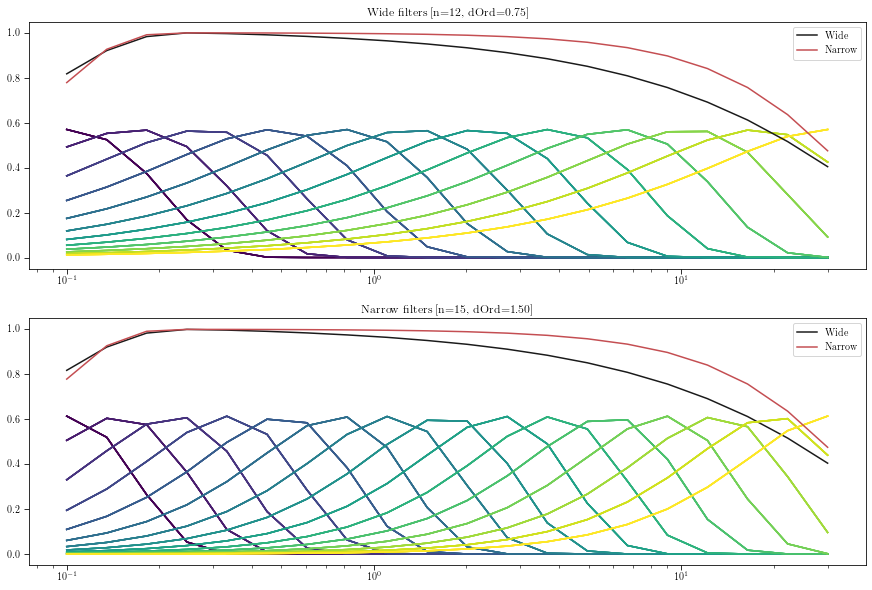

In [6473]:
saveName = '03_04a_normPool_default.pdf'

ah = plot_norm_pool(mod_prms, trialInf, expInd); # default

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf();
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

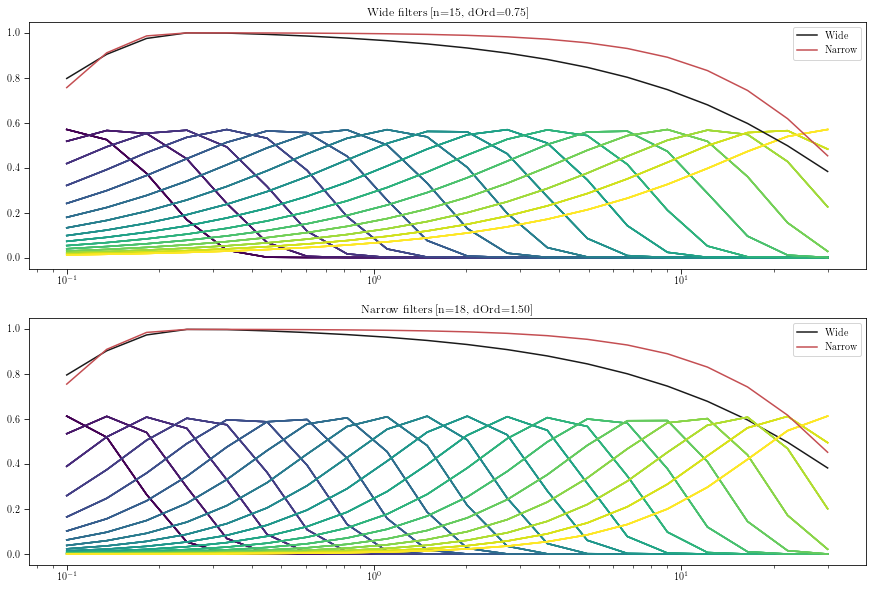

In [6475]:
saveName = '03_04b_normPool_moreFilt.pdf'

# more filters
ah = plot_norm_pool(mod_prms, trialInf, expInd, nFilts=[15, 18]);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf();
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

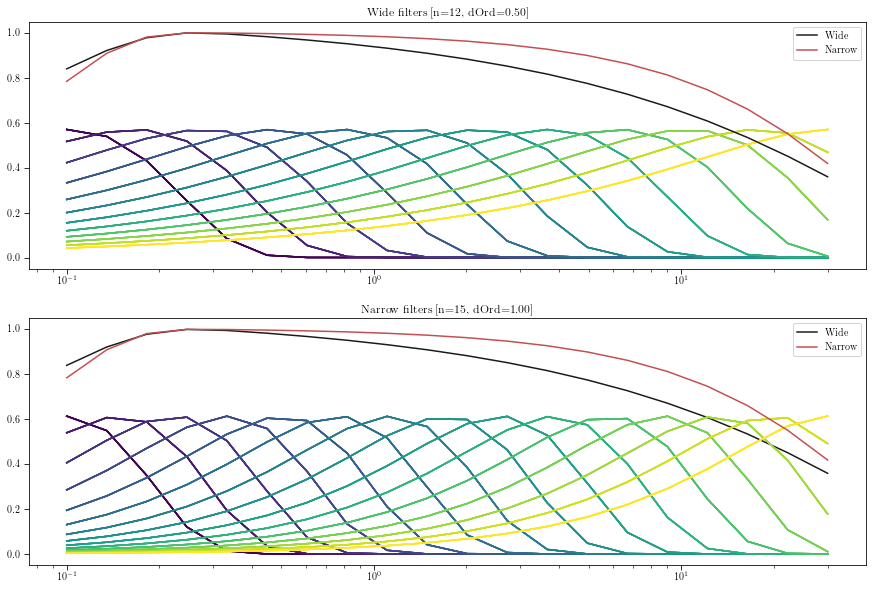

In [6476]:
saveName = '03_04c_normPool_widerFilt.pdf'

# wider filters
ah = plot_norm_pool(mod_prms, trialInf, expInd, dord=[0.5, 1]);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf();
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

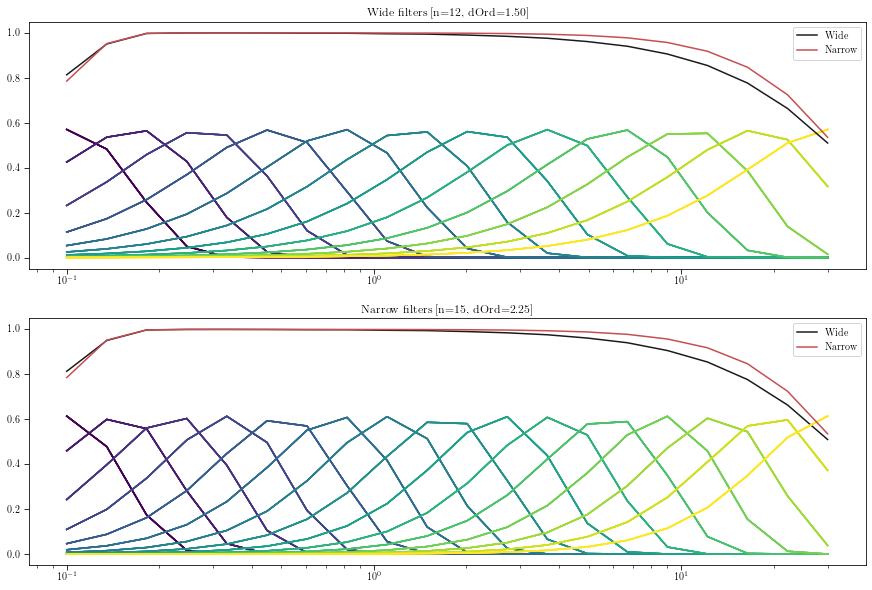

In [6477]:
saveName = '03_04d_normPool_narrowerFilt.pdf'

# narrow filters
ah = plot_norm_pool(mod_prms, trialInf, expInd, dord=[1.5, 2.25]);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf();
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

Seems that once we're overcomplete, adding more filters or making them wider doesn't ruin "smoothness"

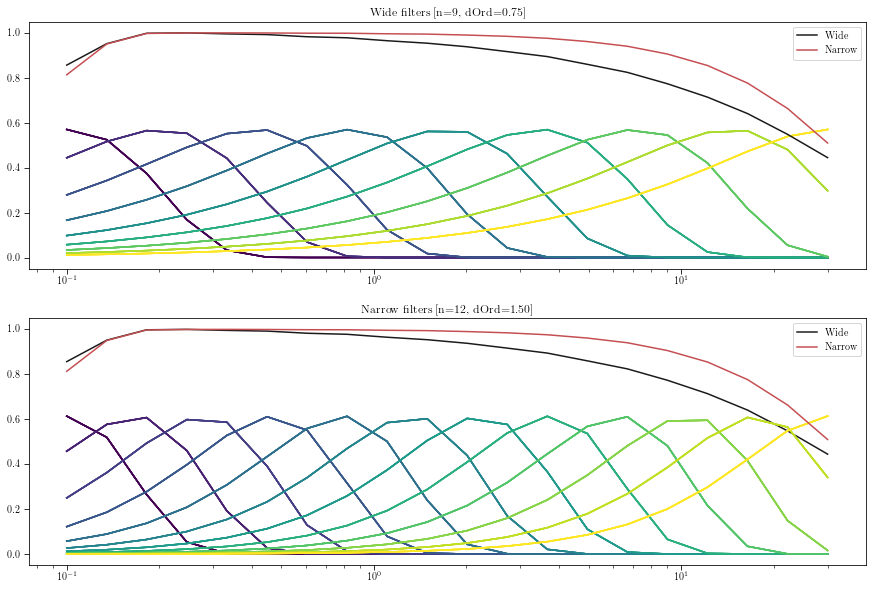

In [6478]:
saveName = '03_04e_normPool_fewerFilt.pdf'

# fewer
ah = plot_norm_pool(mod_prms, trialInf, expInd, nFilts=[9, 12]); # 3 fewer in each bank

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf();
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

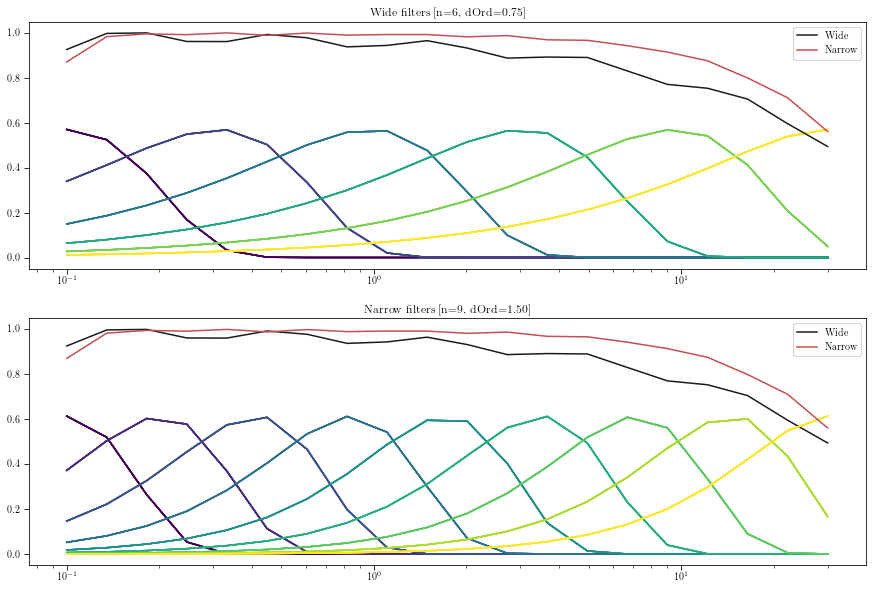

In [6479]:
saveName = '03_04f_normPool_EvenFewerFilt.pdf'

# even fewer --> wiggles!
ah = plot_norm_pool(mod_prms, trialInf, expInd, nFilts=[6, 9]); # 6 fewer in each bank

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf();
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

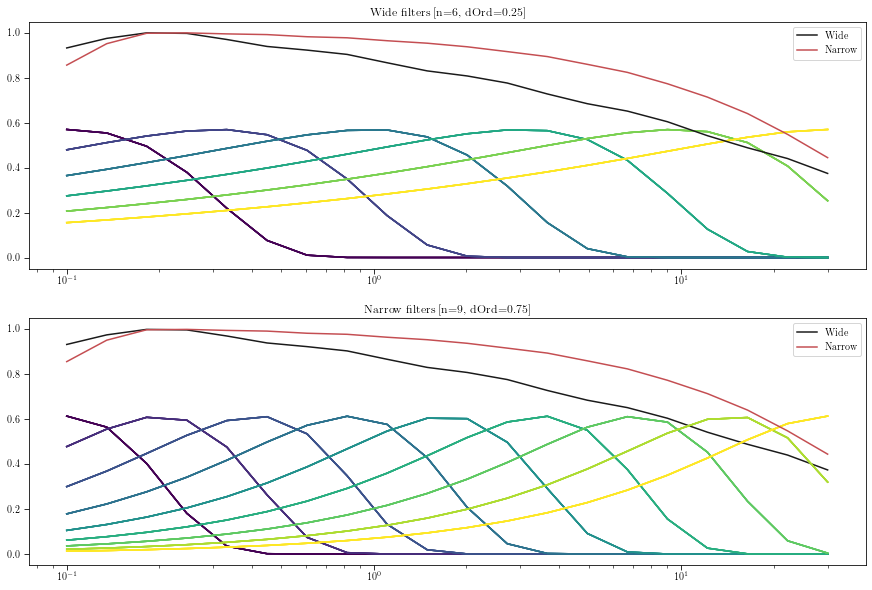

In [6480]:
saveName = '03_04g_normPool_EvenFewerWiderFilt.pdf'

# even fewer, but slightly wider?
ah = plot_norm_pool(mod_prms, trialInf, expInd, nFilts=[6, 9], dord=[0.25, 0.75]); # 6 fewer in each bank

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf();
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

**Takeaway**: It seems that Robbe (with T+E) pretty carefully chose the normalization pool to tile the space and be "smooth" across frequency. We can add more filters or make them wider (or even slightly narrow), but reducing the number of filters pretty quickly results in uneven tuning! Furthermore, the filters are already 2 and 3 octaves, respectively for narrow and wide --> making any changes to even wider filters unrealistic!

### 3.5 Ensuring good initialization

With all of the model variations, we have to ensure that our initializations are good!

#### 3.5.1 Check normalization steps:
How different are the results if we remove the normalizations? Now that we've made the normalization pool the same calculation step(s) as the excitatory filter, it might not be as necessary.

In [6930]:
autoreload.reload(mrpt); autoreload.reload(hf);

In [6931]:
cellNum = 25
expDir = 'V1_orig/'
respMeasure = 0; # dc [0] or f1 [1]

### Load data (to use for vExp calc.)
data_loc = base_dir + '%sstructures/' % expDir
expName = hf.get_datalist(expDir, force_full=True);
dataList = hf.np_smart_load(str(data_loc + expName))
expInd   = hf.exp_name_to_ind(dataList['expType'][cellNum-1]);

if respMeasure == 1:
    rvcName = 'rvcFitsHPC_220928'
    rvcFits = hf.get_rvc_fits(data_loc, expInd, cellNum, rvcName=rvcName, rvcMod=1, direc=1, vecF1=0);
    get_adj_spikes = hf.get_adjusted_spikerate(trialInf, cellNum, expInd, data_loc, rvcName=rvcFits, rvcMod=-1, 
                                               baseline_sub=False, return_measure=False, vecF1=0, force_f1=True, returnByComp=True)

expData = hf.np_smart_load(data_loc + '%s_sfm.npy' % dataList['unitName'][cellNum-1])
trialInf = expData['sfm']['exp']['trial']
respOverwrite = None if respMeasure==0 else get_adj_spikes;

spikes_rate = hf.get_adjusted_spikerate(expData['sfm']['exp']['trial'], cellNum, expInd, data_loc, rvcName=rvcName, rvcMod=1, force_dc=True if respMeasure==0 else False, baseline_sub=False)
_, _, expByCond, _ = hf.organize_resp(spikes_rate, trialInf, expInd, respsAsRate=False);

In [6933]:
normToOne

True

In [6937]:
# mod_fit = '%sstructures/fitListHPC_pyt_nr221031d_noRE_LGN_dG_flat_sqrt.npy' % expDir
# mod_fit = '%sstructures/fitListHPC_pyt_nr221031d_noRE_dG_flat_sqrt.npy' % expDir
mod_fit = '%sstructures/fitListHPC_pyt_nr221119b_noRE_noSched_CV_dG_flat_sqrt.npy' % expDir
kfold = 0;
# kfold = None;

mod_fit = hf.np_smart_load(mod_fit);
mod_prms = mod_fit[cellNum-1]['dc']['params']
if kfold is not None:
    mod_prms = mod_prms[kfold]


excType = 1
lgnFrontOn = 0;
# lgnFrontOn = 1;
_LGNforNorm = 1; # yes, LGN applies to norm. pool, too
lgnConType = 1;
fixRespExp = 2;
fitType = 1; # i.e. asym [0], flat [1], wght [2]

init_prms = mrpt.setModel(cellNum, expDir=expDir, excType=excType, lossType=lossType, fitType=fitType, 
                          lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm,
                          fixRespExp=fixRespExp, respMeasure=respMeasure, normToOne=True,
                          newMethod=1, vecCorrected=0, initFromCurr=0, returnOnlyInits=True)


model = mrpt.sfNormMod(mod_prms, expInd=expInd, excType=excType, normType=fitType, 
                   lossType=lossType, lgnFrontEnd=lgnFrontOn, newMethod=1, toFit=False,
                   lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, normToOne=normToOne)

model_init = mrpt.sfNormMod(init_prms, expInd=expInd, excType=excType, normType=fitType, 
                   lossType=lossType, lgnFrontEnd=lgnFrontOn, newMethod=1, toFit=False,
                   lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, normToOne=normToOne)

dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd)



FitList: fitList_pyt_nr221119b_noRE_dG_flat_sqrt.npy [expDir is V1_orig/]
loading data structure from /arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/V1_orig/structures/...
expInd is 1
respMeasure, vecCorrected: 0, 0
prefSf: 6.10

********MODEL PARAMETERS********
prefSf: 5.80
deriv. order: 1.02
No LGN!
scalar|early|late: 0.014|-0.001|1.452
norm. const.: -1.50
********END OF MODEL PARAMETERS********



##### First, with filter normalizations

In [6938]:
_, vExp_init, mod_resps_init = get_vExp_mod(expByCond, model_init, dw, expInd, respMeasure=respMeasure, returnAll=True)
_, vExp, mod_resps = get_vExp_mod(expByCond, model, dw, expInd, respMeasure=respMeasure, returnAll=True)


In [6939]:
####
# This cell is for plotting just high contrast condition
####

# f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4));

# ax[0].plot(mod_resps_init[0,:,-1], 'k--');
# ax[0].plot(expByCond[0,:,-1], 'o');
# ax[0].set_title('Initial params (vE=%.2f)' % (vExp_init[0,-1]));

# ax[1].plot(mod_resps[0,:,-1], 'k--');
# ax[1].plot(expByCond[0,:,-1], 'o');
# ax[1].set_title('Opt. params (vE=%.2f)' % (vExp[0,-1]));

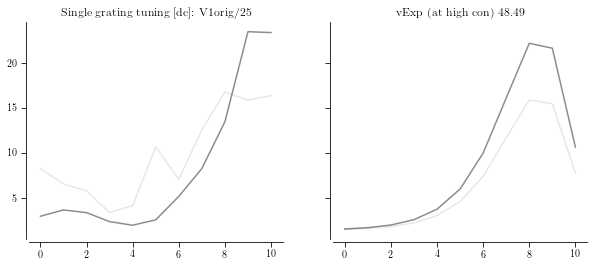

In [6940]:
f, ax = plt.subplots(1,2,figsize=(10,4), sharey=True, sharex=True)

# data
[ax[0].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(expByCond[0]))]
ax[0].set_title('Single grating tuning [%s]: %s/%02d' % ('dc' if respMeasure==0 else 'f1', expDir.replace('/', '').replace('_', ''), cellNum));

# model
[ax[1].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(mod_resps_init[0]))]
ax[1].set_title('vExp (at high con) %.2f' % vExp_init[0,-1]);

sns.despine(offset=3)

##### Now, without filter normalizations

In [6941]:
autoreload.reload(mrpt); autoreload.reload(hf);

In [6942]:
init_prms = mrpt.setModel(cellNum, expDir=expDir, excType=excType, lossType=lossType, fitType=fitType, 
                          lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm,
                          fixRespExp=fixRespExp, respMeasure=respMeasure, normToOne=True, normFiltersToOne=False,
                          newMethod=1, vecCorrected=0, initFromCurr=0, returnOnlyInits=True)
init_prms = np.copy(init_prms)

# init_prms[4] /= 750

# if lgnFrontOn:
#     init_prms[4] = init_prms[4]/500

model = mrpt.sfNormMod(mod_prms, expInd=expInd, excType=excType, normType=fitType, 
                   lossType=lossType, lgnFrontEnd=lgnFrontOn, newMethod=1, toFit=False,
                   lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, normToOne=normToOne, normFiltersToOne=False)

model_init = mrpt.sfNormMod(init_prms, expInd=expInd, excType=excType, normType=fitType, 
                   lossType=lossType, lgnFrontEnd=lgnFrontOn, newMethod=1, toFit=False,
                   lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, normToOne=normToOne, normFiltersToOne=False)

dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd, respOverwrite=respOverwrite)


FitList: fitList_pyt_nr221119b_noRE_dG_flat_sqrt.npy [expDir is V1_orig/]
loading data structure from /arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/V1_orig/structures/...
expInd is 1
respMeasure, vecCorrected: 0, 0
prefSf: 6.10

********MODEL PARAMETERS********
prefSf: 5.58
deriv. order: 1.67
No LGN!
scalar|early|late: 0.015|-0.003|2.415
norm. const.: -1.50
********END OF MODEL PARAMETERS********



In [6943]:
_, vExp_init, mod_resps_init = get_vExp_mod(expByCond, model_init, dw, expInd, respMeasure=respMeasure, returnAll=True)
_, vExp, mod_resps = get_vExp_mod(expByCond, model, dw, expInd, respMeasure=respMeasure, returnAll=True)


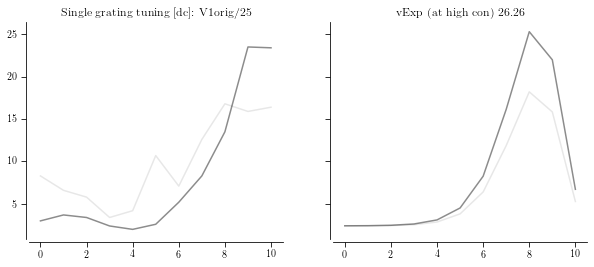

In [6944]:
f, ax = plt.subplots(1,2,figsize=(10,4), sharey=True, sharex=True)

# data
[ax[0].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(expByCond[0]))]
ax[0].set_title('Single grating tuning [%s]: %s/%02d' % ('dc' if respMeasure==0 else 'f1', expDir.replace('/', '').replace('_', ''), cellNum));

# model
[ax[1].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(mod_resps_init[0]))]
ax[1].set_title('vExp (at high con) %.2f' % vExp_init[0,-1]);

sns.despine(offset=3)

All of the below are with DC responses, only:
- No LGN, no tuned norm, the initialization responses are comparable -- that's a good sign! Obviously the optimized parameters are way off, but that's not surprising (they were opt. for a different calculation entirely)  
- No LGN, but tuned norm (norm=2): initializations are comparable (good!)
    - Could stand to make respScalar slighly larger in these cases (~ 1.5x) 
- No LGN, but asym. norm (norm=0): initializations are comparable (good!) 
- With LGN, and no tuning: the normFiltersToOne is fine, but once we get rid of the normalization, it's way off!
    - Move the normConst from -1.5 to +0.5 seems OK
- With LGN, asym --> fine
- With LGN, tuned norm --> same need for ~1.5x on respScalar



### 3.6 Ensuring good initialization for Bauman + Bonds

It seems like we're there for all experiments except for the B+B, and even then, only the F1 seems off. Let's see if we can improve the initialization!


In [1902]:
autoreload.reload(mrpt); autoreload.reload(hf); autoreload.reload(hf_sfBB);

In [1903]:
# fitName = 'fitListHPC_pyt_nr221106a_noSched_dG_flat_sqrt.npy'; # good for F1, cell #4
# fitName = 'fitListHPC_pyt_nr221108a_noSched_dG_flat_sqrt.npy';
# fitName = 'fitListHPC_pyt_nr221109d_noSched_dG_wght_sqrt.npy';
fitName = 'fitListHPC_pyt_nr230104_noRE_noSched_dG_flat_sqrt.npy';

In [1914]:
cellNum = 35
expDir = 'V1_BB/'
respMeasure = 1; # dc [0] or f1 [1]

### Load data (to use for vExp calc.)
data_loc = base_dir + '%sstructures/' % expDir
expName = hf.get_datalist(expDir, force_full=True);
dataList = hf.np_smart_load(str(data_loc + expName))
expInd   = hf.exp_name_to_ind(dataList['expType'][cellNum-1]);
expData = hf.np_smart_load(data_loc + '%s_sfBB.npy' % dataList['unitName'][cellNum-1])
expInfo = expData['sfBB_core'];
trialInf = expInfo['trial']
fitList = hf.np_smart_load('%sstructures/%s' % (expDir, fitName))
respStr = hf_sfBB.get_resp_str(respMeasure)
curr_fit = fitList[cellNum-1][respStr];

if respMeasure == 1:
    _, _, _, maskF1byPhAmp = hf_sfBB.get_mask_resp(expInfo, withBase=0, maskF1=1, vecCorrectedF1=1, returnByTr=1);
    vec_corr_mask, vec_corr_base = hf_sfBB.adjust_f1_byTrial(expInfo, maskF1byPhAmp=maskF1byPhAmp);
    expInfo['f1_mask'] = vec_corr_mask;
    expInfo['f1_base'] = vec_corr_base;

trInf, resp = mrpt.process_data(expInfo, expInd=expInd, respMeasure=respMeasure);
resps_detached = resp.detach().numpy();
# however, this ignores the blanks -- so we have to reconstitute the original order/full experiment, filling in these responses in the correct trial locations                                                                                                            
nTrs_total = expInfo['num'][-1] if expInd != -1 else expInfo['trial']['ori'].shape[-1];
if respMeasure == 1:
    resps_full = np.nan * np.zeros((nTrs_total, 2));
    resps_full[trInf['num']] = resps_detached;
else:
    resps_full = np.nan * np.zeros((nTrs_total, ));
    resps_full[trInf['num']] = resps_detached;
if expInd != -1: # i.e. anything but B+B                                                                                                                                                                                                                                  
    _, _, expByCond, _ = hf.organize_resp(resps_full, expInfo, expInd);
else:
    dcResp, f1Resp = hf_sfBB.get_mask_resp(expInfo, withBase=0, maskF1=1, vecCorrectedF1=0);
    expByCond = dcResp[:,:,0] if respMeasure==0 else f1Resp[:,:,0];
unique_sfs = np.unique(trInf['sf'][:,0])
pref_sf = unique_sfs[np.argmax(expByCond[0,:,-1])] if expInd != -1 else expInfo['baseSF'][0]; # we can just use baseSf           

In [1915]:
maskInd, baseInd = hf_sfBB.get_mask_base_inds();

In [1916]:
excType = 1
lgnFrontOn = 0;
# lgnFrontOn = 1;
_LGNforNorm = 1; # yes, LGN applies to norm. pool, too
lgnConType = 1;
fixRespExp = 2;
fitType = 1; # i.e. asym [0], flat [1], wght [2]

sfbb_vecF1 = 1; # for data, do vecF1 (really phAdj correction...)

# make initial parameters and set up the model so we can run it
init_prms = mrpt.setModel(cellNum, expDir=expDir, excType=excType, lossType=lossType, fitType=fitType, 
                          lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm,
                          fixRespExp=fixRespExp, respMeasure=respMeasure,
                          newMethod=1, vecCorrected=1, initFromCurr=0, returnOnlyInits=True)
init_prms = np.copy(init_prms);
# init_prms[4:7] = curr_fit['params'][4:7]
model_init = mrpt.sfNormMod(init_prms, expInd=expInd, excType=excType, normType=fitType, 
                   lossType=lossType, lgnFrontEnd=lgnFrontOn, newMethod=1, toFit=False,
                   lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, normFiltersToOne=False)

# and load the fit model
fit_model = np.copy(curr_fit['params']);
# fit_model[2] += 1
# fit_model[-2] = np.log(0.5)
# fit_model[-1] = 0
model_fit = mrpt.sfNormMod(fit_model, expInd=expInd, excType=excType, normType=fitType, 
                   lossType=lossType, lgnFrontEnd=lgnFrontOn, newMethod=1, toFit=False,
                   lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, normFiltersToOne=False)

predictions = model_init.forward(trInf, respMeasure=respMeasure).detach().numpy();
predictions_fit = model_fit.forward(trInf, respMeasure=respMeasure).detach().numpy();
nTrs_total = expInfo['num'][-1] if expInd != -1 else expInfo['trial']['ori'].shape[-1];
if respMeasure == 1:
    resps_full = np.nan * np.zeros((nTrs_total, 2));
    resps_full_fit = np.nan * np.zeros((nTrs_total, 2));
else:
    resps_full = np.nan * np.zeros((nTrs_total, ));
    resps_full_fit = np.nan * np.zeros((nTrs_total, ));
resps_full[trInf['num']] = predictions;
resps_full_fit[trInf['num']] = predictions_fit;

dcResp, f1Resp = hf_sfBB.get_mask_resp(expInfo, withBase=0, maskF1=1, vecCorrectedF1=sfbb_vecF1);
dcResp_mod, f1Resp_mod = hf_sfBB.get_mask_resp(expInfo, withBase=0, maskF1=1, vecCorrectedF1=0,
                                       f1_mask=resps_full[:, maskInd], f1_base=resps_full[:, baseInd]);
dcResp_fit, f1Resp_fit = hf_sfBB.get_mask_resp(expInfo, withBase=0, maskF1=1, vecCorrectedF1=0,
                                       f1_mask=resps_full_fit[:, maskInd], f1_base=resps_full_fit[:, baseInd]);

# base only, in the presence of masks
dcResp_base, f1Resp_base = hf_sfBB.get_mask_resp(expInfo, withBase=1, maskF1=0, vecCorrectedF1=sfbb_vecF1);
dcResp_mod_base, f1Resp_mod_base = hf_sfBB.get_mask_resp(expInfo, withBase=1, maskF1=0, vecCorrectedF1=0,
                                       f1_mask=resps_full[:, maskInd], f1_base=resps_full[:, baseInd]);
dcResp_fit_base, f1Resp_fit_base = hf_sfBB.get_mask_resp(expInfo, withBase=1, maskF1=0, vecCorrectedF1=0,
                                       f1_mask=resps_full_fit[:, maskInd], f1_base=resps_full_fit[:, baseInd]);


# zero all non-rel targets
resp[trInf['con'][:,maskInd]==0, maskInd] = 1e-6 # force F1 ~ 0 if con of that stim is 0                                                                                                                                                                    
resp[trInf['con'][:,baseInd]==0, baseInd] = 1e-6 # force F1 ~ 0 if con of that stim is 0                                                                                                                                                                    
predictions[trInf['con'][:,maskInd]==0, maskInd] = 1e-6 # force F1 ~ 0 if con of that stim is 0                                                                                                                                                                       
predictions[trInf['con'][:,baseInd]==0, baseInd] = 1e-6 # force F1 ~ 0 if con of that stim is 0  
predictions_fit[trInf['con'][:,maskInd]==0, maskInd] = 1e-6 # force F1 ~ 0 if con of that stim is 0                                                                                                                                                                       
predictions_fit[trInf['con'][:,baseInd]==0, baseInd] = 1e-6 # force F1 ~ 0 if con of that stim is 0  

loss_init = mrpt.loss_sfNormMod(mrpt._cast_as_tensor(predictions), mrpt._cast_as_tensor(resp), lossType)
loss_fit = mrpt.loss_sfNormMod(mrpt._cast_as_tensor(predictions_fit), mrpt._cast_as_tensor(resp), lossType)


applying LGN to norm? 1 [fitList fitList_pyt_nr230104_noRE_vecF1_dG_flat_sqrt.npy]

FitList: fitList_pyt_nr230104_noRE_vecF1_dG_flat_sqrt.npy [expDir is V1_BB/]
loading data structure from /arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/V1_BB/structures/...
expInd is -1
respMeasure, vecCorrected: 1, 1
prefSf: 0.49 [will initialize at this + some jitter]
aiming for dOrd: 0.29

********MODEL PARAMETERS********
prefSf: 0.70
deriv. order: 0.29
No LGN!
scalar|early|late: 0.016|-0.000|-0.960
norm. const.: -1.25
********END OF MODEL PARAMETERS********



In [1917]:
maskSf, maskCon = expInfo['maskSF'], expInfo['maskCon'];

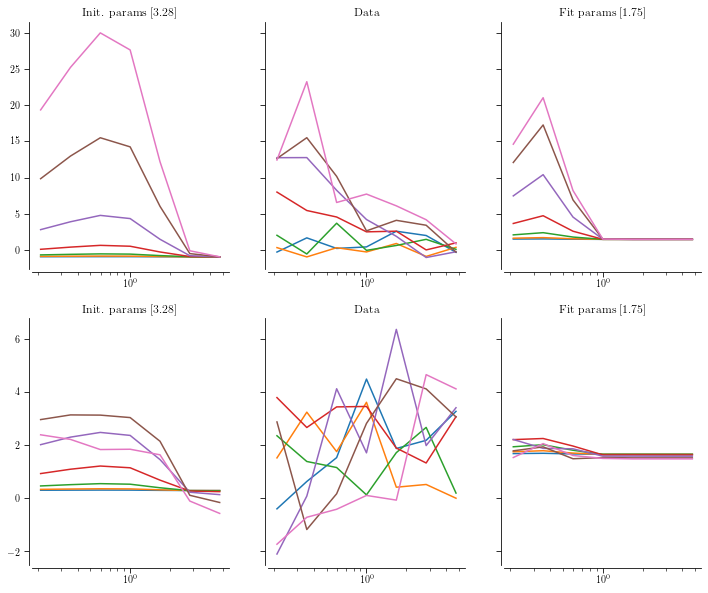

In [1918]:
f, ax = plt.subplots(2, 3, figsize=(12,10), sharey='row');

# first mask only
[ax[0,0].plot(maskSf, f1Resp_mod[i,:,0]) for i in range(7)]

[ax[0,1].plot(maskSf, f1Resp[i,:,0,0]) for i in range(7)]

[ax[0,2].plot(maskSf, f1Resp_fit[i,:,0]) for i in range(7)]

# titles
ax[0,0].set_title('Init. params [%.2f]' % loss_init);
ax[0,1].set_title('Data');
ax[0,2].set_title('Fit params [%.2f]' % loss_fit);

# first base only
[ax[1,0].plot(maskSf, f1Resp_mod_base[i,:,0]) for i in range(7)]

[ax[1,1].plot(maskSf, f1Resp_base[i,:,0,0]) for i in range(7)]

[ax[1,2].plot(maskSf, f1Resp_fit_base[i,:,0]) for i in range(7)]

# titles
ax[1,0].set_title('Init. params [%.2f]' % loss_init);
ax[1,1].set_title('Data');
ax[1,2].set_title('Fit params [%.2f]' % loss_fit);

for i in range(2):
    for j in range(3):
        ax[i,j].set_xscale('log')

sns.despine(offset=3);


In [6722]:
model_fit.normFull['prefSfs']

[tensor([ 0.1000,  0.1680,  0.2821,  0.4738,  0.7957,  1.3365,  2.2447,  3.7701,
          6.3320, 10.6350, 17.8619, 30.0000]),
 tensor([ 0.1000,  0.1503,  0.2259,  0.3395,  0.5102,  0.7668,  1.1525,  1.7321,
          2.6031,  3.9123,  5.8799,  8.8371, 13.2815, 19.9611, 30.0000])]

In [6723]:
gs_std_min = 0.05
filt_sfs = model_fit.normFull['prefSfs'][0]
minWeight = mrpt._cast_as_tensor(0.005)

In [6724]:
log_sfs = torch.log(filt_sfs);
# NOTE: 22.10.31 --> clamp the gs_mean at the 1st/last filters of the 1st bank of filters                                                                                
weight_distr = torch.distributions.normal.Normal(torch.clamp(model_fit.gs_mean, min=torch.log(model_fit.normFull['prefSfs'][0][0]), max=torch.log(model_fit.normFull['prefSfs'][0][-1])), torch.clamp(model_fit.gs_std, min=gs_std_min));
new_weights = torch.clamp(torch.exp(weight_distr.log_prob(log_sfs)), min=minWeight);
avg_weights = new_weights/torch.mean(new_weights); # make avg. weight = 1 


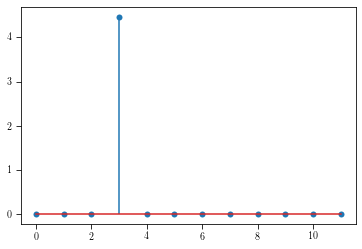

In [6725]:
plt.stem(new_weights.detach().numpy());

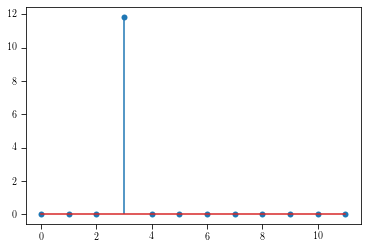

In [6726]:
plt.stem(avg_weights.detach().numpy());

In [6729]:
modRespsDebug = model_fit.forward(trInf, respMeasure=respMeasure, debug=1, normOverwrite=True);
mod_exc, mod_norm, mod_sigma = [modRespsDebug[x].detach().numpy() for x in [0,1,2]]; # returns are exc, inh, sigmaFilt (c50)      

full_exc = mod_exc;
full_denom = mod_sigma + mod_norm;

maskSf, maskCon = expInfo['maskSF'], expInfo['maskCon'];
modTrials = trInf['num'];
conVals = [maskCon[-5], maskCon[-3], maskCon[-1]]

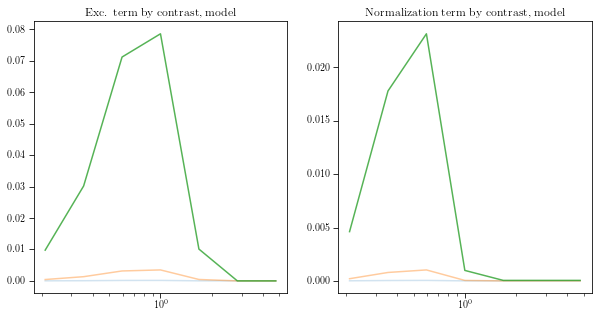

In [6731]:
f, ax = plt.subplots(1, 2, figsize=(10,5));

for cI, conVal in enumerate(conVals):
    closest_ind = np.argmin(np.abs(conVal - maskCon));
    close_enough = np.abs(maskCon[closest_ind] - conVal) < 0.03 # must be within 3% contrast                                                                                       
    if close_enough:
        # highest contrast, first; for all, maskOn [1] and baseOff [0]                                                                                                               
        all_trials = [hf_sfBB.get_valid_trials(expInfo, 1, 0, whichCon=closest_ind, whichSf=sfI)[0] for sfI,_ in enumerate(maskSf)];
        # then, find which corresponding index into model-eval-only trials this is                                                                                                   
        all_trials_modInd = [np.intersect1d(modTrials, trs, return_indices=True)[1] for trs in all_trials];
        # EXC
        mdrsp = [np.mean(full_exc[:, trs]) for trs in all_trials_modInd];
        # -- take sqrt of con val so that it's not SO dim...                                                                                                                         
        ax[0].semilogx(maskSf, mdrsp, alpha=np.sqrt(conVal))
        ax[0].set_title('Exc. term by contrast, model');

        # NORM
        mdrsp = [np.mean(full_denom[:, trs]) for trs in all_trials_modInd];
        # -- take sqrt of con val so that it's not SO dim...                                                                                                                         
        ax[1].semilogx(maskSf, mdrsp, alpha=np.sqrt(conVal))
        ax[1].set_title('Normalization term by contrast, model');


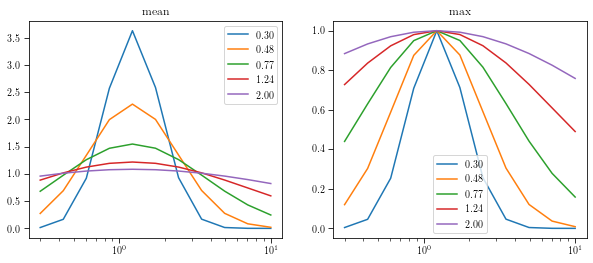

In [6457]:
import torch;
gs_mean = mrpt._cast_as_tensor(0.2);

f, ax = plt.subplots(1,2,figsize=(10,4))

for gs_val in np.geomspace(0.3, 2, 5):
    gs_std = mrpt._cast_as_tensor(gs_val);

    log_sfs = mrpt._cast_as_tensor(np.log(np.geomspace(0.3, 10, 11)))
    weight_distr = torch.distributions.normal.Normal(gs_mean, torch.abs(gs_std))
    
    for i in range(2):
        new_weights = torch.exp(weight_distr.log_prob(log_sfs))
    
        if i == 0:
            new_weights = new_weights/torch.max(mrpt._cast_as_tensor(0.001), torch.mean(new_weights))
        else:
            new_weights = new_weights/torch.max(mrpt._cast_as_tensor(0.001), torch.max(new_weights))
        new_weights = new_weights.detach().numpy();

        ax[i].semilogx(np.exp(log_sfs.detach().numpy()), new_weights, label='%.2f' % gs_val)

for i,ttl in enumerate(['mean', 'max']):
    ax[i].legend();
    ax[i].set_title(ttl);

## 3A. LGN which is yoked to preferred V1 SF
This is *not* a shifting LGN in the sense of different $f_c$ with contrast. However, rather than keeping the same LGN filters for all V1 neurons, we'll allow the LGN filters to be placed depending on the V1 filter.

In this section of the notebook, we'll get a first pass attempt at understanding how to place the LGN $f_c$ based on the V1 preference

In [178]:
v1sf = 1; # V1 preferred SF
# default m & p f_c
m_fc_def = 3
p_fc_def = 9;
# remaining M&P parameters
m_k  = 1
m_ks = 0.3
m_js = 0.4
p_k  = 1
p_ks = 0.5
p_js = 0.4

In [326]:
sfs = np.geomspace(1e-5, 100, 100);
m_resp = hf.DiffOfGauss(m_k, m_fc_def, m_ks, m_js, sfs)[0]
p_resp = hf.DiffOfGauss(p_k, p_fc_def, p_ks, p_js, sfs)[0]
# p_resp = hf.DiffOfGauss(p_k, p_fc_def, m_ks, m_js, sfs)[0]

dogMod = 2; # 2 is the DiffOfGauss parameterization

In [327]:
f_cs = np.geomspace(0.5, 15, 100);
p_psfs = np.array([hf.descr_prefSf([p_k, fc_curr, p_ks, p_js], dogMod, all_sfs=sfs) for fc_curr in f_cs]);
m_psfs = np.array([hf.descr_prefSf([m_k, fc_curr, m_ks, m_js], dogMod, all_sfs=sfs) for fc_curr in f_cs]);

In [328]:
oy_m = ss.linregress(f_cs, m_psfs)
oy_p = ss.linregress(f_cs, p_psfs)

In [329]:
get_eqv_psf_m = lambda fc: oy_m.intercept + fc*oy_m.slope
get_eqv_psf_p = lambda fc: oy_p.intercept + fc*oy_p.slope

In [330]:
lgn_oct_range = np.log2(3)

In [358]:
np.log2(psf_high/psf_low)

2.0129171167380955

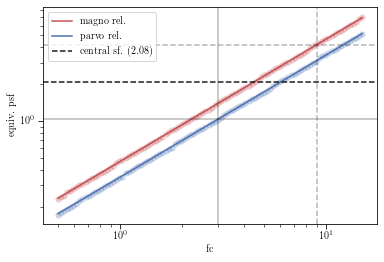

In [359]:
saveName = '03a_01_fc_to_sf.pdf'

# parvo
plt.plot(f_cs, p_psfs, 'ro', alpha=0.3)
plt.plot(f_cs, get_eqv_psf_p(f_cs), 'r-', label='magno rel.')
# parvo
plt.plot(f_cs, m_psfs, 'bo', alpha=0.3)
plt.plot(f_cs, get_eqv_psf_m(f_cs), 'b-', label='parvo rel.')

plt.xlabel('fc');
plt.ylabel('equiv. psf');
plt.axvline(m_fc_def, color='k', linestyle='-', alpha=0.3);
plt.axvline(p_fc_def, color='k', linestyle='--', alpha=0.3);

psf_high = get_eqv_psf_p(p_fc_def)
psf_low  = get_eqv_psf_m(m_fc_def)

# psfs for m/p fc
plt.axhline(psf_high, color='k', linestyle='--', alpha=0.3);
plt.axhline(psf_low, color='k', linestyle='-', alpha=0.3);

prev_mod_psf_center = psf_low * np.power(2, np.log2(psf_high/psf_low)/2)
plt.axhline(prev_mod_psf_center, color='k', linestyle='--', label='central sf. (%.2f)' % prev_mod_psf_center)
plt.xscale('log')
plt.yscale('log')
plt.legend()

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf();
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

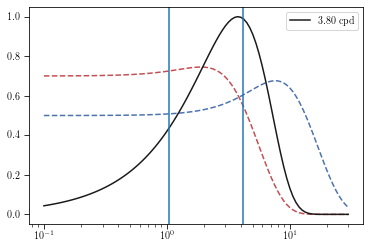

In [360]:
saveName = '03a_02_fc_with_peak_ex.pdf'

plt.semilogx(sfs, m_resp, 'r--');
plt.semilogx(sfs, p_resp, 'b--');
plt.semilogx(sfs, hf.deriv_gauss([equiv_psf, 1], stimSf=sfs)[0], 'k-', label='%.2f cpd' % equiv_psf);
plt.axvline(psf_low)
plt.axvline(psf_high)
plt.legend();

f = plt.gcf();
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

In [361]:
sfs = np.geomspace(0.1, 30, 100)

In [362]:
m_fc_curr = 5.4661
p_fc_curr = 16.3969
m_resp = hf.DiffOfGauss(m_k, m_fc_curr, m_ks, m_js, sfs)[0]
p_resp = hf.DiffOfGauss(p_k, p_fc_curr, p_ks, p_js, sfs)[0]
equiv_psf = 3.7964

psf_high = get_eqv_psf_p(p_fc_curr)
psf_low  = get_eqv_psf_m(m_fc_curr)

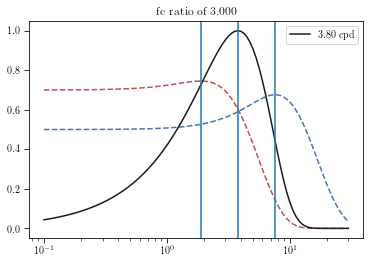

In [363]:
saveName = '03a_03_check_from_real_calc.pdf'


plt.semilogx(sfs, m_resp, 'r--');
plt.semilogx(sfs, p_resp, 'b--');
plt.semilogx(sfs, hf.deriv_gauss([equiv_psf, 1], stimSf=sfs)[0], 'k-', label='%.2f cpd' % equiv_psf);
plt.axvline(psf_high)
plt.axvline(psf_low)
plt.axvline(psf_low * np.power(2, np.log2(psf_high/psf_low)/2))
plt.legend();
plt.title('fc ratio of %.3f' % (p_fc_curr/m_fc_curr));

f = plt.gcf();
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

# 4. Hyperparameters
We tried it earlier (e.g. section 1) but that was before a lot of changes to the model/optimization, plus on a smaller set of data. Here, let's do it properly!



In [939]:
modSpecs = dict();
modSpecs['excType'] = [1,1,1,1]
modSpecs['normType'] = [1,1,2,2]    
modSpecs['lgnType'] = [1,4,1,4]  
modSpecs['nMods'] = 4

fL_name = '%s%s%s' % (fL_base, '_noRE' if fixRespExp is not None else '', '_noSched' if scheduler==False)

In [941]:
from collections.abc import Iterable
can_iter = [isinstance(x, Iterable) for x in modSpecs.values()]
iter_keys = np.array(list(modSpecs.keys()))[can_iter]
iter_subset = {k: modSpecs[k] for k in iter_keys}

modelDict = dict(); # dictionary of each model
for mod_i in range(modSpecs['nMods']):
    aha = hf.fitList_name(fL_name, fitType=modSpecs['normType'][mod_i], 
                         lossType=1, lgnType=modSpecs['lgnType'][mod_i], lgnConType=1,
                         vecCorrected=0, CV=0, excType=modSpecs['excType'][mod_i], lgnForNorm=1)
    print('%d: %s' % (mod_i, aha))
    

0: fitListHPC_pyt_nr230104_noRE_noSched_LGN_dG_flat_sqrt.npy
1: fitListHPC_pyt_nr230104_noRE_noSched_LGNsi_dG_flat_sqrt.npy
2: fitListHPC_pyt_nr230104_noRE_noSched_LGN_dG_wght_sqrt.npy
3: fitListHPC_pyt_nr230104_noRE_noSched_LGNsi_dG_wght_sqrt.npy


##### What hyperparameters and models to compare? Take 1 (coarser)

In [160]:
# hypers
eps = [500, 1000, 2500];
lrs = [0.0005, 0.001, 0.005, 0.01, 0.05];
bs  = [128, 3000];

# model name details
fitDate = '230102';
excType = 1;
lossType = 1;
fitHPC  = 1;
applyLGNtoNorm = 1;
lgnConType = 1
vecCorrected = 0;
todoCV = 1
fixRespExp = 2; # or None?
noSched = True

maxNcell = 20;

loc_str = 'HPC' if fitHPC else '';
fL_name = 'fitList%s_pyt_nr%s%s%s' % (loc_str, fitDate, '_noRE' if fixRespExp is not None else '', '_noSched' if noSched else '');

lgnFrontEnds = [0, 1, 4];
fitTypes = [1,2]; # flat, weighted
expDirs = ['altExp/', 'V1_BB/'];

valid_fit = np.zeros((len(eps), len(lrs), len(bs), len(lgnFrontEnds), len(fitTypes), len(expDirs)));
nll_test_dc = np.nan * np.zeros((maxNcell, len(eps), len(lrs), len(bs), len(lgnFrontEnds), len(fitTypes), len(expDirs)));
nll_train_dc = np.nan * np.zeros_like(nll_test_dc)
nll_test_f1 = np.nan * np.zeros_like(nll_test_dc)
nll_train_f1 = np.nan * np.zeros_like(nll_test_dc)

for (a,b,c,lgnFront,normType),(aInd,bInd,cInd,lInd,nInd) in zip(itertools.product(*(eps,lrs,bs, lgnFrontEnds, fitTypes)), itertools.product(*[range(len(x)) for x in (eps,lrs,bs, lgnFrontEnds, fitTypes)])):
    testingInfo = [a,b,c];

    curr_name = hf.fitList_name(base=fL_name, fitType=normType, lossType=lossType, lgnType=lgnFront, lgnConType=lgnConType, 
                                vecCorrected=vecCorrected, CV=todoCV, excType=excType, 
                    lgnForNorm=applyLGNtoNorm, testingNames=True, testingInfo=testingInfo);
    for i,expDir in enumerate(expDirs):
        try:
            test = hf.np_smart_load('%sstructures/%s' % (expDir, curr_name));
            if len(test.keys()) > 0:
                valid_fit[aInd,bInd,cInd,lInd,nInd,i] = True
                nll_test_dc[0:len(test.keys()), aInd,bInd,cInd,lInd,nInd,i] = [np.nanmean(test[x]['dc']['NLL_test']) for x in test.keys()]
                nll_train_dc[0:len(test.keys()), aInd,bInd,cInd,lInd,nInd,i] = [np.nanmean(test[x]['dc']['NLL_train']) for x in test.keys()]
                nll_test_f1[0:len(test.keys()), aInd,bInd,cInd,lInd,nInd,i] = [np.nanmean(test[x]['f1']['NLL_test']) for x in test.keys()]
                nll_train_f1[0:len(test.keys()), aInd,bInd,cInd,lInd,nInd,i] = [np.nanmean(test[x]['f1']['NLL_train']) for x in test.keys()]
        except:
            pass;


In [558]:
div_by_train = False; # if False, then divide test by test, train by train

ref_epsInd = 0;
ref_lrInd = 0;
ref_bsInd = 1;
ref_lgnInd = 0;
ref_fitInd = 0;
oy = ref_epsInd,ref_lrInd,ref_bsInd,ref_lgnInd,ref_fitInd

ref_lgnStr = hf.lgnType_suffix(lgnFrontEnds[ref_lgnInd]).replace('_','');
ref_lgnStr = 'V1' if ref_lgnStr=='' else ref_lgnStr
ref_normModStr = hf.fitType_suffix(fitTypes[ref_fitInd]).replace('_','')

refLbl = 'ref%s (%s%s;[%d/%.1e/%d])' % ('Tr' if div_by_train else '', ref_normModStr, ref_lgnStr, eps[ref_epsInd], lrs[ref_lrInd], bs[ref_bsInd])

# NORMALIZE within each cell, across conditions
ndims = len(nll_test_dc.shape)
# --- we normalize by the zeroth comp of all constituent dimensions EXCEPT for batch size --- use the larger size
if div_by_train:
    # note that slice(None) is equiv. to ':' in indexing
    nll_test_dc_norm = nll_test_dc/np.expand_dims(nll_train_dc[(slice(None),*oy)], axis=tuple(np.arange(1,ndims-1)))
    nll_test_f1_norm = nll_test_f1/np.expand_dims(nll_train_f1[(slice(None),*oy)], axis=tuple(np.arange(1,ndims-1)))
else:
    nll_test_dc_norm = nll_test_dc/np.expand_dims(nll_test_dc[(slice(None),*oy)], axis=tuple(np.arange(1,ndims-1)))
    nll_test_f1_norm = nll_test_f1/np.expand_dims(nll_test_f1[(slice(None),*oy)], axis=tuple(np.arange(1,ndims-1)))
nll_train_dc_norm = nll_train_dc/np.expand_dims(nll_train_dc[(slice(None),*oy)], axis=tuple(np.arange(1,ndims-1)))
nll_train_f1_norm = nll_train_f1/np.expand_dims(nll_train_f1[(slice(None),*oy)], axis=tuple(np.arange(1,ndims-1)))

#### Let's plot!
Average across cells, split by test/train & batch size & experiment

In [578]:
trTeInd = 0; # 0 is train, 1 is test
dcF1Ind = 0; # 0 is DC, 1 is F1
curr_nlls = nlls_organized[dcF1Ind][trTeInd]; # this is [nCell,nEpochs,nLR,nBS,nLGNs,nNorms,nExpts]
mns = np.nanmean(curr_nlls, axis=0); #[nEpochs,nLR,nBS,nLGNs,nNorms,nExpts]

trTeStr = 'Test' if trTeInd==1 else 'Train'
dcF1Str = 'f1' if dcF1Ind==1 else 'dc'

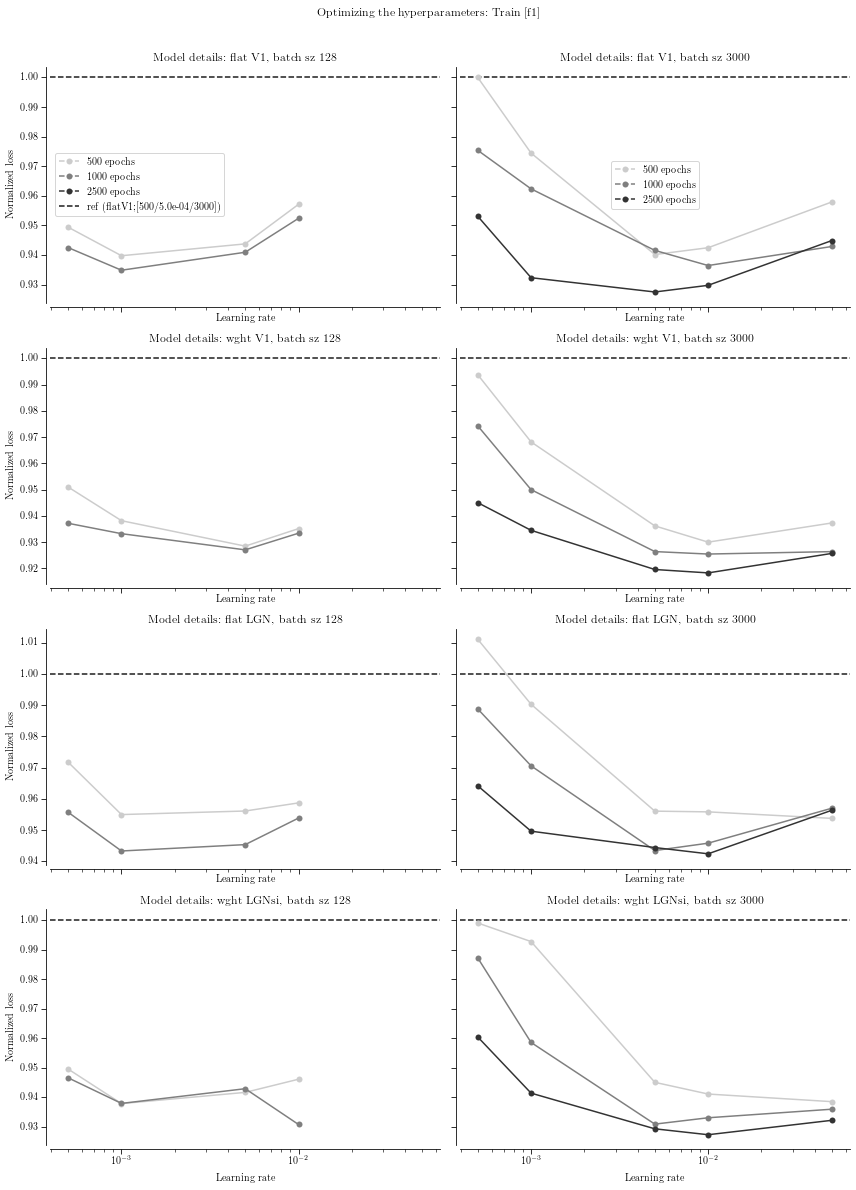

In [580]:
saveName = '04_01_hyperOpt_coarse_modSplit_%s_%s.pdf' % (trTeStr, dcF1Str)

nMods = int(np.sum(valid_fit[0,0,1,:,:,1])) # how many models did we fit?
nBatch = len(bs);

nlls_organized = [[nll_train_dc_norm, nll_test_dc_norm],[nll_train_f1_norm, nll_test_f1_norm]];
curr_nlls = nlls_organized[dcF1Ind][trTeInd]; # this is [nCell,nEpochs,nLR,nBS,nLGNs,nNorms,nExpts]

nrow,ncol = nMods,nBatch

f, ax = plt.subplots(nrow,ncol,figsize=(6*ncol, 4*nrow),sharey='row', sharex=True);

nPlts = len(eps);
clrs = cm.gray_r(np.linspace(0.2,0.8,nPlts)); # darker values will be those with more epochs

for expInd,expName in enumerate(expDirs):
    curr_mod_ind = 0;
    for (lVal,nVal),(lInd,nInd) in zip(itertools.product(*(lgnFrontEnds, fitTypes)), itertools.product(*[range(len(x)) for x in (lgnFrontEnds, fitTypes)])):
        # the above goes through the models; now go through the hyperparameters
        curr_mod_pass = False;
        lgnStr = hf.lgnType_suffix(lVal).replace('_','');
        normModStr = hf.fitType_suffix(nVal).replace('_','')
        
        for bSzInd,bSz in enumerate(bs):
            if not np.any(valid_fit[:,:,bSzInd,lInd,nInd,expInd]):
                continue;
            # otherwise, we made this fit, so plot!
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                mns = np.nanmean(curr_nlls, axis=0); #[nEpochs,nLR,nBS,nLGNs,nNorms,nExpts]
            if expInd == 0:
                [ax[curr_mod_ind, bSzInd].plot(lrs, x[:, bSzInd, lInd, nInd, expInd], 'o--', label='%d epochs' % eps[i], color=clrs[i]) for i,x in enumerate(mns)]
            elif expInd == 1:
                [ax[curr_mod_ind, bSzInd].plot(lrs, x[:, bSzInd, lInd, nInd, expInd], 'o-', color=clrs[i]) for i,x in enumerate(mns)]
            # reference line (at 1)
            if expInd==0:
                if bSzInd == 0:
                    ax[curr_mod_ind, bSzInd].axhline(1, color='k', linestyle='--', label=refLbl);
                else: # don't label...
                    ax[curr_mod_ind, bSzInd].axhline(1, color='k', linestyle='--');
            curr_mod_pass = True;
            
            # visuals
            ax[curr_mod_ind, bSzInd].set_xscale('log');
            if lgnStr == '': # i.e. if it's blank, then it's no LGN (just V1)
                lgnStr = 'V1'
            ax[curr_mod_ind, bSzInd].set_title('Model details: %s %s, batch sz %d' % (normModStr,lgnStr, bSz))
            ax[curr_mod_ind, bSzInd].set_xlabel('Learning rate', labelpad=7)
            if bSzInd==0:
                ax[curr_mod_ind, bSzInd].set_ylabel('Normalized loss')
            
        if curr_mod_pass:
            curr_mod_ind += 1; # increment which model we're plotting...

ax[0,0].legend();
ax[0,1].legend();
            
sns.despine(offset=4);
f.tight_layout();
f.suptitle('Optimizing the hyperparameters: %s [%s]' % (trTeStr, dcF1Str), y=1.03);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

### Interim summary (i):
What do we take away from the above plots?
- 1. As in the "normal" C-V runs, train and test loss are nearly indistinguishable (i.e. we are nowhere near overfitting).
- 2. Relative improvement seems larger for DC than F1
    - 1 to 0.75 vs. 1 to 0.95, i.e. 25% vs. just 5% improvement, but that could just be a consequence of some F1 responses being noisy (recall that we are just taking the first 20 V1_BB cells; there's no guarantee that these are clean responses...)
- 3. We seemed to span a wide enough range to consider the best range within the tested values!
    - For batches of 128 trials:
        - There isn't too dramatic a difference between 500 and 1k epochs, but should test higher rance
        - Learning rate is between 1e-3 and 5e-3
    - For full experiment (i.e. 3k batch size):
        - Some asymptoting between 1k and 2.5k epochs, but let's test slightly higher, too
        - Learning rate seems to be between 5e-3 and 1e-2

Since the results between the two experiments (solid and dashed lines) are similar, let's average across the two; we can likely do the same for model, too!

In [601]:
# ...comb for combined (across experiments)
# --- rollaxis moves the experiment dimension (initially last) to the front
# --- then vstack combines the first two dimensions (experiment, cells)
nll_test_dc_norm_comb = np.vstack(np.rollaxis(nll_test_dc_norm, -1))
nll_test_f1_norm_comb = np.vstack(np.rollaxis(nll_test_f1_norm, -1))
nll_train_dc_norm_comb = np.vstack(np.rollaxis(nll_train_dc_norm, -1))
nll_train_f1_norm_comb = np.vstack(np.rollaxis(nll_train_f1_norm, -1))

In [618]:
trTeInd = 1; # 0 is train, 1 is test
dcF1Ind = 0; # 0 is DC, 1 is F1
curr_nlls = nlls_organized[dcF1Ind][trTeInd]; # this is [nCell,nEpochs,nLR,nBS,nLGNs,nNorms,nExpts]
mns = np.nanmean(curr_nlls, axis=0); #[nEpochs,nLR,nBS,nLGNs,nNorms,nExpts]

trTeStr = 'Test' if trTeInd==1 else 'Train'
dcF1Str = 'f1' if dcF1Ind==1 else 'dc'

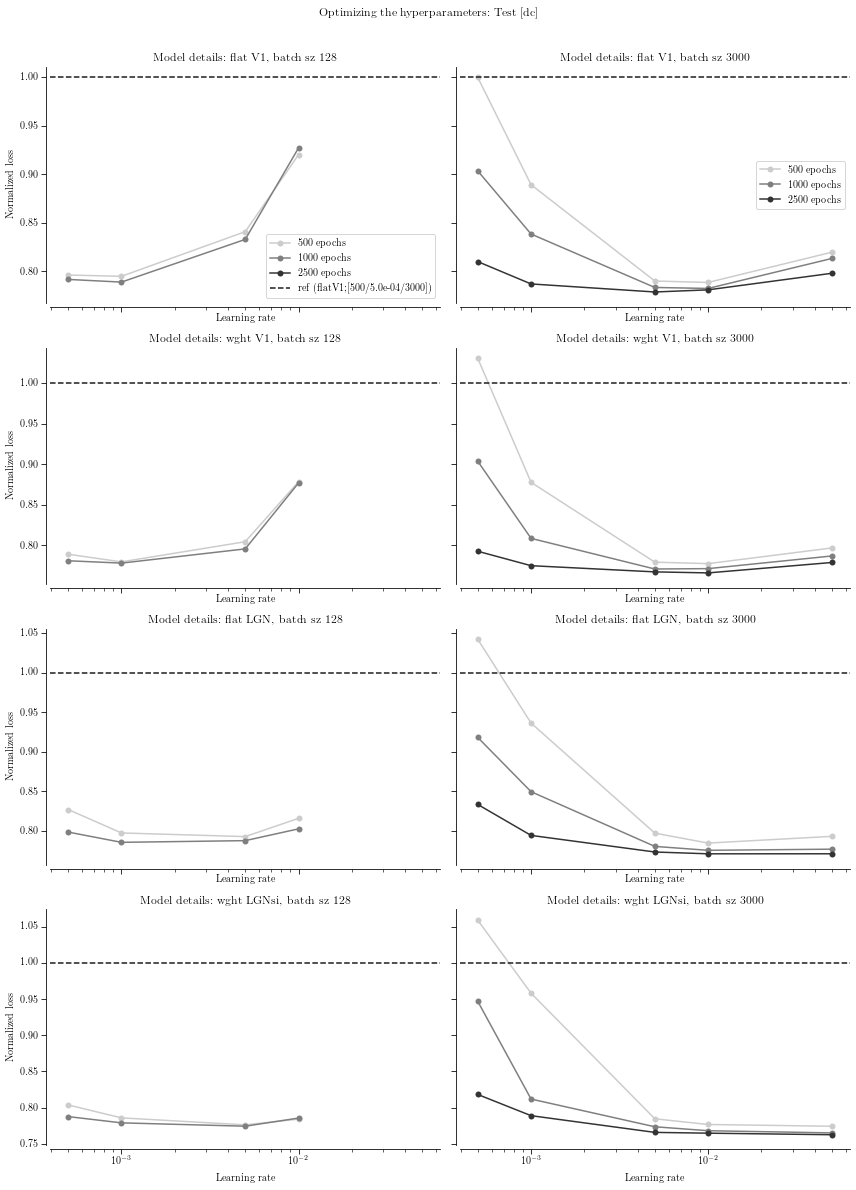

In [619]:
saveName = '04_02_hyperOpt_coarse_modSplit_expJoin_%s_%s.pdf' % (trTeStr, dcF1Str)

nMods = int(np.sum(valid_fit[0,0,1,:,:,1])) # how many models did we fit?
nBatch = len(bs);

nlls_organized = [[nll_train_dc_norm_comb, nll_test_dc_norm_comb],[nll_train_f1_norm_comb, nll_test_f1_norm_comb]];
curr_nlls = nlls_organized[dcF1Ind][trTeInd]; # this is [nCell,nEpochs,nLR,nBS,nLGNs,nNorms,nExpts]

nrow,ncol = nMods,nBatch

f, ax = plt.subplots(nrow,ncol,figsize=(6*ncol, 4*nrow),sharey='row', sharex=True);

nPlts = len(eps);
clrs = cm.gray_r(np.linspace(0.2,0.8,nPlts)); # darker values will be those with more epochs

curr_mod_ind = 0;
for (lVal,nVal),(lInd,nInd) in zip(itertools.product(*(lgnFrontEnds, fitTypes)), itertools.product(*[range(len(x)) for x in (lgnFrontEnds, fitTypes)])):
    # the above goes through the models; now go through the hyperparameters
    curr_mod_pass = False;
    lgnStr = hf.lgnType_suffix(lVal).replace('_','');
    normModStr = hf.fitType_suffix(nVal).replace('_','')

    for bSzInd,bSz in enumerate(bs):
        if not np.any(valid_fit[:,:,bSzInd,lInd,nInd]):
            continue;
        # otherwise, we made this fit, so plot!
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            mns = np.nanmean(curr_nlls, axis=0); #[nEpochs,nLR,nBS,nLGNs,nNorms]
        [ax[curr_mod_ind, bSzInd].plot(lrs, x[:, bSzInd, lInd, nInd], 'o-', label='%d epochs' % eps[i], color=clrs[i]) for i,x in enumerate(mns)]
        # reference line (at 1)
        if bSzInd == 0:
            ax[curr_mod_ind, bSzInd].axhline(1, color='k', linestyle='--', label=refLbl);
        else: # don't label...
            ax[curr_mod_ind, bSzInd].axhline(1, color='k', linestyle='--');
        curr_mod_pass = True;

        # visuals
        ax[curr_mod_ind, bSzInd].set_xscale('log');
        if lgnStr == '': # i.e. if it's blank, then it's no LGN (just V1)
            lgnStr = 'V1'
        ax[curr_mod_ind, bSzInd].set_title('Model details: %s %s, batch sz %d' % (normModStr,lgnStr, bSz))
        ax[curr_mod_ind, bSzInd].set_xlabel('Learning rate', labelpad=7)
        if bSzInd==0:
            ax[curr_mod_ind, bSzInd].set_ylabel('Normalized loss')

    if curr_mod_pass:
        curr_mod_ind += 1; # increment which model we're plotting...

ax[0,0].legend();
ax[0,1].legend();
            
sns.despine(offset=4);
f.tight_layout();
f.suptitle('Optimizing the hyperparameters: %s [%s]' % (trTeStr, dcF1Str), y=1.03);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

##### Now, let's also join across models?
i.e. turn average across the final two axes (normType, lgnType)

In [630]:
nll_train_dc_norm_all = np.nanmean(nll_train_dc_norm_comb, axis=(-2,-1))
nll_test_dc_norm_all = np.nanmean(nll_test_dc_norm_comb, axis=(-2,-1))
nll_train_f1_norm_all = np.nanmean(nll_train_f1_norm_comb, axis=(-2,-1))
nll_test_f1_norm_all = np.nanmean(nll_test_f1_norm_comb, axis=(-2,-1))

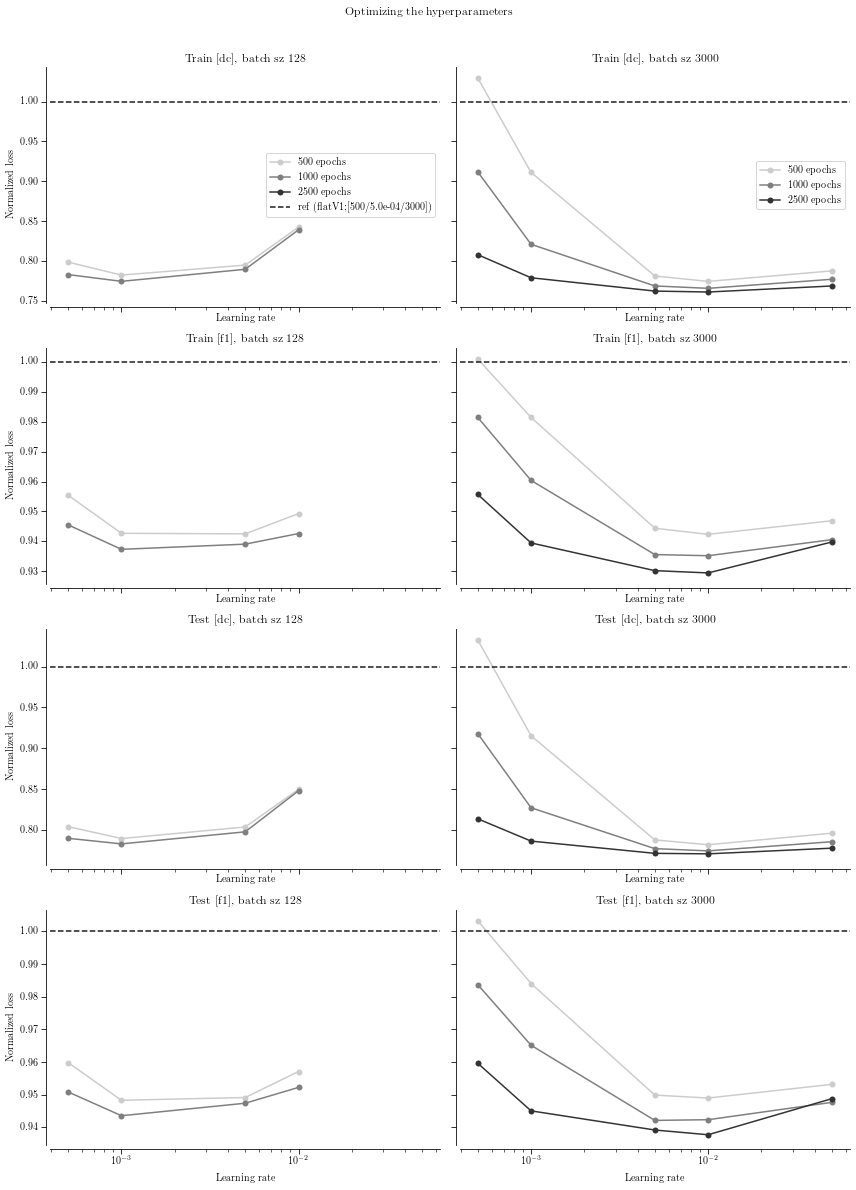

In [667]:
saveName = '04_03_hyperOpt_coarse_modJoin_expJoin.pdf'

nMods = int(np.sum(valid_fit[0,0,1,:,:,1])) # how many models did we fit?
nBatch = len(bs);

nlls_organized = [[nll_train_dc_norm_all, nll_test_dc_norm_all],[nll_train_f1_norm_all, nll_test_f1_norm_all]];

nrow,ncol = nMods,nBatch

f, ax = plt.subplots(nrow,ncol,figsize=(6*ncol, 4*nrow),sharey='row', sharex=True);

nPlts = len(eps);
clrs = cm.gray_r(np.linspace(0.2,0.8,nPlts)); # darker values will be those with more epochs

for iii,(trTeInd,dcF1Ind) in enumerate(itertools.product([0,1],[0,1])):
    curr_nlls = nlls_organized[dcF1Ind][trTeInd]; # this is [nCell,nEpochs,nLR,nBS]
    mns = np.nanmean(curr_nlls, axis=0); #[nEpochs,nLR,nBS]

    trTeStr = 'Test' if trTeInd==1 else 'Train'
    dcF1Str = 'f1' if dcF1Ind==1 else 'dc'

    for bSzInd,bSz in enumerate(bs):
        if not np.any(valid_fit[:,:,bSzInd]):
            continue;
        # otherwise, we made this fit, so plot!
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            mns = np.nanmean(curr_nlls, axis=0); #[nEpochs,nLR,nBS]
        [ax[iii, bSzInd].plot(lrs, x[:, bSzInd], 'o-', label='%d epochs' % eps[i], color=clrs[i]) for i,x in enumerate(mns)]
        # reference line (at 1)
        if bSzInd == 0:
            ax[iii, bSzInd].axhline(1, color='k', linestyle='--', label=refLbl);
        else: # don't label...
            ax[iii, bSzInd].axhline(1, color='k', linestyle='--');
        curr_mod_pass = True;

        # visuals
        ax[iii, bSzInd].set_xscale('log');
        if lgnStr == '': # i.e. if it's blank, then it's no LGN (just V1)
            lgnStr = 'V1'
        ax[iii, bSzInd].set_title('%s [%s], batch sz %d' % (trTeStr,dcF1Str, bSz))
        ax[iii, bSzInd].set_xlabel('Learning rate', labelpad=7)
        if bSzInd==0:
            ax[iii, bSzInd].set_ylabel('Normalized loss')

ax[0,0].legend();
ax[0,1].legend();
            
sns.despine(offset=4);
f.tight_layout();
f.suptitle('Optimizing the hyperparameters', y=1.03);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

Finally, additionally avg. over test/train, dc/f1...

In [777]:
nll_norm_all = np.stack((nll_train_dc_norm_all, nll_test_dc_norm_all, 
                         nll_train_f1_norm_all, nll_test_f1_norm_all))
avgd = np.nanmean(nll_norm_all,axis=0) # average across the test/train/dc/f1 conditions...

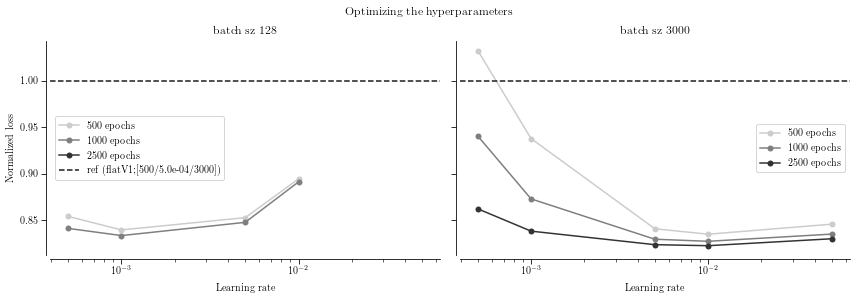

In [684]:
nrow,ncol = 1, 2;
f, ax = plt.subplots(nrow,ncol,figsize=(6*ncol, 4*nrow),sharey='row', sharex=True);

# just rename avgd as curr_nlls to keep code the same...
curr_nlls = avgd
# curr_stds = stdd;

wSem = False;

saveName = '04_04_hyperOpt_coarse_joinAll%s.pdf' % ('_wSem' if wSem else '')

for bSzInd,bSz in enumerate(bs):
    if not np.any(valid_fit[:,:,bSzInd]):
        continue;
    # otherwise, we made this fit, so plot!
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        mns  = np.nanmean(curr_nlls, axis=0); #[nEpochs,nLR,nBS]
        sems = ss.sem(curr_nlls, axis=0, nan_policy='omit'); #[nEpochs,nLR,nBS] 

    if wSem:
        [ax[bSzInd].errorbar(lrs, x[:, bSzInd], y[:, bSzInd], label='%d epochs' % eps[i], color=clrs[i]) for i,(x,y) in enumerate(zip(mns, sems))]
    else:
        [ax[bSzInd].plot(lrs, x[:, bSzInd], 'o-', label='%d epochs' % eps[i], color=clrs[i]) for i,x in enumerate(mns)]
    # reference line (at 1)
    if bSzInd == 0:
        ax[bSzInd].axhline(1, color='k', linestyle='--', label=refLbl);
    else: # don't label...
        ax[bSzInd].axhline(1, color='k', linestyle='--');
    curr_mod_pass = True;

    # visuals
    ax[bSzInd].set_xscale('log');
    ax[bSzInd].set_title('batch sz %d' % (bSz))
    ax[bSzInd].set_xlabel('Learning rate', labelpad=7)
    if bSzInd==0:
        ax[bSzInd].set_ylabel('Normalized loss')
    ax[bSzInd].legend();
        
sns.despine(offset=4);
f.tight_layout();
f.suptitle('Optimizing the hyperparameters', y=1.03);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

### Interim summary (ii):
Averaging over test/train & dc/f1 & model types, the same trends from before hold!

To be sure, we'll conduct a more fine-grained search below:

### 4.5: Hyperparameter tuning, refined

In [901]:
# hypers
eps = np.array([1000, 3000]);
lrs = np.array([0.0005, 0.0008, 0.0010, 0.0020, 0.0025, 0.0040, 0.0050, 0.0075, 0.0100, 0.0175, 0.0250, 0.0350, 0.0500]);
bs  = np.array([128, 3000]);

# model name details
fitDate = '230103';
excType = 1;
lossType = 1;
fitHPC  = 1;
applyLGNtoNorm = 1;
lgnConType = 1
vecCorrected = 0;
todoCV = 1
fixRespExp = 2; # or None?
noSched = True

maxNcell = 20;

loc_str = 'HPC' if fitHPC else '';
fL_name = 'fitList%s_pyt_nr%s%s%s' % (loc_str, fitDate, '_noRE' if fixRespExp is not None else '', '_noSched' if noSched else '');

lgnFrontEnds = [0, 1, 4];
fitTypes = [1,2]; # flat, weighted
expDirs = ['altExp/', 'V1_BB/'];

valid_fit = np.zeros((len(eps), len(lrs), len(bs), len(lgnFrontEnds), len(fitTypes), len(expDirs)));
nll_test_dc = np.nan * np.zeros((maxNcell, len(eps), len(lrs), len(bs), len(lgnFrontEnds), len(fitTypes), len(expDirs)));
nll_train_dc = np.nan * np.zeros_like(nll_test_dc)
nll_test_f1 = np.nan * np.zeros_like(nll_test_dc)
nll_train_f1 = np.nan * np.zeros_like(nll_test_dc)

for (a,b,c,lgnFront,normType),(aInd,bInd,cInd,lInd,nInd) in zip(itertools.product(*(eps,lrs,bs, lgnFrontEnds, fitTypes)), itertools.product(*[range(len(x)) for x in (eps,lrs,bs, lgnFrontEnds, fitTypes)])):
    testingInfo = [a,b,c];

    curr_name = hf.fitList_name(base=fL_name, fitType=normType, lossType=lossType, lgnType=lgnFront, lgnConType=lgnConType, 
                                vecCorrected=vecCorrected, CV=todoCV, excType=excType, 
                    lgnForNorm=applyLGNtoNorm, testingNames=True, testingInfo=testingInfo);
    for i,expDir in enumerate(expDirs):
        try:
            test = hf.np_smart_load('%sstructures/%s' % (expDir, curr_name));
            if len(test.keys()) > 0:
                valid_fit[aInd,bInd,cInd,lInd,nInd,i] = True
                nll_test_dc[0:len(test.keys()), aInd,bInd,cInd,lInd,nInd,i] = [np.nanmean(test[x]['dc']['NLL_test']) for x in test.keys()]
                nll_train_dc[0:len(test.keys()), aInd,bInd,cInd,lInd,nInd,i] = [np.nanmean(test[x]['dc']['NLL_train']) for x in test.keys()]
                nll_test_f1[0:len(test.keys()), aInd,bInd,cInd,lInd,nInd,i] = [np.nanmean(test[x]['f1']['NLL_test']) for x in test.keys()]
                nll_train_f1[0:len(test.keys()), aInd,bInd,cInd,lInd,nInd,i] = [np.nanmean(test[x]['f1']['NLL_train']) for x in test.keys()]
        except:
            pass;


In [902]:
div_by_train = False; # if False, then divide test by test, train by train

ref_epsInd = 0;
ref_lrInd = np.where(lrs==0.0050)[0][0];
ref_bsInd = 1;
ref_lgnInd = 0;
ref_fitInd = 0;
oy = ref_epsInd,ref_lrInd,ref_bsInd,ref_lgnInd,ref_fitInd

ref_lgnStr = hf.lgnType_suffix(lgnFrontEnds[ref_lgnInd]).replace('_','');
ref_lgnStr = 'V1' if ref_lgnStr=='' else ref_lgnStr
ref_normModStr = hf.fitType_suffix(fitTypes[ref_fitInd]).replace('_','')

refLbl = 'ref%s (%s%s;[%d/%.1e/%d])' % ('Tr' if div_by_train else '', ref_normModStr, ref_lgnStr, eps[ref_epsInd], lrs[ref_lrInd], bs[ref_bsInd])

# NORMALIZE within each cell, across conditions
ndims = len(nll_test_dc.shape)
# --- we normalize by the zeroth comp of all constituent dimensions EXCEPT for batch size --- use the larger size
if div_by_train:
    # note that slice(None) is equiv. to ':' in indexing
    nll_test_dc_norm = nll_test_dc/np.expand_dims(nll_train_dc[(slice(None),*oy)], axis=tuple(np.arange(1,ndims-1)))
    nll_test_f1_norm = nll_test_f1/np.expand_dims(nll_train_f1[(slice(None),*oy)], axis=tuple(np.arange(1,ndims-1)))
else:
    nll_test_dc_norm = nll_test_dc/np.expand_dims(nll_test_dc[(slice(None),*oy)], axis=tuple(np.arange(1,ndims-1)))
    nll_test_f1_norm = nll_test_f1/np.expand_dims(nll_test_f1[(slice(None),*oy)], axis=tuple(np.arange(1,ndims-1)))
nll_train_dc_norm = nll_train_dc/np.expand_dims(nll_train_dc[(slice(None),*oy)], axis=tuple(np.arange(1,ndims-1)))
nll_train_f1_norm = nll_train_f1/np.expand_dims(nll_train_f1[(slice(None),*oy)], axis=tuple(np.arange(1,ndims-1)))

In [911]:
trTeInd = 0; # 0 is train, 1 is test
dcF1Ind = 0; # 0 is DC, 1 is F1

trTeStr = 'Test' if trTeInd==1 else 'Train'
dcF1Str = 'f1' if dcF1Ind==1 else 'dc'

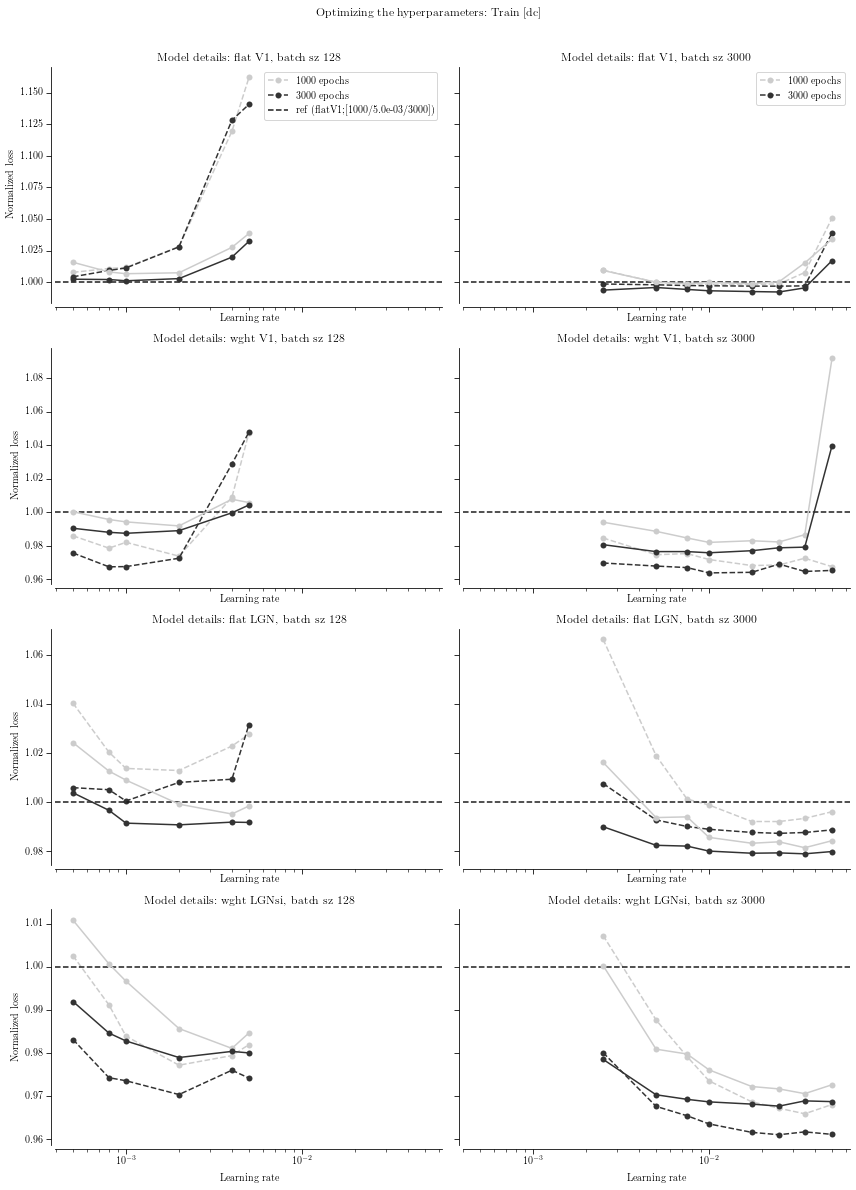

In [912]:
saveName = '04_05_hyperOpt_fine_modSplit_%s_%s.pdf' % (trTeStr, dcF1Str)

nMods = int(np.sum(valid_fit[ref_epsInd,ref_lrInd,ref_bsInd,:,:,1])) # how many models did we fit?
nBatch = len(bs);

nlls_organized = [[nll_train_dc_norm, nll_test_dc_norm],[nll_train_f1_norm, nll_test_f1_norm]];
curr_nlls = nlls_organized[dcF1Ind][trTeInd]; # this is [nCell,nEpochs,nLR,nBS,nLGNs,nNorms,nExpts]

nrow,ncol = nMods,nBatch

f, ax = plt.subplots(nrow,ncol,figsize=(6*ncol, 4*nrow),sharey='row', sharex=True);

nPlts = len(eps);
clrs = cm.gray_r(np.linspace(0.2,0.8,nPlts)); # darker values will be those with more epochs

for expInd,expName in enumerate(expDirs):
    curr_mod_ind = 0;
    for (lVal,nVal),(lInd,nInd) in zip(itertools.product(*(lgnFrontEnds, fitTypes)), itertools.product(*[range(len(x)) for x in (lgnFrontEnds, fitTypes)])):
        # the above goes through the models; now go through the hyperparameters
        curr_mod_pass = False;
        lgnStr = hf.lgnType_suffix(lVal).replace('_','');
        normModStr = hf.fitType_suffix(nVal).replace('_','')
        
        for bSzInd,bSz in enumerate(bs):
            if not np.any(valid_fit[:,:,bSzInd,lInd,nInd,expInd]):
                continue;
            # for this batch size (bSzInd), assuming lowest # of epochs (0), which learning rates are valid
            # --- why? we need to do this since we have mostly non-overlapping LRs between batch size, still want connected data
            val_lrs = np.where(valid_fit[0,:,bSzInd,lInd,nInd,expInd])[0]
            # otherwise, we made this fit, so plot!
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                mns = np.nanmean(curr_nlls, axis=0); #[nEpochs,nLR,nBS,nLGNs,nNorms,nExpts]
            if expInd == 0:
                [ax[curr_mod_ind, bSzInd].plot(lrs[val_lrs], x[val_lrs, bSzInd, lInd, nInd, expInd], 'o--', label='%d epochs' % eps[i], color=clrs[i]) for i,x in enumerate(mns)]
            elif expInd == 1:
                [ax[curr_mod_ind, bSzInd].plot(lrs[val_lrs], x[val_lrs, bSzInd, lInd, nInd, expInd], 'o-', color=clrs[i]) for i,x in enumerate(mns)]
            # reference line (at 1)
            if expInd==0:
                if bSzInd == 0:
                    ax[curr_mod_ind, bSzInd].axhline(1, color='k', linestyle='--', label=refLbl);
                else: # don't label...
                    ax[curr_mod_ind, bSzInd].axhline(1, color='k', linestyle='--');
            curr_mod_pass = True;
            
            # visuals
            ax[curr_mod_ind, bSzInd].set_xscale('log');
            if lgnStr == '': # i.e. if it's blank, then it's no LGN (just V1)
                lgnStr = 'V1'
            ax[curr_mod_ind, bSzInd].set_title('Model details: %s %s, batch sz %d' % (normModStr,lgnStr, bSz))
            ax[curr_mod_ind, bSzInd].set_xlabel('Learning rate', labelpad=7)
            if bSzInd==0:
                ax[curr_mod_ind, bSzInd].set_ylabel('Normalized loss')
            
        if curr_mod_pass:
            curr_mod_ind += 1; # increment which model we're plotting...

ax[0,0].legend();
ax[0,1].legend();
            
sns.despine(offset=4);
f.tight_layout();
f.suptitle('Optimizing the hyperparameters: %s [%s]' % (trTeStr, dcF1Str), y=1.03);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

Aggregate/average over experiment and also test/train & dc/f1?

In [913]:
# ...comb for combined (across experiments)
# --- rollaxis moves the experiment dimension (initially last) to the front
# --- then vstack combines the first two dimensions (experiment, cells)
nll_test_dc_norm_comb = np.vstack(np.rollaxis(nll_test_dc_norm, -1))
nll_test_f1_norm_comb = np.vstack(np.rollaxis(nll_test_f1_norm, -1))
nll_train_dc_norm_comb = np.vstack(np.rollaxis(nll_train_dc_norm, -1))
nll_train_f1_norm_comb = np.vstack(np.rollaxis(nll_train_f1_norm, -1))

nll_norm_all = np.stack((nll_train_dc_norm_comb, nll_test_dc_norm_comb, 
                         nll_train_f1_norm_comb, nll_test_f1_norm_comb))
curr_nlls = np.nanmean(nll_norm_all,axis=0) # average across the test/train/dc/f1 conditions...

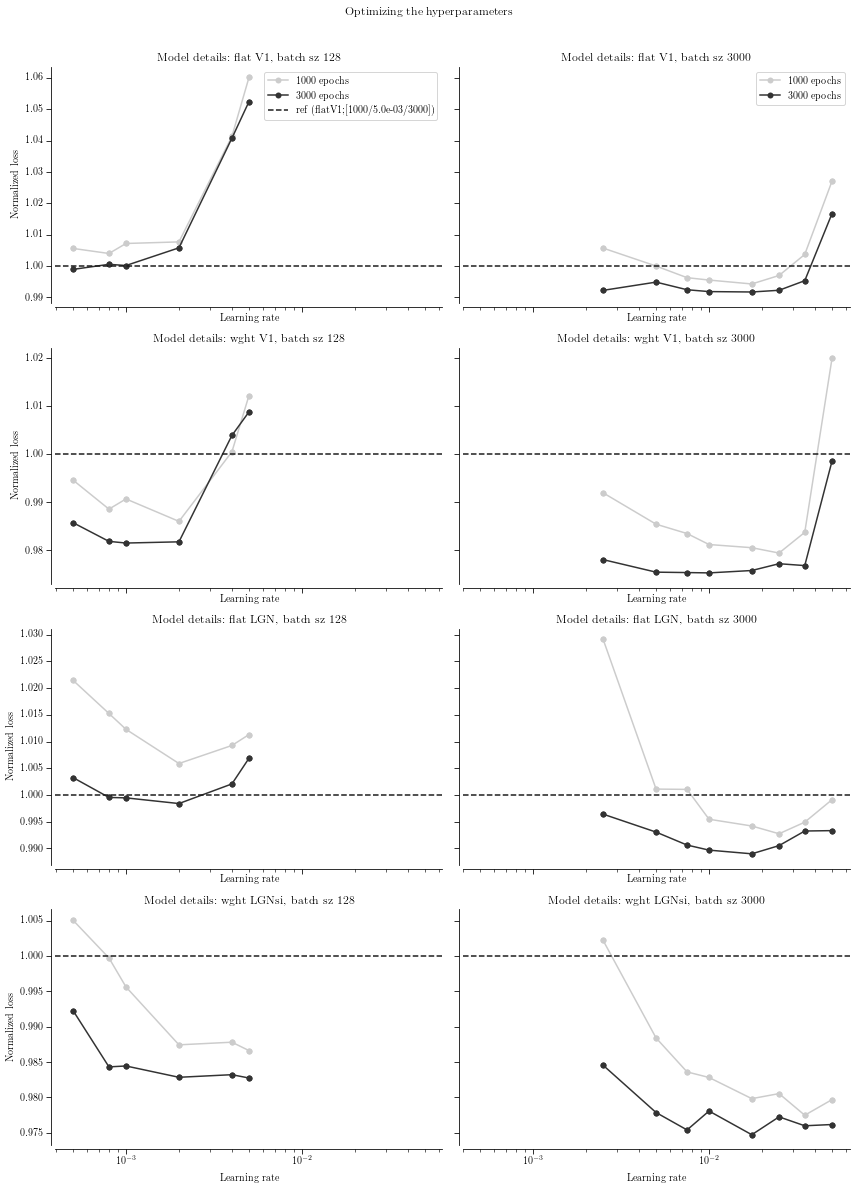

In [914]:
saveName = '04_06_hyperOpt_fine_modSplit_expCondJoin.pdf'

nrow,ncol = nMods,nBatch

f, ax = plt.subplots(nrow,ncol,figsize=(6*ncol, 4*nrow),sharey='row', sharex=True);

nPlts = len(eps);
clrs = cm.gray_r(np.linspace(0.2,0.8,nPlts)); # darker values will be those with more epochs

curr_mod_ind = 0;
for (lVal,nVal),(lInd,nInd) in zip(itertools.product(*(lgnFrontEnds, fitTypes)), itertools.product(*[range(len(x)) for x in (lgnFrontEnds, fitTypes)])):
    # the above goes through the models; now go through the hyperparameters
    curr_mod_pass = False;
    lgnStr = hf.lgnType_suffix(lVal).replace('_','');
    normModStr = hf.fitType_suffix(nVal).replace('_','')

    for bSzInd,bSz in enumerate(bs):
        if not np.any(valid_fit[:,:,bSzInd,lInd,nInd]):
            continue;
        # for this batch size (bSzInd), assuming lowest # of epochs (0), which learning rates are valid
        # --- why? we need to do this since we have mostly non-overlapping LRs between batch size, still want connected data
        val_lrs = np.where(valid_fit[0,:,bSzInd,lInd,nInd])[0]
        # otherwise, we made this fit, so plot!
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            mns = np.nanmean(curr_nlls, axis=0); #[nEpochs,nLR,nBS,nLGNs,nNorms]
        [ax[curr_mod_ind, bSzInd].plot(lrs[val_lrs], x[val_lrs, bSzInd, lInd, nInd], 'o-', label='%d epochs' % eps[i], color=clrs[i]) for i,x in enumerate(mns)]
        # reference line (at 1)
        if bSzInd == 0:
            ax[curr_mod_ind, bSzInd].axhline(1, color='k', linestyle='--', label=refLbl);
        else: # don't label...
            ax[curr_mod_ind, bSzInd].axhline(1, color='k', linestyle='--');
        curr_mod_pass = True;

        # visuals
        ax[curr_mod_ind, bSzInd].set_xscale('log');
        if lgnStr == '': # i.e. if it's blank, then it's no LGN (just V1)
            lgnStr = 'V1'
        ax[curr_mod_ind, bSzInd].set_title('Model details: %s %s, batch sz %d' % (normModStr,lgnStr, bSz))
        ax[curr_mod_ind, bSzInd].set_xlabel('Learning rate', labelpad=7)
        if bSzInd==0:
            ax[curr_mod_ind, bSzInd].set_ylabel('Normalized loss')

    if curr_mod_pass:
        curr_mod_ind += 1; # increment which model we're plotting...

ax[0,0].legend();
ax[0,1].legend();
            
sns.despine(offset=4);
f.tight_layout();
f.suptitle('Optimizing the hyperparameters', y=1.03);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

##### One further join (to mimic the last plot before section 4.5)

In [918]:
nll_all_comb = np.nanmean(curr_nlls, axis=(-2,-1))

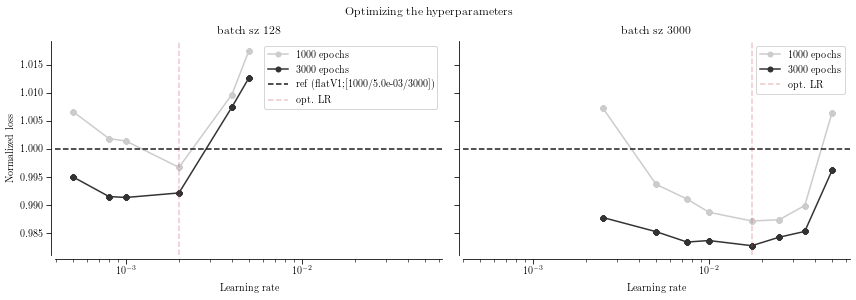

In [923]:
nrow,ncol = 1, 2;
f, ax = plt.subplots(nrow,ncol,figsize=(6*ncol, 4*nrow),sharey='row', sharex=True);

# just rename nll_all_comb so we can keep code the same...
curr_nlls = nll_all_comb

wSem = False;

saveName = '04_07_hyperOpt_fine_joinAll%s.pdf' % ('_wSem' if wSem else '')

pref_vals = [0.0020, 0.0175];

for bSzInd,bSz in enumerate(bs):
    if not np.any(valid_fit[:,:,bSzInd]):
        continue;
    # otherwise, we made this fit, so plot!
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        mns  = np.nanmean(curr_nlls, axis=0); #[nEpochs,nLR,nBS]
        sems = ss.sem(curr_nlls, axis=0, nan_policy='omit'); #[nEpochs,nLR,nBS] 

    # for this batch size (bSzInd), assuming lowest # of epochs (0), which learning rates are valid
    # --- why? we need to do this since we have mostly non-overlapping LRs between batch size, still want connected data
    val_lrs = np.where(valid_fit[0,:,bSzInd])[0]
    if wSem:
        [ax[bSzInd].errorbar(lrs[val_lrs], x[val_lrs, bSzInd], y[val_lrs, bSzInd], label='%d epochs' % eps[i], color=clrs[i]) for i,(x,y) in enumerate(zip(mns, sems))]
    else:
        [ax[bSzInd].plot(lrs[val_lrs], x[val_lrs, bSzInd], 'o-', label='%d epochs' % eps[i], color=clrs[i]) for i,x in enumerate(mns)]
    # reference line (at 1)
    if bSzInd == 0:
        ax[bSzInd].axhline(1, color='k', linestyle='--', label=refLbl);
    else: # don't label...
        ax[bSzInd].axhline(1, color='k', linestyle='--');
    curr_mod_pass = True;
    ax[bSzInd].axvline(pref_vals[bSzInd], color='r', linestyle='--', alpha=0.3, label='opt. LR');

    # visuals
    ax[bSzInd].set_xscale('log');
    ax[bSzInd].set_title('batch sz %d' % (bSz))
    ax[bSzInd].set_xlabel('Learning rate', labelpad=7)
    if bSzInd==0:
        ax[bSzInd].set_ylabel('Normalized loss')
    ax[bSzInd].legend();
        
sns.despine(offset=4);
f.tight_layout();
f.suptitle('Optimizing the hyperparameters', y=1.03);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

### Summary
Some interesting differences per-model are more noticeable here (2nd plot above), although they were also noticed somewhat in the wider-ranging sample of hyperparameters. In particular, the optimal learning rate for the the more complex models (e.g. LGNsi) is slightly greater than that of the simpler models (e.g. no LGN front end). Nonetheless, the simpler models seem to have a wider plateau of learning rates that work, so we don't have to compromise much to get a learning rate that works well for all models. As for the impact of # of epochs, certainly 3k is better than 1k, but there is likely a state of diminshing returns!
- For 3k batch size (what we'll use), let's go with: 2500 epochs, 0.0175 learning rate (1.75e-2)
- For 128 batch size (what we'll use), let's go with: 2500 epochs, 0.0020 learning rate (2e-3)

# 5. Analysis - cross-validation:

In [894]:
expDir = 'V1_orig/'; # for now, V1_BB/ or altExp/
fitDate = '221231'; # add any suffix here!
fitHPC  = 1;
fixRespExp = 2; # or None?
scheduler = False
lgnFrontEnd = 0; # on [1] or off [0]
todoCV = True;

excType = 1
lgnConType = 1;
vecCorrected = 0;
lossType = 1; # should be unchanged
loc_str = 'HPC' if fitHPC else '';

fL_name = 'fitList%s_pyt_nr%s%s%s' % (loc_str, fitDate, '_noRE' if fixRespExp is not None else '', 
                                             '_noSched' if scheduler==False else '');

fitListName_flat = hf.fitList_name(base=fL_name, fitType=1, lossType=lossType, lgnType=lgnFrontEnd, 
                              lgnConType=lgnConType, vecCorrected=vecCorrected, CV=todoCV, excType=excType);
fitListName_wght = hf.fitList_name(base=fL_name, fitType=2, lossType=lossType, lgnType=lgnFrontEnd, 
                              lgnConType=lgnConType, vecCorrected=vecCorrected, CV=todoCV, excType=excType);

fl = hf.np_smart_load('%sstructures/%s' % (expDir, fitListName_flat)) 
wt = hf.np_smart_load('%sstructures/%s' % (expDir, fitListName_wght)) 

### and free respExp?
'''
fixRespExp = None
fL_name = 'fitList%s_pyt_nr%s%s%s' % (loc_str, fitDate, '_noRE' if fixRespExp is not None else '', 
                                             '_noSched' if scheduler==False else '');

fitListName_flat = hf.fitList_name(base=fL_name, fitType=1, lossType=lossType, lgnType=lgnFrontEnd, 
                              lgnConType=lgnConType, vecCorrected=vecCorrected, CV=todoCV, excType=excType);
fitListName_wght = hf.fitList_name(base=fL_name, fitType=2, lossType=lossType, lgnType=lgnFrontEnd, 
                              lgnConType=lgnConType, vecCorrected=vecCorrected, CV=todoCV, excType=excType);

fl_free = hf.np_smart_load('%sstructures/%s' % (expDir, fitListName_flat)) 
wt_free = hf.np_smart_load('%sstructures/%s' % (expDir, fitListName_wght)) 
'''

### and load reference (i.e. not C-V)
ref_flat = hf.fitList_name(base=fL_name, fitType=1, lossType=lossType, lgnType=lgnFrontEnd, 
                              lgnConType=lgnConType, vecCorrected=vecCorrected, CV=False, excType=excType);
ref_wght = hf.fitList_name(base=fL_name, fitType=2, lossType=lossType, lgnType=lgnFrontEnd, 
                              lgnConType=lgnConType, vecCorrected=vecCorrected, CV=False, excType=excType);


ref_fl = hf.np_smart_load('%sstructures/%s' % (expDir, ref_flat)) 
ref_wt = hf.np_smart_load('%sstructures/%s' % (expDir, ref_wght)) 

In [895]:
def get_mn_nll(x, isTest):
    try:
        tst_str = 'NLL_test' if isTest==1 else 'NLL_train' if isTest==0 else 'NLL'
        return np.mean(x[tst_str]);
    except:
        return np.nan

respStr = 'dc' # dc or f1
fl_tr = np.array([get_mn_nll(fl[x][respStr], 0) for x in fl.keys()])
fl_te = np.array([get_mn_nll(fl[x][respStr], 1) for x in fl.keys()])

wt_tr = np.array([get_mn_nll(wt[x][respStr], 0) for x in wt.keys()])
wt_te = np.array([get_mn_nll(wt[x][respStr], 1) for x in wt.keys()])


# fl_tr = np.array([np.mean(fl[x][respStr]['NLL_train']) for x in fl.keys()])
# fl_te = np.array([np.mean(fl[x][respStr]['NLL_test']) for x in fl.keys()])

# wt_tr = np.array([np.mean(wt[x][respStr]['NLL_train']) for x in wt.keys()])
# wt_te = np.array([np.mean(wt[x][respStr]['NLL_test']) for x in wt.keys()])

# and free RE ?
# flF_tr = np.array([np.mean(fl_free[x][respStr]['NLL_train']) for x in fl_free.keys()])
# flF_te = np.array([np.mean(fl_free[x][respStr]['NLL_test']) for x in fl_free.keys()])

# wtF_tr = np.array([np.mean(wt_free[x][respStr]['NLL_train']) for x in wt_free.keys()])
# wtF_te = np.array([np.mean(wt_free[x][respStr]['NLL_test']) for x in wt_free.keys()])

# and ref NLL?
fl_ref = np.array([get_mn_nll(ref_fl[x][respStr], -1) for x in ref_fl.keys()])
wt_ref = np.array([get_mn_nll(ref_wt[x][respStr], -1) for x in ref_wt.keys()])

In [896]:
diffz_fl = (fl_te-fl_tr)/fl_tr
diffz_wt = (wt_te-wt_tr)/wt_tr
diffz_ = (fl_te-wt_te)/fl_te

# diffz_free_fl = (fl_te-flF_te)/fl_te
# diffz_free_wt = (wt_te-wtF_te)/wt_te

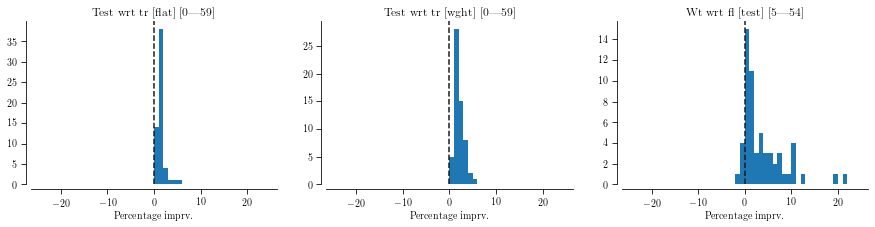

In [900]:
nr,nc = 1, 3
f, ax = plt.subplots(nr, nc, figsize=(5*nc, 3*nr));

to_clip = True;

dts = [diffz_fl, diffz_wt, diffz_]

lbls = ['Test wrt tr [flat]', 'Test wrt tr [wght]', 'Wt wrt fl [test]']

rng = 24;

for (i,lbl),dt in zip(enumerate(lbls), dts):
    bins = np.linspace(-rng,rng,2*rng+1);
    if to_clip:
        clpd = np.clip(100*dt, bins[1], bins[-1]);
        ax[i].hist(clpd, bins=bins);
    else:
        ax[i].hist(100*dt, bins=bins);
    ax[i].set_xlabel('Percentage imprv.')
    nl, nr = np.sum(dt<0), np.sum(dt>0)
    ax[i].set_title('%s [%d|%d]' % (lbl, nl, nr));
    ax[i].axvline(0, color='k', linestyle='--')


sns.despine(offset=5);


### 5.1 Cross-validation, in detail
The above was just a preliminary exploration - now let's make it more formalized!

##### Use the jointLists

In [2048]:
modsAll = hf.np_smart_load('jointList_wMods_V1_230108vE_vT00_dvT00_m3j10.npy')
# remove any Nones...
valids = np.where([modsAll[x]['model']['NLLs']!=None for x in modsAll.keys()])[0];
modsAll = {i: modsAll[k] for i,k in enumerate(valids)};

expNames = np.array([modsAll[x]['metadata']['fullPath'].split('/')[-3] for x in modsAll.keys()]);

In [2049]:
# first load normal/full-dataset NLL
NLLs = np.array([np.array(modsAll[x]['model']['NLLs']) for x in modsAll.keys()]);
# then, C-V
NLLs_tr = np.array([np.array(modsAll[x]['model']['NLLs_CV_tr']) for x in modsAll.keys()]);
NLLs_te = np.array([np.array(modsAll[x]['model']['NLLs_CV_te']) for x in modsAll.keys()]);
# and varExpl
varExpl = np.array([np.array(modsAll[x]['model']['varExplAll']) for x in modsAll.keys()]);
varExpl_CV = np.array([np.array(modsAll[x]['model']['varExplAll_CV']) for x in modsAll.keys()]);

get_ref_key = hf.modelSpecs_to_key(1, 1, 0); # flat; loss=1; no LGN [0]; all other params as default
akey = list(modsAll.keys())[0]; # all the same...
ref_index = np.where([x==get_ref_key for x in modsAll[akey]['model']['inputKeys']])[0]

# let's make these [...,3] with the indices as below:
rawInd, normInd, percInd = 0,1,2;

# --- set it up
all_NLLs = np.repeat(np.expand_dims(NLLs, axis=-1), 3, axis=-1)
all_NLLs_tr = np.repeat(np.expand_dims(NLLs_tr, axis=-1), 3, axis=-1)
all_NLLs_te = np.repeat(np.expand_dims(NLLs_te, axis=-1), 3, axis=-1)
# --- then overwrite norm, perc indices
all_NLLs[:,:,normInd] /= all_NLLs[:,ref_index,normInd]
all_NLLs_tr[:,:,normInd] /= all_NLLs_tr[:,ref_index,normInd]
all_NLLs_te[:,:,normInd] /= all_NLLs_te[:,ref_index,normInd]
as_perc = lambda ref,upd: 100*(ref-upd)/ref
all_NLLs[:,:,percInd] = as_perc(all_NLLs[:,ref_index,0],all_NLLs[:,:,0])
all_NLLs_tr[:,:,percInd] = as_perc(all_NLLs_tr[:,ref_index,0], all_NLLs_tr[:,:,0])
all_NLLs_te[:,:,percInd] = as_perc(all_NLLs_te[:,ref_index,0], all_NLLs_te[:,:,0])


#### Relative improvement compared to flat model

<>:42: DeprecationWarning: invalid escape sequence \%


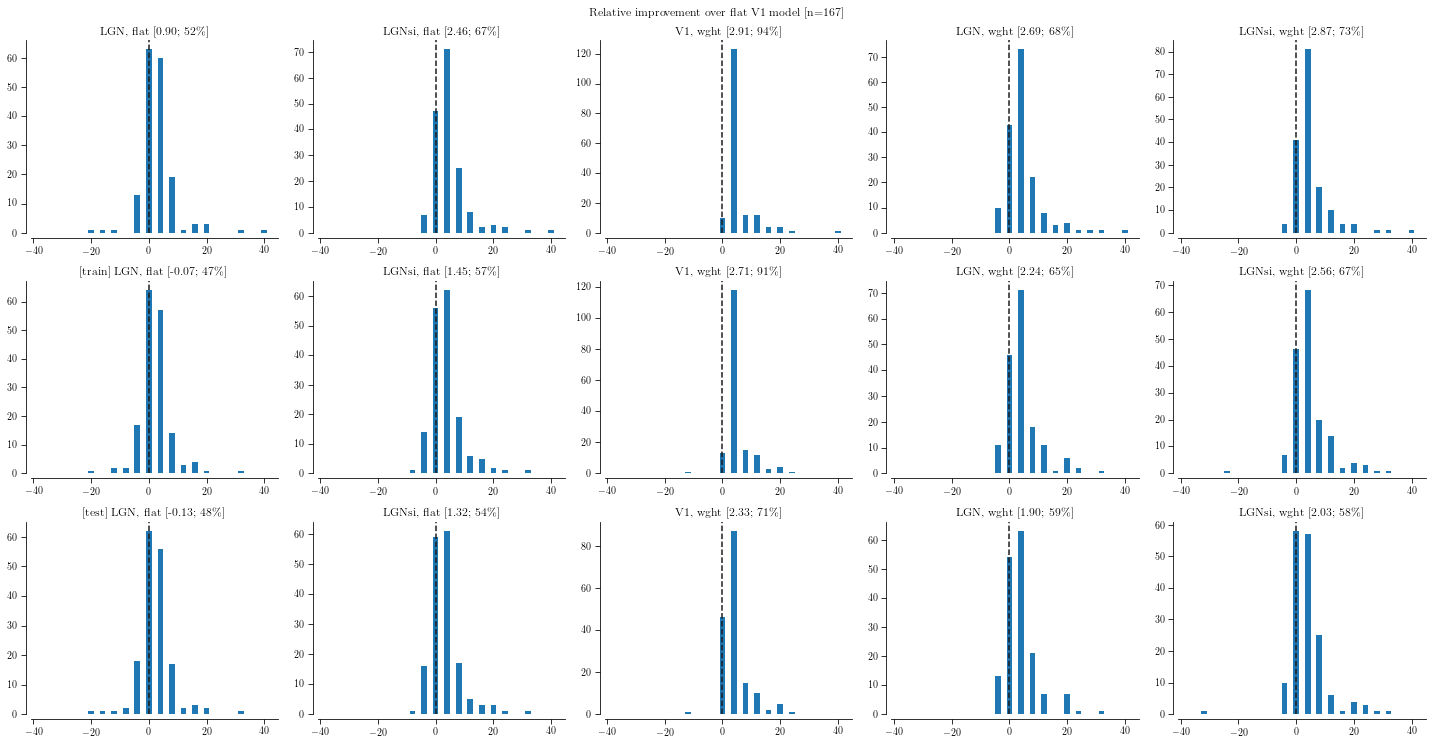

In [2050]:
# val_expt = ['altExp', 'V1']; # this will prob. be only one we combine
# val_expt = ['altExp'];
val_expt = None

saveName = '05_01_relImprHist%s.pdf' % ('_only%s' % ''.join(val_expt) if val_expt is not None else '')

nMods = NLLs.shape[-1];
nOtherMods = nMods - 1; # remove the reference as one model
nComps = 3; # not-CV, train, test

f, ax = plt.subplots(nComps, nOtherMods, figsize=(4*nOtherMods, 3.5*nComps));

bins = np.linspace(-40,40,21);
dataOrg = [all_NLLs, all_NLLs_tr, all_NLLs_te]
rowStr = ['', '[train] ', '[test] '];

for (comp_i, data), rowStr in zip(enumerate(dataOrg), rowStr):
    val_mod = 0;
    for i_mod in range(nMods):
        if i_mod == ref_index:
            continue; # don't plot this one...
        lVal, nVal = modsAll[akey]['model']['inputsSpecified']['lgnFrontEnd'][i_mod], modsAll[akey]['model']['inputsSpecified']['normType'][i_mod]

        lgnStr = hf.lgnType_suffix(lVal).replace('_','');
        lgnStr = 'V1' if lgnStr=='' else lgnStr;
        normModStr = hf.fitType_suffix(nVal).replace('_','')

        if val_expt is None:
            val_cells = range(data.shape[0]);
        else:
            val_cells = []
            for expt_curr in val_expt:
                val_cells = np.concatenate((val_cells, np.where(expNames==expt_curr)[0]));
            val_cells = np.array(val_cells, dtype=np.int)
        
        cnts,bns = np.histogram(data[val_cells, i_mod, percInd], bins=bins)

        ax[comp_i, val_mod].bar(bns[1:], cnts, width=1.95)
        ax[comp_i, val_mod].axvline(0, color='k', linestyle='--')
        rowStr = rowStr if val_mod==0 else ''
        percWinners = 100*np.sum(data[val_cells, i_mod, percInd]>0)/len(data[val_cells, i_mod, percInd])
        ax[comp_i, val_mod].set_title('%s%s, %s [%.2f; %d\%%]' % (rowStr, lgnStr, 
                                                                 normModStr, 
                                                                 np.nanmean(data[val_cells, i_mod, percInd]),
                                                                 percWinners))

        val_mod+=1
    
sns.despine(offset=5);
f.suptitle('Relative improvement over flat V1 model [n=%d]' % len(val_cells))
f.tight_layout()

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

### Impressions:
- The largest _mean_ improvement goes to the LGNsi model with weighted gain control.
- However, some cells are clearly not well fit by that model, since a fewer percentage of cells with that fit are better than the flat model; this is especially true for test holdouts (bottom row)
- All models are better than flat, with the slight exception (_maybe_? of the LGN model with no tuned gain control)

##### Now compare between pairs of models
We'll try to highlight some of the outlier cells so we can show examples!

### 5.1 Comparisons on absolute NLL 

In [2051]:
lgnVal_a, normVal_a = 0, 1; # only these two values are needed to uniquely specify a model run/fit
lgnVal_b, normVal_b = 0, 2; # only these two values are needed to uniquely specify a model run/fit

### 5.2 Comparisons on impr. rel to reference model

<>:52: DeprecationWarning: invalid escape sequence \%


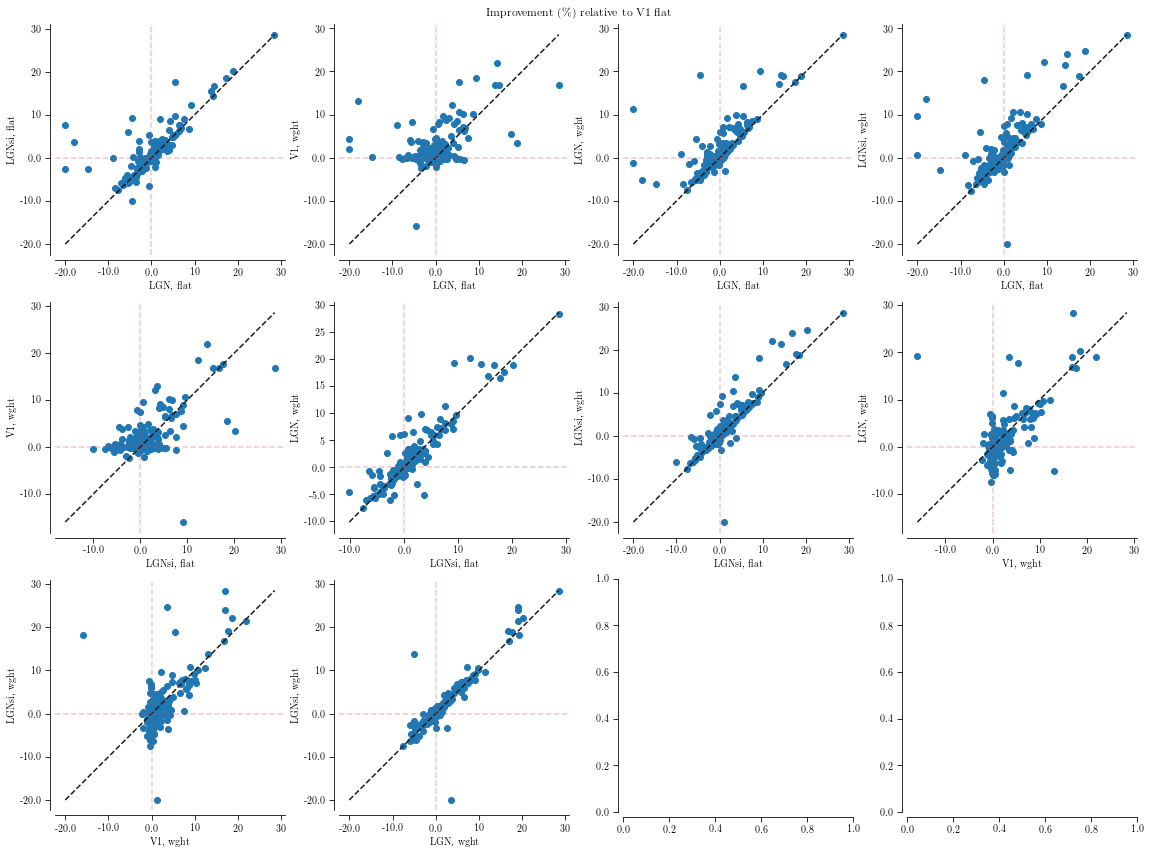

In [2052]:
which_data = 2; # 0/1/2 (non-CV/train/test)
dataStr = '_cvTest' if which_data==2 else '_cvTrain' if which_data==1 else '';

curr_data = dataOrg[which_data];

saveName = '05_02_percNLL_scatter%s.pdf' % dataStr

nPlts = nOtherMods*(nOtherMods-1)/2; # pairwise combinations, div by 2 (ab vs ba are the same...)

nrow = int(np.floor(np.sqrt(nPlts)))
ncol = int(np.ceil(nPlts/nrow));

f, ax = plt.subplots(nrow,ncol,figsize=(4*ncol,4*nrow));

val_mods = np.setxor1d(range(nMods), ref_index)
low_clip = -20 # prct

for iii,(modA,modB) in enumerate(itertools.combinations(val_mods, 2)):

    row_ind = int(iii/ncol);
    col_ind = np.mod(iii, ncol);
    # temporarily to avoid bad scales, make the minimum no smaller than X
    mn = np.maximum(low_clip, np.minimum(np.nanmin(curr_data[:,modA,percInd]), np.nanmin(curr_data[:,modB,percInd])))
#     mn = np.minimum(np.nanmin(curr_data[:,modA,percInd]), np.nanmin(curr_data[:,modB,percInd]))
    mx = np.maximum(np.nanmax(curr_data[:,modA,percInd]), np.nanmax(curr_data[:,modB,percInd]))

    lgnStrs = []; normStrs = [];
    for modN in [modA,modB]:
        lVal, nVal = modsAll[akey]['model']['inputsSpecified']['lgnFrontEnd'][modN], modsAll[akey]['model']['inputsSpecified']['normType'][modN]
        lgnStr = hf.lgnType_suffix(lVal).replace('_','');
        lgnStr = 'V1' if lgnStr=='' else lgnStr;
        normModStr = hf.fitType_suffix(nVal).replace('_','')
        lgnStrs.append(lgnStr);
        normStrs.append(normModStr)

    ax[row_ind, col_ind].set_xlabel('%s, %s' % (lgnStrs[0], normStrs[0]))
    ax[row_ind, col_ind].set_ylabel('%s, %s' % (lgnStrs[1], normStrs[1]))
    ax[row_ind, col_ind].plot([mn,mx], [mn,mx], 'k--');
    ax[row_ind, col_ind].scatter(np.clip(curr_data[:,modA,percInd], low_clip, None), 
                                 np.clip(curr_data[:,modB,percInd], low_clip, None));
#     ax[row_ind, col_ind].scatter(curr_data[:,modA,percInd], curr_data[:,modB,percInd]);
    ax[row_ind, col_ind].axis('scaled')
    # and zero lines
    ax[row_ind, col_ind].axhline(0, color='r', linestyle='--', alpha=0.3)
    ax[row_ind, col_ind].axvline(0, color='r', linestyle='--', alpha=0.3)
    
    for jj, axis in enumerate([ax[row_ind, col_ind].xaxis, ax[row_ind, col_ind].yaxis]):
        axis.set_major_formatter(FuncFormatter(lambda x,y: '%d' % x if x>=1 else '%.1f' % x)) # this will make everything in non-scientific notation!
        if jj==1: # i.e. y axis, make sure we have tick labels, here, too
            axis.set_tick_params(labelleft=True); 

f.suptitle('Improvement (\%) relative to V1 flat')
f.tight_layout();
sns.despine(offset=5);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

In [2053]:
### For example, what about LGNsi where wght is much better than flat?
lgnInds = [4,0]; # none/on/shift [0/1/4]
normInds = [1,2]; # flat [1], wght [2]

abs_order = True;

nlls_curr = [];

for nI,lI in zip(normInds, lgnInds):
    normOK =  np.where(modsAll[akey]['model']['inputsSpecified']['normType'] == nI);
    lgnOK =  np.where(modsAll[akey]['model']['inputsSpecified']['lgnFrontEnd'] == lI);
    curr_mod = np.intersect1d(lgnOK, normOK);
    
    nlls_curr.append(curr_data[:, curr_mod, percInd])
diffs = np.subtract(*nlls_curr).flatten()
# Here, negative values mean the second model has a higher improvement over the flat model, as compared to first model
if abs_order:
    asort = np.argsort(-np.abs(diffs))
else:
    asort = np.argsort(diffs)


<>:30: DeprecationWarning: invalid escape sequence \_


V1:43
altExp:1
V1_orig:27
V1_BB:24
V1_orig:13


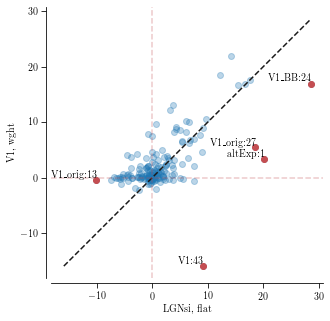

In [2054]:
howMany = 5;
strt = 0
whichOnes = np.arange(strt,strt+howMany)

# plt.stem(diffs[am][np.abs(diffs[am])>5])
f = plt.figure(figsize=(5,5))

mn = np.maximum(low_clip, np.minimum(np.nanmin(nlls_curr[0]), np.nanmin(nlls_curr[1])));
mx = np.maximum(np.nanmax(nlls_curr[0]), np.nanmax(nlls_curr[1]))

for axI, (lInd, nInd) in enumerate(zip(lgnInds, normInds)):

    lgnStr = hf.lgnType_suffix(lInd).replace('_','');
    lgnStr = 'V1' if lgnStr=='' else lgnStr;
    normModStr = hf.fitType_suffix(nInd).replace('_','')

    curr_str = '%s, %s' % (lgnStr, normModStr)
    if axI == 0:
        plt.xlabel('%s' % curr_str)
    else:
        plt.ylabel('%s' % curr_str)
plt.plot([mn,mx], [mn,mx], 'k--');
plt.scatter(np.clip(nlls_curr[0], low_clip, None), 
                             np.clip(nlls_curr[1], low_clip, None), alpha=0.3);

plt.scatter(np.clip(nlls_curr[0][asort[whichOnes]], low_clip, None), 
                             np.clip(nlls_curr[1][asort[whichOnes]], low_clip, None), color='r');
[plt.text(np.clip(nlls_curr[0][currInd], low_clip, None), 
                             np.clip(nlls_curr[1][currInd], low_clip, None), 
          '%s:%d' % (expNames[currInd].replace('_', '\_'),
                     modsAll[currInd]['metadata']['cellNum']),
         ha='right', va='bottom') for currInd in asort[whichOnes]]
[print('%s:%d' % (expNames[currInd],
                     modsAll[currInd]['metadata']['cellNum'])) for currInd in asort[whichOnes]]
plt.axis('scaled')
# and zero lines
plt.axhline(0, color='r', linestyle='--', alpha=0.3)
plt.axvline(0, color='r', linestyle='--', alpha=0.3)
sns.despine(offset=5)

### Per T+E, let's focus on just three models:
- No LGN, flat gain control
- No LGN, tuned gain control
- Yes LGN, flat gain control

In part, this choice is because we might not be able to properly constrain/identify the model components in the LGN + tuned gain control model. Furthermore, we can't make too many comparisons.

So, let's make the same relative improvement plot we made above, but also indicate the degree to which the model explained the data. We're computing variance explained (a la Cavanaugh et al 2002)

In [2709]:
# the standard 
lgnInds = [0,0]; # none/on/shift [0/1/4]
normInds = [1,2]; # flat [1], wght [2]
# # compare flat V1 to wght V1
# lgnInds = [0,0]; # none/on/shift [0/1/4]
# normInds = [1,2]; # flat [1], wght [2]
# # compare flat V1 to flat lgnSI
# lgnInds = [0,4]; # none/on/shift [0/1/4]
# normInds = [1,1]; # flat [1], wght [2]

inds_curr = [];
strs_curr = [];

for nI,lI in zip(normInds, lgnInds):
    normOK =  np.where(modsAll[akey]['model']['inputsSpecified']['normType'] == nI);
    lgnOK =  np.where(modsAll[akey]['model']['inputsSpecified']['lgnFrontEnd'] == lI);
    curr_mod_ind = np.intersect1d(lgnOK, normOK)[0];
    inds_curr.append(curr_mod_ind)

    lVal, nVal = modsAll[akey]['model']['inputsSpecified']['lgnFrontEnd'][curr_mod_ind], modsAll[akey]['model']['inputsSpecified']['normType'][curr_mod_ind]
    lgnStr = hf.lgnType_suffix(lVal).replace('_','');
    lgnStr = 'V1' if lgnStr=='' else lgnStr;
    normModStr = hf.fitType_suffix(nVal).replace('_','')
    strs_curr.append('%s,%s' % (lgnStr, normModStr))

In [2959]:
def exp_clr(expStr, invert=False):
    if invert:
        if np.array_equal(expStr,cm.Reds(0.5)):
            return 'Dispersion'
        elif np.array_equal(expStr,cm.Blues(0.5)):
            return 'Mixtures'
        elif np.array_equal(expStr,cm.gray(1)):
            return 'Mask'          
    else:
        if expStr=='V1_orig':
            return cm.Reds(0.5)
        elif expStr=='V1'or expStr=='altExp':
            return cm.Blues(0.5)
        elif expStr=='V1_BB':
            return cm.gray(1)

<>:29: DeprecationWarning: invalid escape sequence \%
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


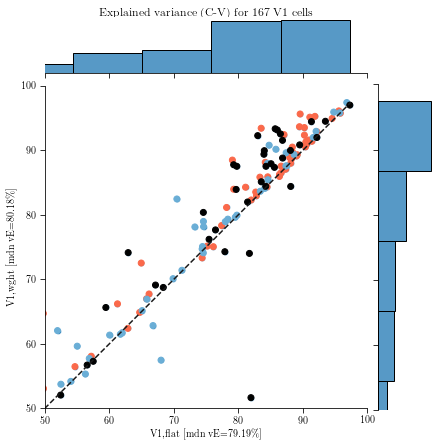

In [2960]:
use_cv = True;
clr_by_expt = True;

saveName = '05_03a_vExp%s_scatterAA.pdf' % ('CV' if use_cv else '')

cv_str = ' (C-V)' if use_cv else ''
clip_low = -10

varExpl_curr = varExpl_CV if use_cv else varExpl
varExpl_curr = np.clip(varExpl_curr, clip_low, None);

expNames = np.array([modsAll[x]['metadata']['fullPath'].split('/')[-3] for x in modsAll.keys()]);
exp_colors = [exp_clr(x) for x in expNames];

if clr_by_expt:
    ax = sns.jointplot(*np.transpose(varExpl_curr[:,inds_curr]))#, kind='reg')#, scatter=False)
    exp_colors = [exp_clr(x) for x in expNames];
    ax.ax_joint.scatter(*np.transpose(varExpl_curr[:,inds_curr]), color=exp_colors)
else:
    ax = sns.jointplot(*np.transpose(varExpl_curr[:,inds_curr]))

rng = [np.minimum(np.nanmin(varExpl_curr[:,inds_curr[0]]), np.nanmin(varExpl_curr[:,inds_curr[1]])),
       np.maximum(np.nanmax(varExpl_curr[:,inds_curr[0]]), np.nanmax(varExpl_curr[:,inds_curr[1]]))]

for i,(lbl,ind) in enumerate(zip(strs_curr,inds_curr)):
    if i==0:
        ax.ax_joint.set_xlabel('%s [mdn vE=%.2f\%%]' % (lbl, np.nanmedian(varExpl_curr[:,ind])));
    elif i==1:
        ax.ax_joint.set_ylabel('%s [mdn vE=%.2f\%%]' % (lbl, np.nanmedian(varExpl_curr[:,ind])));

ax.ax_joint.axis('scaled');
ax.ax_joint.plot(rng,rng,color='k',linestyle='--');
ax.ax_joint.set_title('Explained variance%s for %d V1 cells' % (cv_str, len(varExpl_curr)), y=1.2);

# now save
ax.ax_joint.set_xlim([50, 100])
ax.ax_joint.set_ylim([50, 100])
f = ax.fig
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close();

In [2961]:
dfz = np.diff(varExpl_curr[:,inds_curr])

<>:8: DeprecationWarning: invalid escape sequence \%


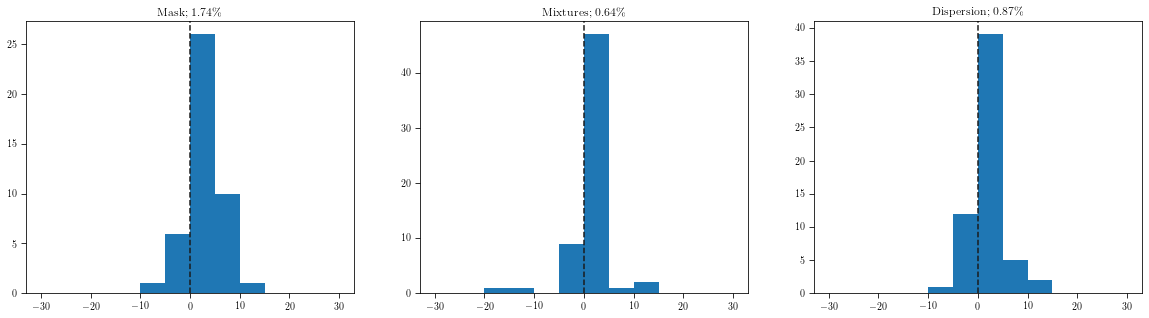

In [2964]:
f, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True);
unq = np.unique(exp_colors, axis=0)
dfz = np.diff(varExpl_curr[:,inds_curr]).flatten()
for iii,clr_curr in enumerate(unq):
    curr_inds = [np.all(x) for x in np.isin(exp_colors, clr_curr)]
    ax[iii].hist(dfz[curr_inds], bins=np.linspace(-30, 30, 13))
    ax[iii].axvline(0, color='k', linestyle='--')
    ax[iii].set_title('%s; %.2f\%%' % (exp_clr(clr_curr, invert=True), np.nanmedian(dfz[curr_inds])));

In [2727]:
diffz = np.diff(varExpl_curr[:, inds_curr]).flatten()
odds = np.where(np.logical_and(np.abs(diffz)<0.2, varExpl_curr[:,inds_curr[0]]>85))[0]
print(odds)

[  3  12  20  31  33  35  45  51  56  61  63 152]


In [2728]:
[print('  %s/%d: \t[%.2f, %.2f]' % (expNames[currInd],
                     modsAll[currInd]['metadata']['cellNum'],
                              *curr_data[currInd,inds_curr,percInd])) for currInd in odds]

  V1_orig/4: 	[0.00, 3.76]
  V1_orig/13: 	[0.00, -0.33]
  V1_orig/21: 	[0.00, -0.37]
  V1_orig/32: 	[0.00, -0.40]
  V1_orig/34: 	[0.00, -0.32]
  V1_orig/36: 	[0.00, -0.22]
  V1_orig/46: 	[0.00, 0.05]
  V1_orig/52: 	[0.00, 0.70]
  V1_orig/57: 	[0.00, 0.96]
  altExp/3: 	[0.00, 2.19]
  altExp/5: 	[0.00, 0.21]
  V1_BB/33: 	[0.00, -0.07]


[None, None, None, None, None, None, None, None, None, None, None, None]

Now, we'll convert varExpl into color!

In [2711]:
sqrt_trans = lambda x: np.sign(x)*np.sqrt(np.abs(x))

<>:38: DeprecationWarning: invalid escape sequence \%


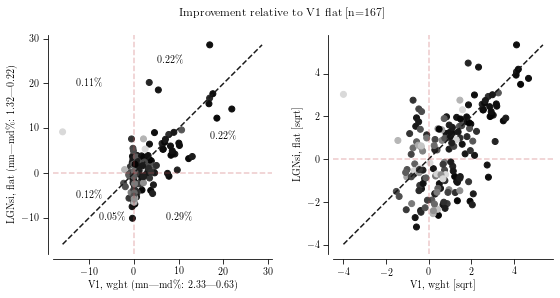

In [2361]:
which_data = 2 # 0/1/2 (non-CV/train/test)
dataStr = '_cvTest' if which_data==2 else '_cvTrain' if which_data==1 else '';

curr_data = dataOrg[which_data];
varExpl_curr = varExpl_CV if which_data>0 else varExpl

saveName = '05_03b_percNLL_scatter%sAA.pdf' % dataStr

nrow, ncol = 1, 2; # once as normal, once as sqrt of improvement

f, ax = plt.subplots(nrow,ncol,figsize=(4*ncol,4*nrow));

# low_clip = None # prct
low_clip = -20 # prct

# temporarily to avoid bad scales, make the minimum no smaller than low_clip
mn = np.maximum(low_clip, np.minimum(*np.nanmin(curr_data[:,inds_curr,percInd],axis=0)))
mx = np.maximum(low_clip, np.maximum(*np.nanmax(curr_data[:,inds_curr,percInd],axis=0)))

mdns = np.nanmedian(curr_data[:,inds_curr,percInd], axis=0)
means = np.nanmean(curr_data[:,inds_curr,percInd], axis=0)

clrs = cm.gray_r(np.linspace(0.15, 1, 100)) # why 100? cap varExpl at 0 --> goes up to 100
vExp_clip_int = np.round(np.clip(varExpl_curr, 0, None)).astype('int8');

lgnStrs = []; normStrs = [];
for modN in inds_curr:
    lVal, nVal = modsAll[akey]['model']['inputsSpecified']['lgnFrontEnd'][modN], modsAll[akey]['model']['inputsSpecified']['normType'][modN]
    lgnStr = hf.lgnType_suffix(lVal).replace('_','');
    lgnStr = 'V1' if lgnStr=='' else lgnStr;
    normModStr = hf.fitType_suffix(nVal).replace('_','')
    lgnStrs.append(lgnStr);
    normStrs.append(normModStr)

for curr_plt in range(ncol):

    sqrt_str = ' [sqrt]' if curr_plt==1 else ''
    dtls_str_x = ' (mn|md\%%: %.2f|%.2f)' % (means[0], mdns[0])
    dtls_str_y = ' (mn|md\%%: %.2f|%.2f)' % (means[1], mdns[1])
    
    ax[curr_plt].set_xlabel('%s, %s%s%s' % (lgnStrs[0], normStrs[0], sqrt_str, dtls_str_x if curr_plt==0 else ''))
    ax[curr_plt].set_ylabel('%s, %s%s%s' % (lgnStrs[1], normStrs[1], sqrt_str, dtls_str_y if curr_plt==0 else ''))
    if curr_plt==0:
        ax[curr_plt].plot([mn,mx], [mn,mx], 'k--');
        ax[curr_plt].scatter(*np.transpose(np.clip(curr_data[:,inds_curr,percInd], low_clip, None)),
                            color=clrs[np.nanmean(vExp_clip_int[:,inds_curr], axis=1).astype('int')]);
    elif curr_plt==1: # sqrt!
        ax[curr_plt].plot(sqrt_trans([mn,mx]), sqrt_trans([mn,mx]), 'k--');
        ax[curr_plt].scatter(*np.transpose(sqrt_trans(np.clip(curr_data[:,inds_curr,percInd], low_clip, None))),
                            color=clrs[np.nanmean(vExp_clip_int[:,inds_curr], axis=1).astype('int')]);

    ax[curr_plt].axis('scaled')
    # and zero lines
    ax[curr_plt].axhline(0, color='r', linestyle='--', alpha=0.3)
    ax[curr_plt].axvline(0, color='r', linestyle='--', alpha=0.3)

#     for jj, axis in enumerate([ax[row_ind, col_ind].xaxis, ax[row_ind, col_ind].yaxis]):
#         axis.set_major_formatter(FuncFormatter(lambda x,y: '%d' % x if x>=1 else '%.1f' % x)) # this will make everything in non-scientific notation!
#         if jj==1: # i.e. y axis, make sure we have tick labels, here, too
#             axis.set_tick_params(labelleft=True); 

### what perc. in each (sub) quadr?
nCells = len(curr_data[:,inds_curr,percInd])
a_gt_b = np.diff(curr_data[:,inds_curr,percInd]).flatten()>0
b_gt_a = np.diff(curr_data[:,inds_curr,percInd]).flatten()<0
both_gt0 = np.logical_and(*np.transpose(curr_data[:,inds_curr,percInd]>0))
both_lt0 = np.logical_and(*np.transpose(curr_data[:,inds_curr,percInd]<0))
# in q1, below and then above diagonal
ax[0].text(20, 8, '%.2f\%%' % (np.sum(both_gt0 & a_gt_b)/nCells), horizontalalignment='center', verticalalignment='center')
ax[0].text(8, 25, '%.2f\%%' % (np.sum(both_gt0 & b_gt_a)/nCells), horizontalalignment='center', verticalalignment='center')
# in q3, below and then above diagonal
ax[0].text(-5, -10, '%.2f\%%' % (np.sum(both_lt0 & a_gt_b)/nCells), horizontalalignment='center', verticalalignment='center')
ax[0].text(-10, -5, '%.2f\%%' % (np.sum(both_lt0 & b_gt_a)/nCells), horizontalalignment='center', verticalalignment='center')
# i.e. x-axis neg, y-axis pos
quadr_2 = np.logical_and(curr_data[:,inds_curr[0],percInd]<0, curr_data[:,inds_curr[1],percInd]>0)
ax[0].text(-10, 20, '%.2f\%%' % (np.sum(quadr_2)/nCells), horizontalalignment='center', verticalalignment='center')
# i.e. x-axis pos, y-axis neg
quadr_4 = np.logical_and(curr_data[:,inds_curr[0],percInd]>0, curr_data[:,inds_curr[1],percInd]<0)
ax[0].text(10, -10, '%.2f\%%' % (np.sum(quadr_4)/nCells), horizontalalignment='center', verticalalignment='center')


f.suptitle('Improvement relative to V1 flat [n=%d]' % (nCells));
f.tight_layout();
sns.despine(offset=5);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()


# print which are farthest away from diagonal?
abs_order = True
howMany = 5;
strt = 0
# ----
diffs = np.diff(curr_data[:,inds_curr,percInd]).flatten()
# Here, negative values mean the second model has a higher improvement over the flat model, as compared to first model
if abs_order:
    asort = np.argsort(-np.abs(diffs))
else:
    asort = np.argsort(diffs)
whichOnes = np.arange(strt,strt+howMany)

In [2362]:
print('Farthest off diagonal:')
[print('  %s/%d: \t[%.2f, %.2f]' % (expNames[currInd],
                     modsAll[currInd]['metadata']['cellNum'],
                              *curr_data[currInd,inds_curr,percInd])) for currInd in asort[whichOnes]]

Farthest off diagonal:
  V1/43: 	[-15.92, 9.19]
  altExp/1: 	[3.42, 20.22]
  V1_orig/27: 	[5.46, 18.55]
  V1_BB/24: 	[16.93, 28.62]
  V1_orig/13: 	[-0.33, -10.11]


[None, None, None, None, None]

In [2298]:
ok_cells = np.array([np.all(~np.isnan(x)) for x in varExpl_curr])

prctle = 15

print(np.percentile(varExpl_curr[ok_cells, inds_curr[0]], prctle, axis=0))
print(np.percentile(varExpl_curr[ok_cells, inds_curr[1]], prctle, axis=0))

42.88408130884609
38.39252664204524


In [2315]:
np.sum(varExpl_curr[ok_cells,inds_curr[1]]>40)/len(ok_cells)

0.8323353293413174

In [2374]:
make_nice_str = lambda ky: '%s/%d'% (modsAll[ky]['metadata']['fullPath'].split('/')[-3], modsAll[ky]['metadata']['cellNum'])

In [2411]:
currs_ = np.where(np.logical_and(varExpl_curr[:, inds_curr[0]]>20, varExpl_curr[:, inds_curr[0]]<40))[0]


In [2414]:
nRand = 10;
currs_ = np.where(varExpl_curr[:, inds_curr[0]]>80)[0]
print('Very good [n=%d]: (vExp>80%%)' % len(currs_))
print([make_nice_str(x) for x in np.random.permutation(currs_)[0:nRand]])
currs_ = np.where(np.logical_and(varExpl_curr[:, inds_curr[0]]>50, varExpl_curr[:, inds_curr[0]]<80))[0]
print('\nGood [n=%d]: (80%%>vExp>50%%)' % len(currs_))
print([make_nice_str(x) for x in np.random.permutation(currs_)[0:nRand]])
currs_ = np.where(np.logical_and(varExpl_curr[:, inds_curr[0]]>40, varExpl_curr[:, inds_curr[0]]<50))[0]
print('\nOK [n=%d]: (50%%>vExp>40%%)' % len(currs_))
print([make_nice_str(x) for x in currs_])
currs_ = np.where(np.logical_and(varExpl_curr[:, inds_curr[0]]>20, varExpl_curr[:, inds_curr[0]]<40))[0]
print('\nBad [n=%d]: (40%%>vExp>20%%)' % len(currs_))
print([make_nice_str(x) for x in currs_])
currs_ = np.where(varExpl_curr[:, inds_curr[0]]<20)[0]
print('\nReally bad [n=%d]: (vExp<20%%)' % len(currs_))
print([make_nice_str(x) for x in currs_]);


Very good [n=83]: (vExp>80%)
['V1_BB/2', 'V1_BB/36', 'V1/25', 'V1_orig/36', 'V1_BB/4', 'V1/42', 'V1_orig/21', 'V1_orig/47', 'V1_orig/22', 'V1_BB/40']

Good [n=53]: (80%>vExp>50%)
['V1_orig/25', 'V1_BB/35', 'V1/55', 'V1_orig/39', 'V1/31', 'V1/10', 'V1/26', 'V1/6', 'V1_orig/16', 'V1_BB/23']

OK [n=6]: (50%>vExp>40%)
['V1_orig/12', 'V1/24', 'V1/33', 'V1/46', 'V1_BB/8', 'V1_BB/43']

Bad [n=11]: (40%>vExp>20%)
['V1/2', 'V1/4', 'V1/18', 'V1/19', 'V1/20', 'V1/34', 'V1/39', 'V1/45', 'V1/48', 'V1_BB/1', 'V1_BB/9']

Really bad [n=13]: (vExp<20%)
['V1_orig/19', 'altExp/8', 'V1/1', 'V1/9', 'V1/11', 'V1/35', 'V1/43', 'V1/47', 'V1/52', 'V1_BB/5', 'V1_BB/10', 'V1_BB/11', 'V1_BB/47']


In [2112]:
dfz = np.diff(varExpl_CV[:,inds_curr])
to_check = np.where(np.abs(dfz)>20)[0]
# print(to_check)

In [2065]:
# ky = 99;
# ky = 107;
# ky = 147
# ky = 160
# ky = 162
ky = to_check[0]
modsAll[ky]['metadata']['fullPath'].split('/')[-3], modsAll[ky]['metadata']['cellNum']

('V1_BB', 26)

___
##### Older stuff below...could be useful?
First as scatter

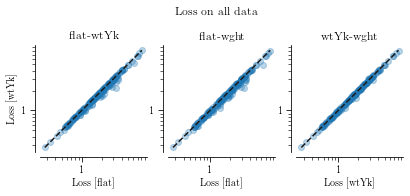

In [163]:
saveName = '05_01_01_NLL_scatter.pdf'

nr,nc = 1,3
f, ax = plt.subplots(nr,nc,figsize=hf.set_size(width=tex_width, subplots=(nr,nc), extra_height=2))
# f, ax = plt.subplots(nr,nc,figsize=(5*nc,5*nr))

for i, (modX,modY) in enumerate(itertools.combinations(range(3), 2)):

    ax[i].scatter(NLLs[modX,:], NLLs[modY,:], alpha=0.3);
    mn = np.minimum(np.nanmin(NLLs[modX,:]), np.nanmin(NLLs[modY,:]))
    mx = np.maximum(np.nanmax(NLLs[modX,:]), np.nanmax(NLLs[modY,:]))

    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
   
    ax[i].set_xlabel('Loss [%s]' % mod_labels[modX])
    if i==0:
        ax[i].set_ylabel('Loss [%s]' % mod_labels[modY])
    ax[i].set_title('%s-%s' % (mod_labels[modX], mod_labels[modY]))
    ax[i].plot([mn,mx], [mn,mx], 'k--');
    ax[i].axis('scaled')
    
    for jj, axis in enumerate([ax[i].xaxis, ax[i].yaxis]):
        axis.set_major_formatter(FuncFormatter(lambda x,y: '%d' % x if x>=1 else '%.1f' % x)) # this will make everything in non-scientific notation!
        if jj==1: # i.e. y axis, make sure we have tick labels, here, too
            axis.set_tick_params(labelleft=True); 

f.suptitle('Loss on all data')#, y=0.95);
sns.despine(offset=5);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

Then as hist

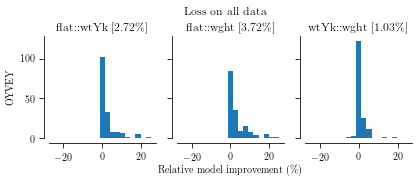

In [165]:
nr,nc = 1,3

saveName = '05_01_01_NLL_hist.pdf'

f, ax = plt.subplots(nr,nc,figsize=hf.set_size(width=tex_width, subplots=(nr,nc), extra_height=1.4), sharex=True, sharey=True)

bins = np.linspace(-25, 25, 20)

for i, (modX,modY) in enumerate(itertools.combinations(range(3), 2)):

    rats = 100*(NLLs[modX,:]-NLLs[modY,:])/NLLs[modX,:]
    
    ax[i].hist(rats, bins=bins);
 
    if i == 1:
        ax[i].set_xlabel('Relative model improvement (\%)')
    if i==0:
        ax[i].set_ylabel('OYVEY')

    ax[i].set_title('%s::%s [%.2f\%%]' % (mod_labels[modX], mod_labels[modY], np.nanmean(rats)))
    
#     for jj, axis in enumerate([ax[i].xaxis, ax[i].yaxis]):
#         axis.set_major_formatter(FuncFormatter(lambda x,y: '%d' % x if x>=1 else '%.1f' % x)) # this will make everything in non-scientific notation!
#         if jj==1: # i.e. y axis, make sure we have tick labels, here, too
#             axis.set_tick_params(labelleft=True); 

f.suptitle('Loss on all data', y=1.1);
sns.despine(offset=5);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

#### 5.1.2 Cross-validation

<>:17: DeprecationWarning: invalid escape sequence \%


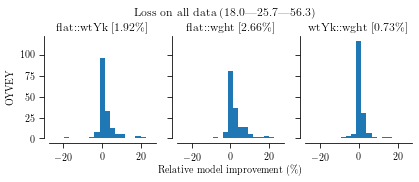

In [166]:
nr,nc = 1,3

saveName = '05_01_02_cvTe_hist.pdf'


f, ax = plt.subplots(nr,nc,figsize=hf.set_size(width=tex_width, subplots=(nr,nc), extra_height=1.4), sharex=True, sharey=True)

bins = np.linspace(-25, 25, 20)

for i, (modX,modY) in enumerate(itertools.combinations(range(3), 2)):

    rats = 100*(NLLs_te[modX,:]-NLLs_te[modY,:])/NLLs_te[modX,:]
    
    ax[i].hist(rats, bins=bins);
 
    if i == 1:
        ax[i].set_xlabel('Relative model improvement (\%)')
    if i==0:
        ax[i].set_ylabel('OYVEY')

    ax[i].set_title('%s::%s [%.2f\%%]' % (mod_labels[modX], mod_labels[modY], np.nanmean(rats)))
    
#     for jj, axis in enumerate([ax[i].xaxis, ax[i].yaxis]):
#         axis.set_major_formatter(FuncFormatter(lambda x,y: '%d' % x if x>=1 else '%.1f' % x)) # this will make everything in non-scientific notation!
#         if jj==1: # i.e. y axis, make sure we have tick labels, here, too
#             axis.set_tick_params(labelleft=True); 

# Now, compute how often each model was the best?
reg = np.argmin(NLLs_te[:, ok_inds], axis=0)
_, winners = np.unique(reg, return_counts=True);

f.suptitle('Loss on all data (%.1f|%.1f|%.1f)' % (*(100*winners/len(ok_inds)), ), y=1.1);
sns.despine(offset=5);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

#### TODO?:
- Compare with/without free respExp _within_ models (i.e. noRE...flat vs. ...flat, etc.)
- Compare with/without LGN...

# 6. Analysis! Superposition

##### First, gather all of the data (from the jointLists) and put into a dataframe

In [867]:
autoreload.reload(hf);

In [851]:
def pearson_r_pandas(to_use, metr_a, metr_b, verbose=False):
    valz = np.transpose(to_use[[metr_a, metr_b]].dropna().values, )
    rv, pv = ss.pearsonr(*valz)
    if verbose:
        print('[n=%d] r2=%.1e, p=%.1e [%s %s]' % (valz.shape[1], rv, pv, metr_a, metr_b))
    return rv, pv, valz.shape[1]

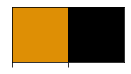

In [852]:
lgn = hf.np_smart_load('jointList_LGN_230121_vT00_dvT00_jt7.npy')
v1 = hf.np_smart_load('jointList_wMods_V1_230121vE_vT00_dvT00_m3j10.npy')

lgn_full_disps = np.where([len(lgn[x]['metadata']['stimVals'][0])>2 for x in lgn.keys()])[0];
v1_full_disps = np.where([np.logical_and('sfErrsInd_var_prince' in v1[x]['superpos'], len(v1[x]['metadata']['stimVals'][0])>2) for x in v1.keys()])[0];

# set up colors...
colors = sns.color_palette('colorblind', n_colors=2) # lgn color first
colors.append((0,0,0)); # add black!

colors = colors[1:] # ignore the first color
sns.palplot(colors)

In [1044]:
whichExps = ['lgn', 'v1'];

df = None;
area_all = [];
type_all = [];
# vThresh = 10 #-np.Inf
vThresh = 0 #-np.Inf

for which_exp in whichExps:

    which_jl = lgn if which_exp=='lgn' else v1;
    which_nms = lgn_full_disps if  which_exp=='lgn' else v1_full_disps

    if which_jl == lgn:
        full_disps = [len(lgn[x]['metadata']['stimVals'][0])>2 for x in lgn.keys()];
    else:
        full_disps = [np.logical_and('sfErrsInd_var_prince' in v1[x]['superpos'], len(v1[x]['metadata']['stimVals'][0])>2) for x in v1.keys()];

    area = [which_exp] * len(which_jl);
    ####
    # tuning, basic metrics
    # --- note: [0] following jl_get_metric_byCon is to get only the first output (i.e. ignore the con. vals)
    ####
    respMeasure = hf.jl_get_metric_byCon(which_jl, ['respMeasure'], conVal=None, disp=None, fieldOverwrite='metadata')[0]
    if which_exp == 'lgn':
        cellType = np.array([which_jl[x]['metadata']['cellType'] for x in which_jl.keys()])
        non_mp = np.logical_and(~(cellType=='parvo'), ~(cellType=='magno'))
        cellType[non_mp] = 'other'
    elif which_exp == 'v1':
        cellType = respMeasure.astype('bool'); # i.e. cellType becomes 'is it simple?'

    cellNum = hf.jl_get_metric_byCon(which_jl, ['cellNum'], conVal=None, disp=None, fieldOverwrite='metadata')[0].astype('int')
    slps = -hf.jl_get_metric_byCon(which_jl, 'dog_mod_slope', conVal=None, disp=0)[0]
    bw34_split = hf.jl_get_metric_byCon(which_jl, 'dog_bw34_split', conVal=1, disp=0)[0][:, 1]
    bw34 = hf.jl_get_metric_byCon(which_jl, 'dog_bw34', conVal=1, disp=0)[0]
    bwHalf_split = hf.jl_get_metric_byCon(which_jl, 'dog_bwHalf_split', conVal=1, disp=0)[0][:, 1]
    bwHalf = hf.jl_get_metric_byCon(which_jl, 'dog_bwHalf', conVal=1, disp=0)[0]
    suprInd_model = hf.jl_get_metric_byCon(which_jl, ['rfsize', 'suprInd_model'], conVal=None, disp=None, fieldOverwrite='basics')[0]
    rfsize = hf.jl_get_metric_byCon(which_jl, ['rfsize', 'gsf_model'], conVal=None, disp=None, fieldOverwrite='basics')[0]
    rfsize_surr = hf.jl_get_metric_byCon(which_jl, ['rfsize', 'surrDiam_model'], conVal=None, disp=None, fieldOverwrite='basics')[0]
    oriBW = hf.jl_get_metric_byCon(which_jl, ['ori', 'bw'], conVal=None, disp=None, fieldOverwrite='basics')[0]
    # other metrics...
    hiCon_varExpl = hf.jl_get_metric_byCon(which_jl, 'dog_varExpl', conVal=1, disp=0)[0] # highest con.
    charFreq = hf.jl_get_metric_byCon(which_jl, 'dog_charFreq', conVal=1, disp=0)[0] # highest con.
    # --- all boot values are NaN for now...would need to re-run
#     charFreq_std = hf.jl_get_metric_byCon(which_jl, 'boot_dog_charFreq_values', conVal=1, disp=0)[0] # highest con.
    f1f0_ratio = hf.jl_get_metric_byCon(which_jl, 'f1f0_ratio', conVal=None, disp=None)[0]
    mn_med_max = hf.jl_get_metric_byCon(which_jl, 'mn_med_max', conVal=None, disp=None)[0]
    mn, md, mx = np.transpose(mn_med_max);
    # c50 stuff (from superposition)
    c50_pref = hf.jl_get_metric_byCon(which_jl, ['disp0_c50'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    c50_pref_emp = hf.jl_get_metric_byCon(which_jl, ['disp0_c50_emp'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    ####
    # mixture metrics
    ####
    sfErrs = hf.jl_get_metric_byCon(which_jl, ['sfErrsInd_wtdVar_prince'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    sfErrs_boot = hf.jl_get_metric_byCon(which_jl, ['sfErrsInd_wtdVar_prince_boot'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    sfErrs_boot_std = np.nanstd(sfErrs_boot, axis=1)
    sfErrs_boot_mdn = np.nanmedian(sfErrs_boot, axis=1)
    super_varExpl = hf.jl_get_metric_byCon(which_jl, ['var_expl'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    super_varExpl_boot = hf.jl_get_metric_byCon(which_jl, ['var_expl_boot'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    super_varExpl_std = np.nanstd(super_varExpl_boot, axis=1)
    super_varExpl_std_clip = np.nanstd(np.clip(super_varExpl_boot, -50, None), axis=1)
    c50_summ = hf.jl_get_metric_byCon(which_jl, ['rel_c50'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    c50_summ_emp = hf.jl_get_metric_byCon(which_jl, ['rel_c50_emp'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    c50_summ_emp_boot = hf.jl_get_metric_byCon(which_jl, ['rel_c50_emp_boot'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    auc = hf.jl_get_metric_byCon(which_jl, ['supr_area'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    auc_boot_std = np.nanstd(hf.jl_get_metric_byCon(which_jl, ['supr_area_boot'], conVal=None, disp=None, fieldOverwrite='superpos')[0], axis=1)

    # cut out bad cells...
    threshPass = np.logical_and(full_disps, np.sum(super_varExpl_boot>vThresh, axis=1)>(0.95*super_varExpl_boot.shape[1]))
    # --- also make sure that sfErrs_boot_std>0, b/c ==0 only if there are no repeats!
    threshPass = np.logical_and(threshPass, sfErrs_boot_std>0)
    
    curr_df = pd.DataFrame(data=np.transpose([respMeasure, cellNum, f1f0_ratio, hiCon_varExpl, charFreq, 
                                              slps, bwHalf_split, bwHalf, bw34_split, bw34, rfsize, rfsize_surr, 
                                              suprInd_model, oriBW, mn, md, mx, c50_pref, c50_pref_emp, 
                                              sfErrs, sfErrs_boot_std, sfErrs_boot_mdn, 
                                              super_varExpl, super_varExpl_std, super_varExpl_std_clip,
                                              auc, auc_boot_std,
                                              c50_summ, c50_summ_emp, full_disps, threshPass]), 
                           columns=['isSimple', 'cellNum', 'f1f0', 'sfVarExpl', 'charFreq',  
                                    'slope', 'bwHalf_split', 'bwHalf', 'bw34_split', 'bw34', 'rfsize', 'rfsize_surr', 
                                    'suprInd', 'oriBW', 'meanResp', 'mdnResp', 'maxResp', 'c50_pref', 'c50_pref_emp', 
                                    'sfErrs', 'sfErrsBootStd', 'sfErrsBootMdn', 
                                    'super_varExpl', 'super_varExpl_std', 'svesc', 
                                    'auc', 'auc_std',
                                    'c50_summ', 'c50_summ_emp', 'isFullDisp', 'threshPass'],)
    area_all.append(area);
    type_all.append(cellType);
    if df is None:
        df = curr_df;
    else:
        df = df.append(curr_df)
    
# adding string fields after to avoid other fields being bad...
df.insert(0, 'area', hf.flatten_list(area_all))
df.insert(1, 'cellType', hf.flatten_list(type_all))
df['threshPass'] = df['threshPass'].astype('bool')
df['cellNum'] = df['cellNum'].astype('int')
df['super_varExpl_clip'] = np.clip(df['super_varExpl'], -10, None);
# why duplicating? to make sns.plots easier (can't handle underscores with latex nonesense)
df['svec'] = df['super_varExpl_clip']
df['c50emp'] = df['c50_pref_emp'];
df['aucStd'] = df['auc_std'];
# df['super_varExpl_clip'] = np.clip(df['super_varExpl'], -10, None);
# now subset to only full!
df_only_full = df[df['isFullDisp'].astype('bool')]
df_only_pass = df_only_full[df_only_full['threshPass']]
df_only_fail = df_only_full[~df_only_full['threshPass']]

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [1045]:
# get color scheme
area_colors = [];
toGroups = ['cellType', 'cellType']; # corresponding to LGN, V1

pds_split = [df[df['area']=='lgn'], df[df['area']=='v1']]

for mega, whichArea, toGroup in zip(pds_split, whichExps, toGroups):

    cnt = 0;
    grp_names = [];
    for nm, group in mega.groupby(toGroup, sort=False):
        cnt += 1;
        grp_names.append(nm)

    # colors = cm.viridis(np.linspace(0.15, 0.95, cnt))
    if whichArea=='v1':
#         colors = sns.color_palette('husl', n_colors=cnt-1)
        colors = sns.color_palette('viridis', n_colors=cnt-1)
        colors.append((0,0,0)); # add black!
    else: # lgn...
        # why adding extra colors?
        # well, the 3rd color looks like the first in viridis
        colors = sns.color_palette('colorblind', n_colors=cnt+2)
        # so we'll add extras and swap with the desirable one
        colors[2] = colors[4]
        colors = sns.color_palette(colors[0:3])
        
    area_colors.append(colors)

In [1046]:
area_colors[0]

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.8, 0.47058823529411764, 0.7372549019607844)]

In [1047]:
area_colors[1]

[(0.127568, 0.566949, 0.550556), (0, 0, 0)]

### 6.0: How much does the Naka-Rushton fit to the data explain mixture summation?

In [1048]:
# NOTE: Rough template for making per-group (i.e. m/p/o, s/c) plots...
# sns.histplot(data=which_data[which_data['area']=='v1'], x='svec', multiple='stack', 
#              hue='cellType', palette=area_colors[1], bins=bins)

<>:38: DeprecationWarning: invalid escape sequence \%


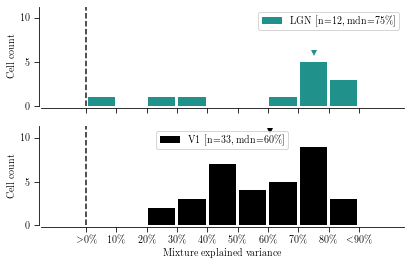

In [1049]:
subset_full = False;
# if true, then plot for all
# if false, then only those that pass

saveName = '06_00_superposVarExpl_lgn_v1_%s.pdf' % ('full' if subset_full else 'pass')

which_data = df_only_full if subset_full else df_only_pass;

ars = df['area'].unique();

nrow,ncol=2,1
f, ax = plt.subplots(nrow,ncol,figsize=hf.set_size(tex_width), sharey=True, sharex=True);

# clipLow = -10
# clipHigh = None;
kywrd = 'super_varExpl'
use_norm = False;

# bins for sfErr metric
bins = np.linspace(-10, 100, 12)
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
width = hist_width*stepSize;

for (plt_i, (name,group)), clr in zip(enumerate(which_data.groupby('area')), colors):
    
    vls = group[kywrd].values;
    clipped = np.clip(vls, clipLow, clipHigh);
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)
    
    to_use = vals_norm if use_norm else vals;
    
    ax[plt_i].bar(binPlotLocs, to_use, width=width, align='center', color=clr,
                 label='%s [n=%d, mdn=%d\%%]' % (name.upper(), len(vls), np.nanmedian(vls)));
    
    tickStrs = ['%d\%%' % x for x in tickVals];
    tickStrs[0] = '$>$%s' % tickStrs[0];
    tickStrs[-1] = '$<$%s' % tickStrs[-1];
    ax[plt_i].set_xticks(tickVals);
    ax[plt_i].set_xticklabels(tickStrs);
    ax[plt_i].plot(np.nanmedian(vls), 1.2*np.nanmax(to_use), 'v', color=clr)
    ax[plt_i].axvline(0, color='k', linestyle='--')
#     ax[plt_i].set_title('%s: mdn=%.2e [n=%d]' % (area.upper(), np.nanmedian(vls), len(vls)))

    ax[plt_i].legend();
    ax[plt_i].set_ylabel('Fraction of cells' if use_norm else 'Cell count');
    if plt_i==nrow-1:
        ax[plt_i].set_xlabel('Mixture explained variance');

sns.despine(offset=sns_offset)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

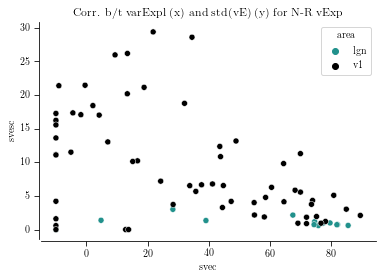

In [1050]:
sns.scatterplot(data=df_only_full, x='svec', y='svesc', hue='area', palette=colors);
plt.title('Corr. b/t varExpl (x) and std(vE) (y) for N-R vExp');

saveName = '06_00a_superposVarExplVar_lgn_v1.pdf'

sns.despine(offset=sns_offset)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

In [1051]:
df_only_full.iloc[np.where(np.logical_and(df_only_full['svec']<5, df_only_full['svesc']<5))[0]]

area cellType  isSimple  cellNum  f1f0  sfVarExpl  charFreq  slope  \
78   lgn    magno     1.000       79 2.710     93.535     2.872  0.133   
80   lgn    magno     1.000       81 1.853        nan       nan    nan   
66    v1    False     0.000        8 0.624     -2.765     0.122 -0.083   
79    v1    False     0.000       13 0.180   -389.303    41.968  0.962   
112   v1    False     0.000       46 0.399     10.079     6.450  0.000   
118   v1    False     0.000       52 0.126      1.470     8.836  1.000   

     bwHalf_split  bwHalf  ...   auc  auc_std  c50_summ  c50_summ_emp  \
78          1.116   2.707  ... 0.284    0.006     0.041         0.038   
80            nan     nan  ... 0.000    0.047     0.000         0.500   
66          0.519     nan  ... 0.000    0.018     1.500         0.500   
79          0.000     nan  ... 0.000    0.000     1.500         0.500   
112         0.531   1.322  ... 0.056    0.034     1.500         0.375   
118           nan     nan  ... 0.000    0.009     1.500         0.500   

     isFullDisp  threshPass  super_varExpl_clip    svec  c50emp  aucStd  
78        1.000        True               4.763   4.763   0.074   0.006  
80        1.000       False             -10.000 -10.000   0.400   0.047  
66        1.000       False             -10.000 -10.000   0.078   0.018  
79        1.000       False             -10.000 -10.000   0.050   0.000  
112       1.000       False             -10.000 -10.000   0.153   0.034  
118       1.000       False             -10.000 -10.000   0.050   0.009  

[6 rows x 37 columns]

### 6.1 Inclusion/exclusion
We excluded all cells which did not have at least 95% of bootstrap repeats with at least _some_ explained variance in the summation (read vExp>0%). What are the properties of those cells versus those without?

Note that this analysis is only relevant for V1, since only 1 LGN cell was exclude:

In [1052]:
df_only_full.groupby(['area', 'threshPass'])['maxResp', 'meanResp', 'oriBW', 'bw34', 'bw34_split',
                                             'bwHalf', 'bwHalf_split', 'c50_pref_emp', 'rfsize', 'rfsize_surr', 
                                             'suprInd', 
                                   'f1f0', 'sfVarExpl', 'isSimple', 'charFreq'].mean()

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


maxResp  meanResp  oriBW  bw34  bw34_split  bwHalf  \
area threshPass                                                       
lgn  False        34.000    16.205    nan   nan         nan     nan   
     True         39.892    23.376    nan 1.612       2.176   2.612   
v1   False        29.092    12.300 65.211 1.377       0.910   2.176   
     True         50.755    15.363 78.355 1.671       1.011   2.617   

                 bwHalf_split  c50_pref_emp  rfsize  rfsize_surr  suprInd  \
area threshPass                                                             
lgn  False                nan         0.400   0.480        1.770    0.268   
     True               2.644         0.283   0.842        1.610    0.136   
v1   False              1.253         0.386   1.583        4.698    0.455   
     True               1.365         0.309   1.517        3.835    0.424   

                 f1f0  sfVarExpl  isSimple  charFreq  
area threshPass                                       
lgn  False      1.853        nan     1.000       nan  
     True       1.857     79.248     1.000     2.843  
v1   False      0.723     46.509     0.233     5.760  
     True       0.955     86.016     0.394     4.745

It seems that the failed V1 cells have a substantially lower maximum firing rate, show less surround suppression, and show a much lower explained variance for single grating SF tuning at high contrast.

Let's test this statistically:

In [1053]:
df_only_full_v1 = df_only_full[df_only_full['area']=='v1']

In [1054]:
to_test = ['maxResp', 'meanResp', 'oriBW', 'bw34', 'bw34_split', 'bwHalf', 'bwHalf_split', 'c50_pref_emp', 'suprInd', 
                                   'f1f0', 'sfVarExpl', 'isSimple', 'charFreq']
for fld in to_test:
    valz = (*df_only_full_v1.groupby('threshPass')[fld].apply(list), )
    ncells = [len(x) for x in valz]
    tst_t = ss.ttest_ind(*valz, nan_policy='omit')
    tst_k = ss.ks_2samp(*valz, )
    
    print('%s %.2f[%d] vs %.2f[%d]: \n\tp=%.2e [t]\n\tp=%.2e [ks]' % (fld, np.nanmean(valz[0]), ncells[0], 
                                                  np.nanmean(valz[1]), ncells[1], tst_t.pvalue, tst_k.pvalue))
    

maxResp 29.09[30] vs 50.75[33]: 
	p=1.99e-02 [t]
	p=3.44e-01 [ks]
meanResp 12.30[30] vs 15.36[33]: 
	p=3.05e-01 [t]
	p=9.54e-01 [ks]
oriBW 65.21[30] vs 78.35[33]: 
	p=2.20e-01 [t]
	p=2.74e-01 [ks]
bw34 1.38[30] vs 1.67[33]: 
	p=7.64e-02 [t]
	p=3.75e-01 [ks]
bw34_split 0.91[30] vs 1.01[33]: 
	p=7.41e-01 [t]
	p=1.25e-01 [ks]
bwHalf 2.18[30] vs 2.62[33]: 
	p=1.09e-01 [t]
	p=5.72e-01 [ks]
bwHalf_split 1.25[30] vs 1.36[33]: 
	p=7.45e-01 [t]
	p=5.94e-01 [ks]
c50_pref_emp 0.39[30] vs 0.31[33]: 
	p=1.37e-01 [t]
	p=1.73e-01 [ks]
suprInd 0.45[30] vs 0.42[33]: 
	p=7.24e-01 [t]
	p=7.56e-01 [ks]
f1f0 0.72[30] vs 0.96[33]: 
	p=7.92e-02 [t]
	p=3.52e-02 [ks]
sfVarExpl 46.51[30] vs 86.02[33]: 
	p=1.56e-02 [t]
	p=1.01e-04 [ks]
isSimple 0.23[30] vs 0.39[33]: 
	p=1.77e-01 [t]
	p=7.40e-01 [ks]
charFreq 5.76[30] vs 4.75[33]: 
	p=4.91e-01 [t]
	p=9.43e-01 [ks]


##### So, the excluded cells have a statistically lower maxResp, lower explained variance of SF tuning at high contrast, lower f1f0, and higher likelihood of being simple; there is no difference in mean response, oriBw, bw34, c50, suprInd

*Note: The default for all below plots should be only included cells*

### 6.1a

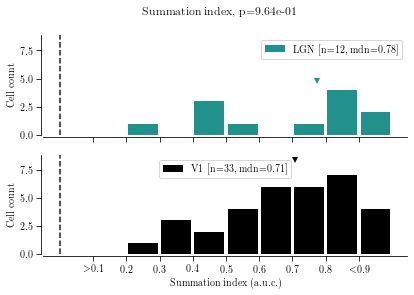

In [1055]:
subset_full = False;
# if true, then plot for all
# if false, then only those that pass

saveName = '06_01_AUC_lgn_v1_%s.pdf' % ('full' if subset_full else 'pass')

which_data = df_only_full if subset_full else df_only_pass;

ars = df['area'].unique();

nrow,ncol=2,1
f, ax = plt.subplots(nrow,ncol,figsize=hf.set_size(tex_width), sharey=True, sharex=True);

# clipLow = -10
# clipHigh = None;
kywrd = 'auc'
use_norm = False;

# bins for sfErr metric
bins = np.linspace(0, 1, 11)
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
width = hist_width*stepSize;

for (plt_i, (name,group)), clr in zip(enumerate(which_data.groupby('area')), colors):
    
    vls = group[kywrd].values;
    clipped = np.clip(vls, clipLow, clipHigh);
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)
    
    to_use = vals_norm if use_norm else vals;
    
    ax[plt_i].bar(binPlotLocs, to_use, width=width, align='center', color=clr,
                 label='%s [n=%d, mdn=%.2f]' % (name.upper(), len(vls), np.nanmedian(vls)));
    
    tickStrs = ['%.1f' % x for x in tickVals];
    tickStrs[0] = '$>$%s' % tickStrs[0];
    tickStrs[-1] = '$<$%s' % tickStrs[-1];
    ax[plt_i].set_xticks(tickVals);
    ax[plt_i].set_xticklabels(tickStrs);
    ax[plt_i].plot(np.nanmedian(vls), 1.2*np.nanmax(to_use), 'v', color=clr)
    ax[plt_i].axvline(0, color='k', linestyle='--')
#     ax[plt_i].set_title('%s: mdn=%.2e [n=%d]' % (area.upper(), np.nanmedian(vls), len(vls)))

    ax[plt_i].legend();
    ax[plt_i].set_ylabel('Fraction of cells' if use_norm else 'Cell count');
    if plt_i==nrow-1:
        ax[plt_i].set_xlabel('Summation index (a.u.c.)');

sns.despine(offset=sns_offset)
ttest = ss.ttest_ind(*which_data.groupby('area')['auc'].apply(list),)
f.suptitle('Summation index, p=%.2e' % (ttest.pvalue))

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

In [1056]:
# TODO: Relate A.U.C. (linearity index) to c50 (single gratings)?

### 6.2 Compare sfVar metric between LGN, V1 for included cells

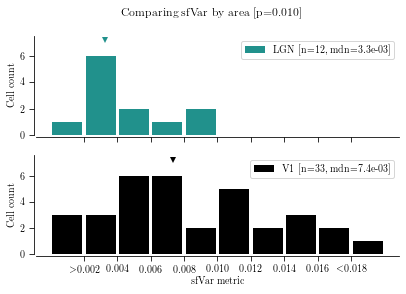

In [1057]:
subset_full = False;
# if true, then plot for all
# if false, then only those that pass

saveName = '06_02_sfVarMetric_lgn_v1_%s.pdf' % ('full' if subset_full else 'pass')

which_data = df_only_full if subset_full else df_only_pass;

# temp...
# err, errStd = np.transpose(which_data[['sfErrs', 'sfErrsBootStd']].dropna().values, )
# cutoff = 1.5*np.max(which_data[which_data['area']=='lgn']['sfErrsBootStd'].values)#np.nanpercentile(errStd, 75)
# which_data = which_data[which_data['sfErrsBootStd']<=cutoff]; # filter out some extreme values

ars = df['area'].unique();

nrow,ncol=2,1
f, ax = plt.subplots(nrow,ncol,figsize=hf.set_size(tex_width), sharey=True, sharex=True);

kywrd = 'sfErrsBootMdn'
use_norm = False;

# bins for sfErr metric
bins = np.linspace(0, 0.02, 11)
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
width = hist_width*stepSize;

for (plt_i, (name,group)), clr in zip(enumerate(which_data.groupby('area')), colors):
    
    vls = group[kywrd].values;
    clipped = np.clip(vls, clipLow, clipHigh);
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)
    
    to_use = vals_norm if use_norm else vals;
    
    ax[plt_i].bar(binPlotLocs, to_use, width=width, align='center', color=clr,
                 label='%s [n=%d, mdn=%.1e]' % (name.upper(), len(vls), np.nanmedian(vls)));
    
    tickStrs = ['%.3f' % x for x in tickVals];
    tickStrs[0] = '$>$%s' % tickStrs[0];
    tickStrs[-1] = '$<$%s' % tickStrs[-1];
    ax[plt_i].set_xticks(tickVals);
    ax[plt_i].set_xticklabels(tickStrs);
    ax[plt_i].plot(np.nanmedian(vls), 1.2*np.nanmax(to_use), 'v', color=clr)
#     ax[plt_i].set_title('%s: mdn=%.2e [n=%d]' % (area.upper(), np.nanmedian(vls), len(vls)))

    ax[plt_i].legend();
    ax[plt_i].set_ylabel('Fraction of cells' if use_norm else 'Cell count');
    if plt_i==nrow-1:
        ax[plt_i].set_xlabel('sfVar metric');

sns.despine(offset=sns_offset)
tst = ss.ttest_ind(*which_data.groupby('area')[kywrd].apply(list),)
f.suptitle('Comparing sfVar by area [p=%.3f]' % tst.pvalue)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

##### What about the variance of this metric? Any relationship between sfVar and its reliability?
We want to make sure that large sfVar values aren't just more variable!

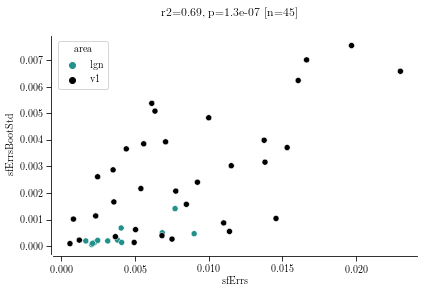

In [1066]:
subset_full = False;
# if true, then plot for all
# if false, then only those that pass

whichErr = 'sfErrs'
# whichErr = 'sfErrsBootMdn'

saveName = '06_02a_sfVarMetric_stability_lgn_v1_%s.pdf' % ('full' if subset_full else 'pass')

err, errStd = np.transpose(which_data[[whichErr, 'sfErrsBootStd']].dropna().values, )

cutoff = np.nanpercentile(errStd, 75)

which_data = df_only_full if subset_full else df_only_pass;
# which_data = which_data[which_data['sfErrs']<0.15]; # filter out some extreme values
# which_data = which_data[which_data['sfErrsBootStd']<cutoff]; # filter out some extreme values

f = plt.figure(figsize=hf.set_size(tex_width));
sns.scatterplot(data=which_data, x=whichErr, y='sfErrsBootStd', hue='area', palette=colors);
# plt.yscale('log')
r2,p,n = pearson_r_pandas(which_data, whichErr, 'sfErrsBootStd')
f.suptitle('r2=%.2f, p=%.1e [n=%d]' % (r2,p,n));
sns.despine(offset=sns_offset)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

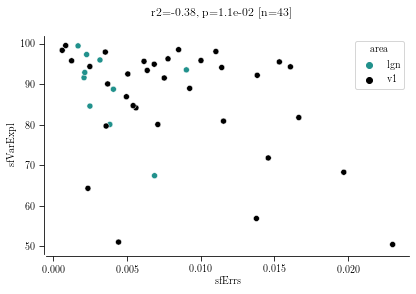

In [1067]:
subset_full = False;
# if true, then plot for all
# if false, then only those that pass

saveName = '06_02b_sfVarMetric_stability_alt_lgn_v1_%s.pdf' % ('full' if subset_full else 'pass')

whichErr = 'sfErrs'
# whichErr = 'sfErrsBootMdn'

err, errStd = np.transpose(which_data[[whichErr, 'sfVarExpl']].dropna().values, )

which_data = df_only_full if subset_full else df_only_pass;
# throw out one value odd value
which_data = which_data[which_data['sfVarExpl']>0]; # filter out some extreme values
# which_data = which_data[which_data['sfErrsBootStd']<cutoff]; # filter out some extreme values

f = plt.figure(figsize=hf.set_size(tex_width));
sns.scatterplot(data=which_data, x=whichErr, y='sfVarExpl', hue='area', palette=colors);
# plt.yscale('log')
r2,p,n = pearson_r_pandas(which_data, whichErr, 'sfVarExpl')
f.suptitle('r2=%.2f, p=%.1e [n=%d]' % (r2,p,n));
sns.despine(offset=sns_offset)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

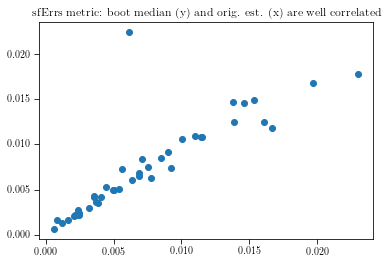

In [1068]:
aa,bb = np.transpose(which_data[['sfErrs', 'sfErrsBootMdn']].dropna().values, )
plt.scatter(aa,bb);
plt.title('sfErrs metric: boot median (y) and orig. est. (x) are well correlated');

**Both of the above plots show that this metric might be problematic!**

While it shows hints of reflecting some frequency-dependent process, the measure is too correlated with noise to be trusted. Namely, the sfErr metric has systematically higher variance across bootstrap repititions for higher value sfErrs!

### 6.3 For cells that pass, what are some tuning differences between LGN and V1?

In [981]:
df_only_pass.groupby('area')['maxResp', 'meanResp', 'oriBW', 'bw34', 'bw34_split', 'c50_pref_emp', 'rfsize', 'rfsize_surr', 'suprInd', 
                                   'f1f0', 'sfVarExpl', 'isSimple', 'charFreq'].mean()

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


maxResp  meanResp  oriBW  bw34  bw34_split  c50_pref_emp  rfsize  \
area                                                                     
lgn    39.892    23.376    nan 1.612       2.176         0.283   0.842   
v1     50.755    15.363 78.355 1.671       1.011         0.309   1.517   

      rfsize_surr  suprInd  f1f0  sfVarExpl  isSimple  charFreq  
area                                                             
lgn         1.610    0.136 1.857     79.248     1.000     2.843  
v1          3.835    0.424 0.955     86.016     0.394     4.745

In [982]:
use_all_data = False;
which_data = df if use_all_data else df_only_pass

to_test = ['maxResp', 'meanResp', 'oriBW', 'bw34', 'bw34_split', 'bwHalf_split', 'c50_pref_emp', 'suprInd', 
                                   'f1f0', 'sfVarExpl', 'charFreq']
for fld in to_test:
    valz = (*which_data.groupby('area')[fld].apply(list), )
    ncells = [len(hf.nan_rm(np.array(x))) for x in valz]
    tst_t = ss.ttest_ind(*valz, nan_policy='omit')
    tst_k = ss.ks_2samp(*valz, )
    
    print('%s %.2f[%d] vs %.2f[%d]: \n\tp=%.2e [t]\n\tp=%.2e [ks]' % (fld, np.nanmean(valz[0]), ncells[0], 
                                                  np.nanmean(valz[1]), ncells[1], tst_t.pvalue, tst_k.pvalue))
    

maxResp 39.89[12] vs 50.75[33]: 
	p=4.47e-01 [t]
	p=6.02e-01 [ks]
meanResp 23.38[12] vs 15.36[33]: 
	p=8.61e-02 [t]
	p=4.37e-03 [ks]
oriBW nan[0] vs 78.35[33]: 
	p=nan [t]
	p=6.95e-11 [ks]
bw34 1.61[4] vs 1.67[28]: 
	p=8.46e-01 [t]
	p=1.17e-02 [ks]
bw34_split 2.18[11] vs 1.01[32]: 
	p=1.50e-02 [t]
	p=2.13e-02 [ks]
bwHalf_split 2.64[11] vs 1.36[32]: 
	p=1.33e-02 [t]
	p=3.23e-02 [ks]
c50_pref_emp 0.28[12] vs 0.31[33]: 
	p=6.68e-01 [t]
	p=3.29e-01 [ks]
suprInd 0.14[12] vs 0.42[33]: 
	p=7.36e-03 [t]
	p=6.16e-03 [ks]
f1f0 1.86[12] vs 0.96[33]: 
	p=2.09e-06 [t]
	p=1.51e-07 [ks]
sfVarExpl 79.25[11] vs 86.02[33]: 
	p=3.51e-01 [t]
	p=9.70e-01 [ks]
charFreq 2.84[11] vs 4.75[33]: 
	p=8.17e-02 [t]
	p=1.86e-01 [ks]


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:1070: RuntimeWarning: divide by zero encountered in true_divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Warning: converting a masked element to nan.
  del sys.path[0]


##### So, there is a marked difference between LGN and V1 in terms of:
- bandwidth on the high spatial frequency limb (more measurable than total bandwidth, often undefined for LGN cells)
    - LGN more broadly tuned than V1, of course
- suppression index (for rfSize experiment)
    - LGN less surround suppressed than V1

*Let's look first if it those two metrics are correlated with one another in our dataset:*

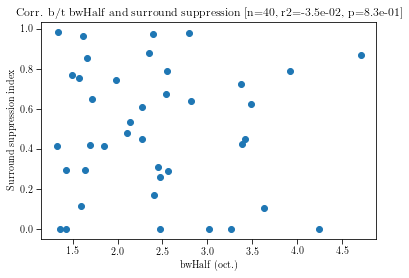

In [983]:
useBwHalf = True;
all_v1_data = False; # if all V1, then include even cells which don't have full superpos. experiment
df_all_v1 = df[df['area']=='v1']

bwStr = 'bwHalf' if useBwHalf else 'bw34';
use_data = df_all_v1 if all_v1_data else df_only_full_v1

bwHalf, bw34, bw34_split, suprInd = (*np.transpose(use_data[['bwHalf', 'bw34', 'bw34_split', 'suprInd']].values), )

which_bw = bwHalf if useBwHalf else bw34;

plt.scatter(which_bw, suprInd)
nn = np.logical_and(~np.isnan(which_bw), ~np.isnan(suprInd))
oh = ss.linregress(which_bw[nn], suprInd[nn])
plt.xlabel('%s (oct.)' % bwStr)
plt.ylabel('Surround suppression index')
plt.title('Corr. b/t %s and surround suppression [n=%d, r2=%.1e, p=%.1e]' % (bwStr, np.sum(nn), oh.rvalue, oh.pvalue));

Regardless of whether we include all V1 data or only those that have a full superposition experiment, **there is no correlation between surround suppression index and spatial frequency bandwidth.**

So, one way of digging deeper into this dataset is to see if the subset of V1 neurons that are more LGN like (whether lower surround suppression or more broadly tuned) are more LGN-like. We can check that below

In [1026]:
area = 'v1'
# area = 'lgn'
pearson_r_pandas(df_only_pass[df_only_pass['area']==area], 'sfErrs', 'sfVarExpl')
# or all together
# pearson_r_pandas(df_only_pass, 'sfErrs', 'charFreq')

(-0.37426461076581785, 0.031892080207174336, 33)

In [1032]:
df_only_pass.groupby('area').corr()['sfErrs']

area                    
lgn   isSimple                nan
      cellNum               0.487
      f1f0                  0.442
      sfVarExpl            -0.157
      charFreq             -0.089
                            ...  
v1    isFullDisp              nan
      threshPass              nan
      super_varExpl_clip   -0.415
      svec                 -0.415
      c50emp               -0.080
Name: sfErrs, Length: 68, dtype: float64

In [1029]:
to_use = df_only_full_v1[df_only_full_v1['threshPass']]
print(to_use.groupby('isSimple')['threshPass'].count())
print(df_all_v1.groupby('isSimple')['threshPass'].count())


isSimple
0.000    20
1.000    13
Name: threshPass, dtype: int64
isSimple
0.000    122
1.000     48
Name: threshPass, dtype: int64


Of the 33 passed V1 cells, 20 (\~60% are complex) and 13 are simple; this is actually an overrepresentation of simple cells (\~72% complex in full population)

### 6.4 Relationship between mixture summation metrics and other metrics!

In [1093]:
which_exp_code = 0; # 0 for LGN, 1 for V1, 2 for both

if which_exp_code==0: # lgn
    which_exp = 'LGN'
    which_data_curr = df_only_pass[df_only_pass['area']=='lgn']
    which_colors = colors[0]
elif which_exp_code==1: # v1
    which_exp = 'V1'
    which_colors = colors[1]
    which_data_curr = df_only_pass[df_only_pass['area']=='v1']
else:
    which_colors = colors;
    which_exp = 'both'
    which_data_curr = df_only_pass

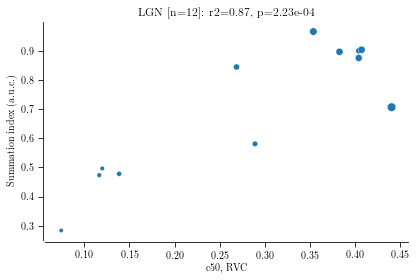

In [1094]:
x = 'c50emp'
y = 'auc'

saveName = '06_04a_summation_grat_v_mix_%s.pdf' % (which_exp)

f = plt.figure(figsize=hf.set_size(tex_width))

if which_exp_code==2:
    sns.scatterplot(data=which_data_curr, x=x, y=y, hue='area', size='aucStd', legend=False, palette=which_colors);
else: # no hue spec
    sns.scatterplot(data=which_data_curr, x=x, y=y, size='aucStd', legend=False, palette=which_colors);
r2, p, n = pearson_r_pandas(which_data_curr, x, y);
plt.xlabel('c50, RVC');
plt.ylabel('Summation index (a.u.c.)');
plt.title('%s [n=%d]: r2=%.2f, p=%.2e' % (which_exp, n, r2, p))
sns.despine(offset=sns_offset)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

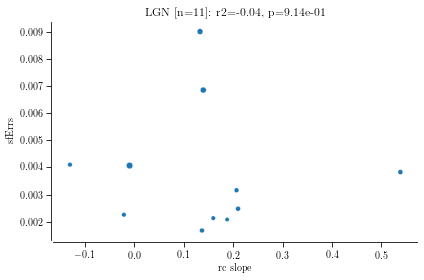

In [1095]:
x = 'slope'
y = 'sfErrs'

saveName = '06_04b_summation_grat_v_mix_%s.pdf' % (which_exp)

f = plt.figure(figsize=hf.set_size(tex_width))

if which_exp_code==2:
    sns.scatterplot(data=which_data_curr, x=x, y=y, hue='area', size='sfErrsBootStd', legend=False, palette=which_colors);
else: # no hue spec
    sns.scatterplot(data=which_data_curr, x=x, y=y, size='sfErrsBootStd', legend=False, palette=which_colors);
r2, p, n = pearson_r_pandas(which_data_curr, x, y);
plt.xlabel('rc slope');
plt.ylabel('sfErrs');
plt.title('%s [n=%d]: r2=%.2f, p=%.2e' % (which_exp, n, r2, p))
sns.despine(offset=sns_offset)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

### 6.5 Breaking down V1 by higher/lower suprInd and bandwidth

In [1144]:
# starting with only V1
splitSuprInd = 1; # 1 for suprInd, 0 for bw
splitAbove = 0; # 1 for higher values, 0 for lower values

splitStr = 'bw' if splitSuprInd==0 else 'suprInd'
splitStr = '%s%s' % (splitStr, 'Higher' if splitAbove==1 else 'Lower')

ky = 'suprInd' if splitSuprInd==1 else 'bw34';

which_data_curr = df_only_pass[df_only_pass['area']=='v1']
cutoff = np.nanpercentile(df_only_pass[ky], 50)
if splitAbove==1:
    which_data_curr = which_data_curr[which_data_curr[ky]>=cutoff]
else:
    which_data_curr = which_data_curr[which_data_curr[ky]<cutoff]

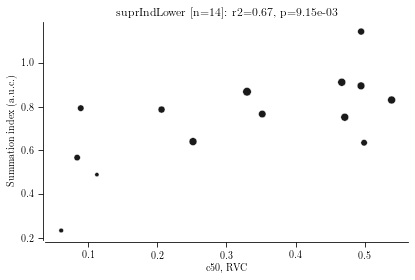

In [1145]:
x = 'c50emp'
y = 'auc'

saveName = '06_05a_summation_grat_v_mix_v1_%s.pdf' % (splitStr)

f = plt.figure(figsize=hf.set_size(tex_width))

sns.scatterplot(data=which_data_curr, x=x, y=y, size='aucStd', legend=False, color='k');
r2, p, n = pearson_r_pandas(which_data_curr, x, y);
plt.xlabel('c50, RVC');
plt.ylabel('Summation index (a.u.c.)');
plt.title('%s [n=%d]: r2=%.2f, p=%.2e' % (splitStr, n, r2, p))
sns.despine(offset=sns_offset)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

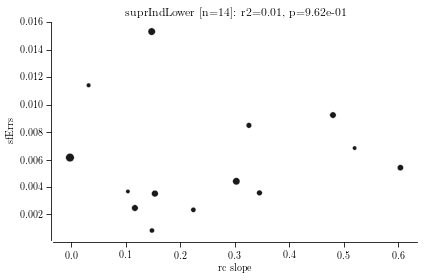

In [1146]:
x = 'slope'
y = 'sfErrs'

saveName = '06_05b_summation_grat_v_mix_%s.pdf' % (splitStr)

f = plt.figure(figsize=hf.set_size(tex_width))

sns.scatterplot(data=which_data_curr, x=x, y=y, size='sfErrsBootStd', legend=False, color='k');
r2, p, n = pearson_r_pandas(which_data_curr, x, y);
plt.xlabel('rc slope');
plt.ylabel('sfErrs');
plt.title('%s [n=%d]: r2=%.2f, p=%.2e' % (splitStr, n, r2, p))
sns.despine(offset=sns_offset)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

# 7. Model tests/verification 

In [2496]:
autoreload.reload(mrpt); autoreload.reload(hf);

In [2524]:
cellNum=4
respMeasure = 0
respStr = hf.get_resp_str(respMeasure)

expDir = 'altExp/'; # for now, V1_BB/ or altExp/
fitDate = '230107'; # add any suffix here!
fitHPC  = 1;
fixRespExp = 2; # or None?
scheduler = False
lgnFrontEnd = 0; # on [1] or off [0]
todoCV = True;

excType = 1
lgnFrontEnd = 0;
lgnConType = 1;
vecCorrected = 0;
lossType = 1; # should be unchanged
loc_str = 'HPC' if fitHPC else '';
_applyLGNtoNorm = 1;

fL_name = 'fitList%s_pyt_nr%s%s%s' % (loc_str, fitDate, '_noRE' if fixRespExp is not None else '', 
                                             '_noSched' if scheduler==False else '');

fitListName_flat = hf.fitList_name(base=fL_name, fitType=1, lossType=lossType, lgnType=lgnFrontEnd, 
                              lgnConType=lgnConType, vecCorrected=vecCorrected, CV=0, excType=excType);
fitListName_wght = hf.fitList_name(base=fL_name, fitType=2, lossType=lossType, lgnType=lgnFrontEnd, 
                              lgnConType=lgnConType, vecCorrected=vecCorrected, CV=0, excType=excType);

fl = hf.np_smart_load('%sstructures/%s' % (expDir, fitListName_flat)) 
wt = hf.np_smart_load('%sstructures/%s' % (expDir, fitListName_wght)) 

### Load data (to use for vExp calc.)
data_loc = base_dir + '%sstructures/' % expDir
expName = hf.get_datalist(expDir, force_full=True);
dataList = hf.np_smart_load(str(data_loc + expName))
expInd   = hf.exp_name_to_ind(dataList['expType'][cellNum-1]);

expData = hf.np_smart_load(data_loc + '%s_sfm.npy' % dataList['unitName'][cellNum-1])
trialInf = expData['sfm']['exp']['trial']
dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd)

##### Does the same grating (SF, total con) spread over multiple components?

In [2794]:
nDig = 3; # to round
# make all phases, tfs, sfs the same!
dw.trInf['ph'][0:5] = dw.trInf['ph'][0,0]
dw.trInf['tf'][0:5] = dw.trInf['tf'][0,0]
dw.trInf['sf'][0:5] = dw.trInf['sf'][0,0]
# Now, contrast:
dw.trInf['con'][0:5] = mrpt._cast_as_tensor(0); # first, zero all of the contrasts
# --- single, two, three, five, seven
dw.trInf['con'][0,0] = mrpt._cast_as_tensor(1);
dw.trInf['con'][1,0:2] = mrpt._cast_as_tensor(0.5);
dw.trInf['con'][2,0:3] = mrpt._cast_as_tensor(1/3);
dw.trInf['con'][3,0:5] = mrpt._cast_as_tensor(1/5);
dw.trInf['con'][4,0:7] = mrpt._cast_as_tensor(1/7);

# However, let's first make a version of our flat model which is just the weighted model parameters 
# This way, we've truly isolated the impact of the weighted gain control
fl_prms_true = fl[cellNum-1][respStr]['params'];
wt_prms = wt[cellNum-1][respStr]['params']
fl_dumb = np.copy(wt_prms[0:len(fl_prms_true)])
fl_dumb[-1] = 0; # last parameter doesn't matter anyway (it's asymmetry), but set to 0

# fl_to_use = fl_dumb
fl_to_use = fl_prms_true

# Now, run the model 
# flat
mod_fl = mrpt.sfNormMod(fl_to_use, expInd=expInd, excType=excType, normType=1, lossType=lossType,  
                     lgnFrontEnd=lgnFrontEnd, lgnConType=lgnConType, applyLGNtoNorm=1)
modResp_fl = mod_fl.forward(dw.trInf, respMeasure=respMeasure).detach().numpy()
print('Flat:\n\t');
print(np.round(modResp_fl[0:5], nDig))
print('\tRelative response fraction')
print(np.round(modResp_fl[0:5]/modResp_fl[0], nDig))
# wt
mod_wt = mrpt.sfNormMod(wt_prms, expInd=expInd, excType=excType, normType=2, lossType=lossType,  
                     lgnFrontEnd=lgnFrontEnd, lgnConType=lgnConType, applyLGNtoNorm=1)
modResp_wt = mod_wt.forward(dw.trInf, respMeasure=respMeasure).detach().numpy()
print('Flat:\n\t');
print(np.round(modResp_wt[0:5], nDig))
print('\tRelative response fraction')
print(np.round(modResp_wt[0:5]/modResp_wt[0], nDig))

Flat:
	
[44.662 44.662 44.662 44.662 44.662]
	Relative response fraction
[1. 1. 1. 1. 1.]
Flat:
	
[45.27 45.27 45.27 45.27 45.27]
	Relative response fraction
[1. 1. 1. 1. 1.]


Ok, good! Now, what if we vary the phase only?

Flat:
	
[44.667 43.494 38.589 34.379 34.848]
	Relative response fraction
[1.    0.974 0.864 0.77  0.78 ]
Wght:
	
[45.273 44.229 39.604 35.445 36.039]
	Relative response fraction
[1.    0.977 0.875 0.783 0.796]


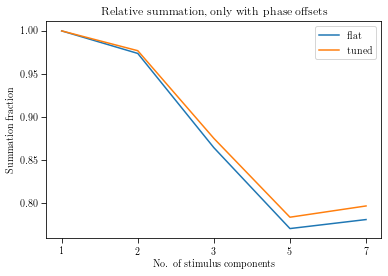

In [2625]:
nTrs = 5;

# choose one of the below...
### specific phase
# dw.trInf['ph'][0:5] = dw.trInf['ph'][300:305]
### random phases
dw.trInf['ph'][0:nTrs] = dw.trInf['ph'][np.random.randint(0,dw.trInf['ph'].shape[0], nTrs)]

# Now, run the model 
# flat
mod_fl = mrpt.sfNormMod(fl_to_use, expInd=expInd, excType=excType, normType=1, lossType=lossType,  
                     lgnFrontEnd=lgnFrontEnd, lgnConType=lgnConType, applyLGNtoNorm=1)
modResp_fl = mod_fl.forward(dw.trInf, respMeasure=respMeasure).detach().numpy()
print('Flat:\n\t');
print(np.round(modResp_fl[0:nTrs], nDig))
print('\tRelative response fraction')
print(np.round(modResp_fl[0:nTrs]/modResp_fl[0], nDig))
# wt
mod_wt = mrpt.sfNormMod(wt_prms, expInd=expInd, excType=excType, normType=2, lossType=lossType,  
                     lgnFrontEnd=lgnFrontEnd, lgnConType=lgnConType, applyLGNtoNorm=1)
modResp_wt = mod_wt.forward(dw.trInf, respMeasure=respMeasure).detach().numpy()
print('Wght:\n\t');
print(np.round(modResp_wt[0:nTrs], nDig))
print('\tRelative response fraction')
print(np.round(modResp_wt[0:nTrs]/modResp_wt[0], nDig))

### now plot
plt.plot(modResp_fl[0:nTrs]/modResp_fl[0], label='flat')
plt.plot(modResp_wt[0:nTrs]/modResp_wt[0], label='tuned');
plt.legend();
plt.title('Relative summation, only with phase offsets');
plt.ylabel('Summation fraction');
nComps = np.sum(dw.trInf['con'][0:nTrs].detach().numpy()>0,axis=1);
plt.xticks(ticks=np.arange(nTrs), labels=['%d' % x for x in nComps]);
plt.xlabel('No. of stimulus components');

And tf only? (Restoring phase back to all the same)

Flat:
	
[44.662 37.758 37.353 32.523 31.884]
	Relative response fraction
[1.    0.845 0.836 0.728 0.714]
Wght:
	
[45.27  38.6   38.455 33.607 32.992]
	Relative response fraction
[1.    0.853 0.849 0.742 0.729]


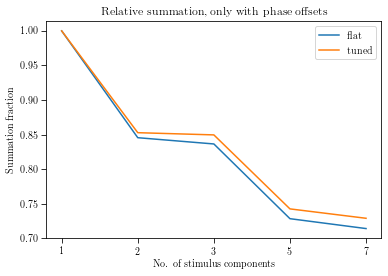

In [2631]:
dw.trInf['ph'][0:5] = dw.trInf['ph'][0,0]
### specific values
# dw.trInf['tf'][0:5] = dw.trInf['tf'][300:305]
# dw.trInf['tf'][0:5] = dw.trInf['tf'][306:311]
### OR random
dw.trInf['tf'][0:nTrs] = dw.trInf['tf'][np.random.randint(0,dw.trInf['tf'].shape[0], nTrs)]

# Now, run the model 
# flat
mod_fl = mrpt.sfNormMod(fl_to_use, expInd=expInd, excType=excType, normType=1, lossType=lossType,  
                     lgnFrontEnd=lgnFrontEnd, lgnConType=lgnConType, applyLGNtoNorm=1)
modResp_fl = mod_fl.forward(dw.trInf, respMeasure=respMeasure).detach().numpy()
print('Flat:\n\t');
print(np.round(modResp_fl[0:5], nDig))
print('\tRelative response fraction')
print(np.round(modResp_fl[0:5]/modResp_fl[0], nDig))
# wt
mod_wt = mrpt.sfNormMod(wt_prms, expInd=expInd, excType=excType, normType=2, lossType=lossType,  
                     lgnFrontEnd=lgnFrontEnd, lgnConType=lgnConType, applyLGNtoNorm=1)
modResp_wt = mod_wt.forward(dw.trInf, respMeasure=respMeasure).detach().numpy()
print('Wght:\n\t');
print(np.round(modResp_wt[0:5], nDig))
print('\tRelative response fraction')
print(np.round(modResp_wt[0:5]/modResp_wt[0], nDig))

### now plot
plt.plot(modResp_fl[0:nTrs]/modResp_fl[0], label='flat')
plt.plot(modResp_wt[0:nTrs]/modResp_wt[0], label='tuned');
plt.legend();
plt.title('Relative summation, only with phase offsets');
plt.ylabel('Summation fraction');
nComps = np.sum(dw.trInf['con'][0:nTrs].detach().numpy()>0,axis=1);
plt.xticks(ticks=np.arange(nTrs), labels=['%d' % x for x in nComps]);
plt.xlabel('No. of stimulus components');

### Interim summary:

- The normalization works as expected, on the basis of 5 20% gratings yielding the same response as 1 grating at full contrast **when the spatial frequency, phase, and temporal frequency are the same.**
- Furthermore, *the model takes into account stimulus interactions!* This is evident in the reduction in response amplitude once we desynchronize the phases and/or temporal frequencies of the multiple gratings
- The reductions noted (e.g. 50-80% reduction in the mixtures relative to the isolated grating) are just examples. The relative reduction will vary based on how many components and the relative sf/tf/ph values!



First, make the SFs, _slightly_ off from one another

In [2576]:
how_many_trs = 3;

# make all phases, tfs, sfs the same!
dw.trInf['ph'][0:how_many_trs] = dw.trInf['ph'][0,0]
dw.trInf['tf'][0:how_many_trs] = dw.trInf['tf'][0,0]
# Now, contrast:
dw.trInf['con'][0:how_many_trs] = mrpt._cast_as_tensor(0); # first, zero all of the contrasts
# first, canonical SF, half contrast
dw.trInf['con'][0,0] = mrpt._cast_as_tensor(1);
dw.trInf['sf'][0] = dw.trInf['sf'][0,0]
# then, slightly different SF (also 50% contrast)
dw.trInf['con'][1,0] = mrpt._cast_as_tensor(1);
dw.trInf['sf'][1] = dw.trInf['sf'][0,0]*10;
# then, the mixture
dw.trInf['con'][2,0:2] = mrpt._cast_as_tensor(1/2);
dw.trInf['sf'][2,0:2] = mrpt._cast_as_tensor([dw.trInf['sf'][0,0], dw.trInf['sf'][1,0]])

# However, let's first make a version of our flat model which is just the weighted model parameters 
# This way, we've truly isolated the impact of the weighted gain control
fl_prms_true = fl[cellNum-1][respStr]['params'];
wt_prms = wt[cellNum-1][respStr]['params']
fl_dumb = np.copy(wt_prms[0:len(fl_prms_true)])
fl_dumb[-1] = 0; # last parameter doesn't matter anyway (it's asymmetry), but set to 0

fl_to_use = fl_dumb

# Now, run the model 
# flat
mod_fl = mrpt.sfNormMod(fl_to_use, expInd=expInd, excType=excType, normType=1, lossType=lossType,  
                     lgnFrontEnd=lgnFrontEnd, lgnConType=lgnConType, applyLGNtoNorm=1)
modResp_fl = mod_fl.forward(dw.trInf, respMeasure=respMeasure).detach().numpy()
print('Flat:\n\t');
print(np.round(modResp_fl[0:how_many_trs], nDig))
# print('\tRelative response fraction')
# print(np.round(modResp_fl[0:how_many_trs]/modResp_fl[0], nDig))
# wt
mod_wt = mrpt.sfNormMod(wt_prms, expInd=expInd, excType=excType, normType=2, lossType=lossType,  
                     lgnFrontEnd=lgnFrontEnd, lgnConType=lgnConType, applyLGNtoNorm=1)
modResp_wt = mod_wt.forward(dw.trInf, respMeasure=respMeasure).detach().numpy()
print('Wght:\n\t');
print(np.round(modResp_wt[0:how_many_trs], nDig))
# print('\tRelative response fraction')
# print(np.round(modResp_wt[0:how_many_trs]/modResp_wt[0], nDig))

Flat:
	
[76.274 17.274 62.432]
Wght:
	
[45.273 23.646 53.292]


#### Extra: Trying out different normalization pools (again...)

In [2774]:
def plot_norm_pool(mod_prms, trialInf, expInd, nFilts=[12,15], dord=[0.75, 1.5], respMeasure=0):
    
    model = mrpt.sfNormMod(mod_prms, expInd=expInd, excType=1, normType=1, 
                       lossType=1, lgnFrontEnd=0, newMethod=1, 
                       lgnConType=1, applyLGNtoNorm=1, norm_nFilters=nFilts, norm_dOrd=dord)

    dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd)

    # make artificial SFs for sampling tuning (n=20 to fit evenly into 1660)
    sfs_test = np.geomspace(0.1,30,83);
    nTr = dw.trInf['sf'].shape[0]
    sfs_tile = np.repeat(sfs_test, nTr/len(sfs_test))
    dw.trInf['sf'] = np.tile(np.expand_dims(sfs_tile, 1), 7);
    dw.trInf['con'] = np.tile(np.expand_dims(np.ones_like(sfs_tile), 1), 7)
    
    mod_resps = model.forward(dw.trInf, respMeasure=respMeasure).detach().numpy()
    
    selSf, stimSf = model.FullNormResp(dw.trInf, debugFilters=True);
    wide = selSf[0:model.normFull['nFilters'][0]]
    narrow = selSf[model.normFull['nFilters'][0]:]
    
    ### NOW PLOT
    f, ax = plt.subplots(2, 1, figsize=(15,10));

    ttls = ['Wide', 'Narrow']
    clrs = ['k', 'r']
    sf_dig = 3;
    # sf_dig = 1;

    # NOTE: Igorning final two gratins because they introduce small differences that are annoying to round out...
    # ..... doesn't affect the results in anyway
    all_sfs = np.unique(np.round(stimSf[:,0:5], sf_dig))
    # all_sfs = np.unique(stimSf);
    nStimComp = wide.shape[1];

    for use_narrow, ttl, clr in zip(range(2), ttls, clrs):

        curr_bank = narrow if use_narrow else wide;
        nFilt = curr_bank.shape[0] # was -1 earlier
        clrs = cm.viridis(np.linspace(0,1,nFilt));

        overall_sum = np.zeros((len(all_sfs),))
        overall_count = np.zeros((len(all_sfs),))

        for filt in range(nFilt):
            use_wide = True;

            for stimComp in range(5):

                sfs, unq_inds = np.unique(np.round(stimSf[:, stimComp], sf_dig), return_index=True);

                ax[use_narrow].plot(sfs, curr_bank[filt, unq_inds, stimComp].detach().numpy(), color=clrs[filt])

                curr_sf_inds = np.where(np.in1d(all_sfs, sfs))[0];
                overall_sum[curr_sf_inds] += curr_bank[filt, unq_inds, stimComp].detach().numpy();
                overall_count[curr_sf_inds] += 1

                ax[use_narrow].set_xscale('log');

        avg_tuning = overall_sum/overall_count;
        [ax[i].plot(all_sfs, avg_tuning/np.max(avg_tuning), color=clr, label='%s' % ttl) for i in range(2)]
        dOrd = model.normFull['dOrd'][use_narrow]
        ax[use_narrow].set_title('%s filters [n=%d, dOrd=%.2f]' % (ttl, nFilt, dOrd));

    for i in range(2):
        ax[i].legend();

    return f;

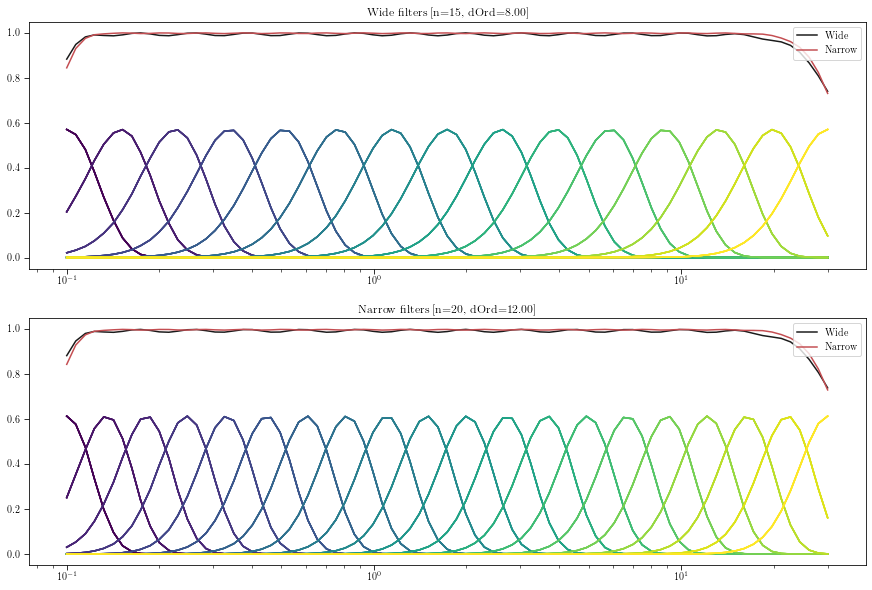

In [2777]:
# narrow filters
ah = plot_norm_pool(fl_to_use, trialInf, expInd, dord=[8, 12], nFilts=[15, 20]);


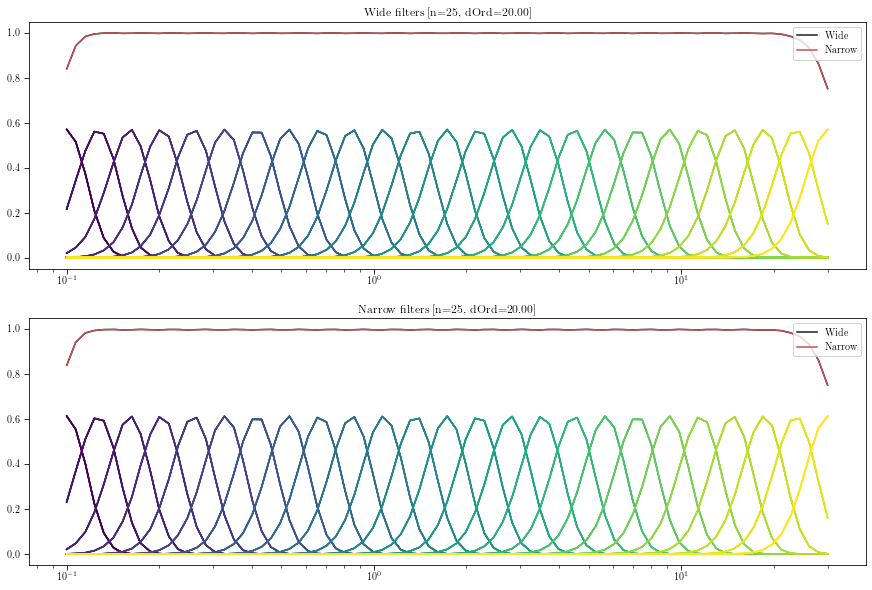

In [2785]:
# narrow filters
ah = plot_norm_pool(fl_to_use, trialInf, expInd, dord=[20, 20], nFilts=[25,25]);


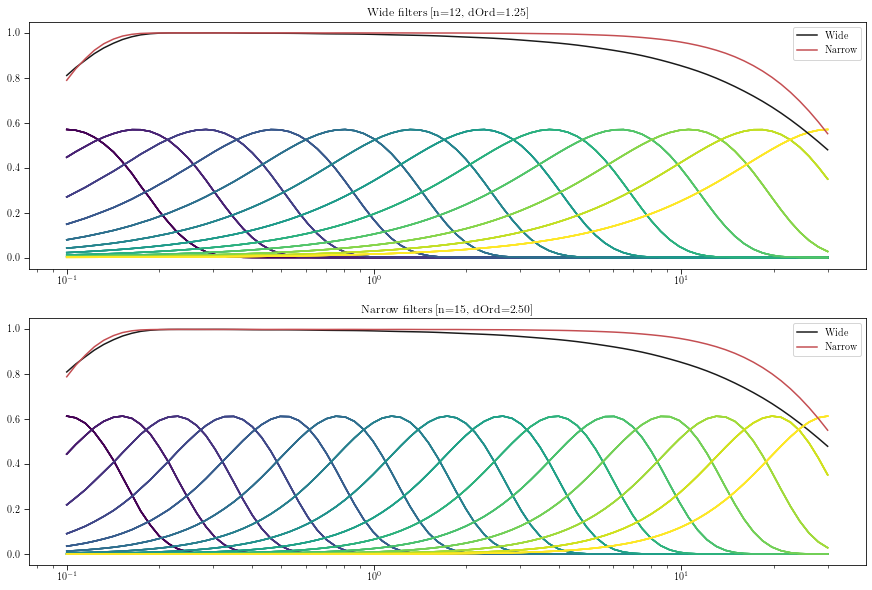

In [2793]:
# narrow filters
ah = plot_norm_pool(fl_to_use, trialInf, expInd, dord=[1.25, 2.5], nFilts=[12,15]);


#### Extra: LGN front-end (partial sketch)

In [2877]:
fitListName_lgn = hf.fitList_name(base=fL_name, fitType=1, lossType=lossType, lgnType=4, 
                              lgnConType=lgnConType, vecCorrected=vecCorrected, CV=0, excType=excType);

lgn = hf.np_smart_load('%sstructures/%s' % (expDir, fitListName_lgn)) 
lgn_mod = mrpt.sfNormMod(lgn[3]['dc']['params'], expInd, excType, 1, lossType, 4, newMethod=1, 
                          lgnConType=1, applyLGNtoNorm=1)


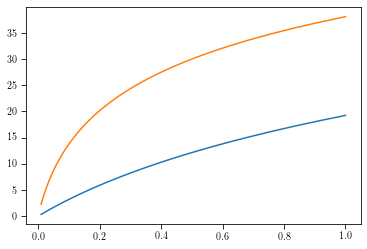

In [2878]:
cns = mrpt._cast_as_tensor(np.geomspace(0.01, 1, 50));
prm_p = lgn_mod.rvc_p
prm_m = lgn_mod.rvc_m
# oy = prm_m[1];
# prm_m[1] = prm_p[1]
# prm_p[1] = oy

# prm_m[1] /= 2
# prm_p[1] *= .5

prv = mrpt.get_rvc_model(prm_p, cns).detach().numpy()
mgn = mrpt.get_rvc_model(prm_m, cns).detach().numpy()
# mgn = mrpt.get_rvc_model(mpr, cns).detach().numpy()

plt.plot(cns.detach().numpy(), prv);
plt.plot(cns.detach().numpy(), mgn);
# plt.xscale('log')
# plt.yscale('log')

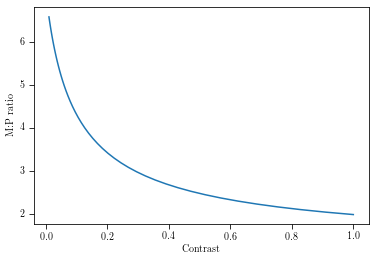

In [2884]:
plt.plot(cns.detach().numpy(), mgn/prv)
plt.ylabel('M:P ratio');
plt.xlabel('Contrast');